# NLP Course: Project 2.2  English-Italian Machine Translation



In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import random
from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
import nltk
from nltk.corpus import stopwords
import string
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
import gensim.downloader as api
from gensim.models import KeyedVectors
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, TimeDistributed
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
import os
from tensorflow.keras.layers import Embedding, LSTM, Dense, Input,RNN, Bidirectional,Dropout, TimeDistributed, Concatenate
from sklearn.model_selection import train_test_split
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.meteor_score import meteor_score
import warnings
warnings.filterwarnings("ignore")

# Mounting Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
english_file_path = '/content/drive/My Drive/it-en/europarl-v7.it-en.en'
italian_file_path = '/content/drive/My Drive/it-en/europarl-v7.it-en.it'

def read_data(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        lines = file.readlines()
    return lines

english_lines = read_data(english_file_path)
italian_lines = read_data(italian_file_path)

In [ ]:
# Viewing samples of sentences and their translations
num_samples_to_view = 5
print("Sampled Sentences and Their Translations:\n")
for i in range(num_samples_to_view):
    print(f"English: {english_lines[i].strip()}")
    print(f"Italian: {italian_lines[i].strip()}")
    print()

Sampled Sentences and Their Translations:

English: Resumption of the session
Italian: Ripresa della sessione

English: I declare resumed the session of the European Parliament adjourned on Friday 17 December 1999, and I would like once again to wish you a happy new year in the hope that you enjoyed a pleasant festive period.
Italian: Dichiaro ripresa la sessione del Parlamento europeo, interrotta venerdì 17 dicembre e rinnovo a tutti i miei migliori auguri nella speranza che abbiate trascorso delle buone vacanze.

English: Although, as you will have seen, the dreaded 'millennium bug' failed to materialise, still the people in a number of countries suffered a series of natural disasters that truly were dreadful.
Italian: Come avrete avuto modo di constatare il grande "baco del millennio" non si è materializzato. Invece, i cittadini di alcuni nostri paesi sono stati colpiti da catastrofi naturali di proporzioni davvero terribili.

English: You have requested a debate on this subject in 

In [ ]:
# Sampling 25% of the data as with full data EDA analyses took so much time
sample_size = int(len(english_lines) * 0.25)
sample_indices = random.sample(range(len(english_lines)), sample_size)

english_sampled_lines = [english_lines[i] for i in sample_indices]
italian_sampled_lines = [italian_lines[i] for i in sample_indices]

In [ ]:
def split_into_sentences(text):
    # Extended list of abbreviations that should not be split
    # abbreviations that might commonly appear in political news/, including titles, time indicators, and common abbreviations
    abbreviations = [
        'Dr', 'Mr', 'Mrs', 'Ms', 'Mx', 'Prof', 'Rev', 'Lt', 'Col', 'Gen', 'Sgt', 'Capt', 'St',
        'Jr', 'Sr', 'Hon', 'Gov', 'Pres', 'Sen', 'Rep', 'Amb', 'Adm', 'Cmdr', 'Cpt', 'Maj',
        'p.m', 'a.m', 'e.g', 'i.e', 'vs', 'Dept', 'Inc', 'Corp', 'Univ', 'Co', 'Ltd', 'Mt',
        'Ft', 'Ave', 'Rd', 'Blvd', 'Ln', 'Hwy', 'Est', 'U.S', 'U.K', 'E.U', 'B.C', 'A.D'
    ]

    # Create a temporary marker for abbreviations to prevent splitting
    for abbr in abbreviations:
        escaped_abbr = re.escape(abbr)  # Escape any special regex characters in the abbreviation
        text = re.sub(rf'\b{escaped_abbr}\.', f'{abbr}<abbr>', text)

    # Split the text by periods followed by a space or by question/exclamation marks
    sentences = re.split(r'(?<=[.!?])\s+', text)

    # Replace the temporary markers with the original periods
    sentences = [s.replace('<abbr>', '.') for s in sentences]

    # Post-process to trim any additional spaces introduced for safety
    sentences = [s.strip() for s in sentences if s.strip()]

    return sentences

In [ ]:
aligned_english_sentences = []
aligned_italian_sentences = []

english_sentence_counts = []
italian_sentence_counts = []

for eng_line, ita_line in zip(english_sampled_lines, italian_sampled_lines):
    eng_sentences = split_into_sentences(eng_line.strip())
    ita_sentences = split_into_sentences(ita_line.strip())
    english_sentence_counts.append(len(eng_sentences))
    italian_sentence_counts.append(len(ita_sentences))

    aligned_english_sentences.extend(eng_sentences)
    aligned_italian_sentences.extend(ita_sentences)

In [ ]:
# Analysis of sentence counts, if they match or in one language the number of sentences is more
# this analysis is for checking sentence alignment in data between languages
total_instances = len(english_sentence_counts)
more_english_sentences = sum(1 for eng_count, ita_count in zip(english_sentence_counts, italian_sentence_counts) if eng_count > ita_count)
more_italian_sentences = sum(1 for eng_count, ita_count in zip(english_sentence_counts, italian_sentence_counts) if ita_count > eng_count)
matching_sentence_counts = sum(1 for eng_count, ita_count in zip(english_sentence_counts, italian_sentence_counts) if eng_count == ita_count)

print(f"Total instances: {total_instances}")
print(f"More English sentences: {more_english_sentences} ({more_english_sentences / total_instances * 100:.2f}%)")
print(f"More Italian sentences: {more_italian_sentences} ({more_italian_sentences / total_instances * 100:.2f}%)")
print(f"Matching sentence counts: {matching_sentence_counts} ({matching_sentence_counts / total_instances * 100:.2f}%)")

Total instances: 477278
More English sentences: 36031 (7.55%)
More Italian sentences: 16762 (3.51%)
Matching sentence counts: 424485 (88.94%)


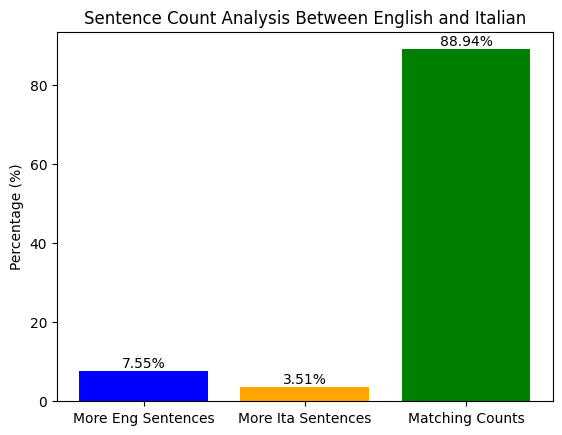

In [ ]:
# Plotting the analysis results
labels = ['More Eng Sentences', 'More Ita Sentences', 'Matching Counts']
counts = [more_english_sentences, more_italian_sentences, matching_sentence_counts]
percentages = [count / total_instances * 100 for count in counts]

fig, ax = plt.subplots()
ax.bar(labels, percentages, color=['blue', 'orange', 'green'])
ax.set_ylabel('Percentage (%)')
ax.set_title('Sentence Count Analysis Between English and Italian')

for i, v in enumerate(percentages):
    ax.text(i, v + 1, f"{v:.2f}%", ha='center')

plt.show()

In [ ]:
# Filtering instances where the number of sentences match and keep only the first sentences where the sentence count matches
filtered_english_sentences = []
filtered_italian_sentences = []

for eng_count, ita_count, eng_line, ita_line in zip(english_sentence_counts, italian_sentence_counts, english_sampled_lines, italian_sampled_lines):
    if eng_count == ita_count:
        eng_sentences = split_into_sentences(eng_line.strip())
        ita_sentences = split_into_sentences(ita_line.strip())
        filtered_english_sentences.append(eng_sentences[0])
        filtered_italian_sentences.append(ita_sentences[0])

final_df = pd.DataFrame({
    'English': filtered_english_sentences,
    'Italian': filtered_italian_sentences
})

print(final_df.head())

                                             English  \
0  We can finally say that we have come up with a...   
1  We have adjusted this with the criteria of fle...   
2  Thank you, Minister, for your first response d...   
3      The vote will be taken tomorrow at 11.30 a.m.   
4  Mr President, I was interested to hear Mr Tann...   

                                             Italian  
0  Finalmente possiamo dirci soddisfati del docum...  
1  Ci siamo regolati sulla base del criterio di f...  
2  Grazie, signor Ministro, per la sua prima risp...  
3       La votazione si svolgerà domani, alle 11.30.  
4  Signor Presidente, ho ascoltato con interesse ...  


In [ ]:
# Check for instances where if there is still case sentence counts do not match
mismatch_count = 0
for idx, row in final_df.iterrows():
    eng_sentences = split_into_sentences(row['English'])
    ita_sentences = split_into_sentences(row['Italian'])
    if len(eng_sentences) != len(ita_sentences):
        mismatch_count += 1
        print(f"Mismatch at index {idx}:")
        print(f"English: {row['English']} (Sentences: {len(eng_sentences)})")
        print(f"Italian: {row['Italian']} (Sentences: {len(ita_sentences)})\n")

print(f"Total mismatched instances: {mismatch_count}")

Total mismatched instances: 0


In [ ]:
final_df.duplicated().sum()

11874

In [ ]:
# Removing duplicates
final_df = final_df.drop_duplicates()

def filter_empty_lines(row):
    return bool(row['English'].strip()) and bool(row['Italian'].strip())

# Apply the function to filter the DataFrame
final_df = final_df[final_df.apply(filter_empty_lines, axis=1)]

# Resetting index after filtering
final_df = final_df.reset_index(drop=True)

In [ ]:
final_df.head()

,English,Italian
0,We can finally say that we have come up with a...,Finalmente possiamo dirci soddisfati del docum...
1,We have adjusted this with the criteria of fle...,Ci siamo regolati sulla base del criterio di f...
2,"Thank you, Minister, for your first response d...","Grazie, signor Ministro, per la sua prima risp..."
3,The vote will be taken tomorrow at 11.30 a.m.,"La votazione si svolgerà domani, alle 11.30."
4,"Mr President, I was interested to hear Mr Tann...","Signor Presidente, ho ascoltato con interesse ..."


In [ ]:
# Save the df to drive for later usage to keep same randomly sampled subset
final_csv_file_path = '/content/drive/My Drive/it-en/europarl-v7.it-en-aligned-sentences_25.csv'
final_df.to_csv(final_csv_file_path, index=False)

In [ ]:
final_csv_file_path = '/content/drive/My Drive/it-en/europarl-v7.it-en-aligned-sentences_25.csv'
final_df=pd.read_csv(final_csv_file_path)

In [ ]:
final_df.isnull().sum()

English    0
Italian    0
dtype: int64

In [ ]:
final_df.head()

,English,Italian
0,We can finally say that we have come up with a...,Finalmente possiamo dirci soddisfati del docum...
1,We have adjusted this with the criteria of fle...,Ci siamo regolati sulla base del criterio di f...
2,"Thank you, Minister, for your first response d...","Grazie, signor Ministro, per la sua prima risp..."
3,The vote will be taken tomorrow at 11.30 a.m.,"La votazione si svolgerà domani, alle 11.30."
4,"Mr President, I was interested to hear Mr Tann...","Signor Presidente, ho ascoltato con interesse ..."


In [ ]:
df=final_df.copy()

# EDA

In [ ]:
# Create a copy of df for EDA purposes
df_eda = df.copy()

### Analysis 1: Average Sentence Length Comparison in terms of word count between languages

In [ ]:
# Analysis 1: Average Word Count in Sentences Comparison
df_eda['English_Word_Count'] = df_eda['English'].apply(lambda x: len(x.split()))
df_eda['Italian_Word_Count'] = df_eda['Italian'].apply(lambda x: len(x.split()))

avg_word_count_english = df_eda['English_Word_Count'].mean()
avg_word_count_italian = df_eda['Italian_Word_Count'].mean()

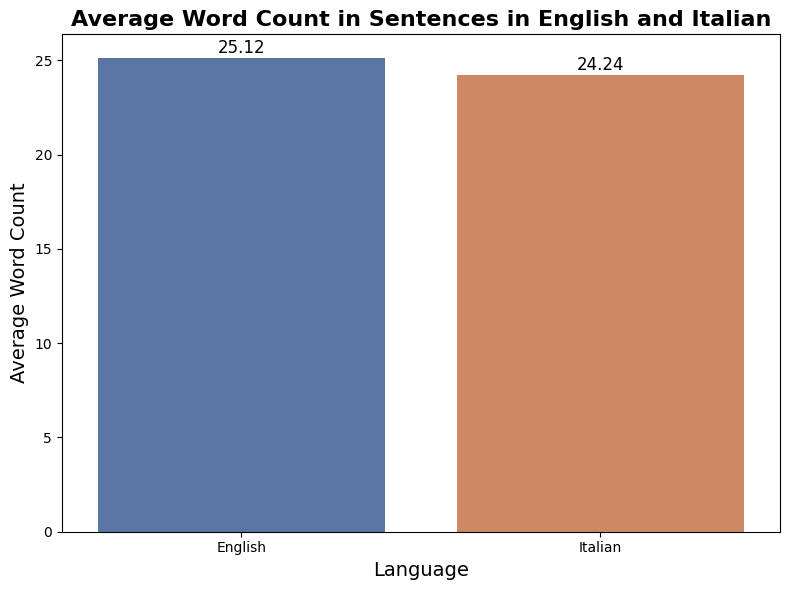

In [ ]:
plt.figure(figsize=(8, 6))
sns.barplot(x=['English', 'Italian'], y=[avg_word_count_english, avg_word_count_italian], palette=['#4C72B0', '#DD8452'])

plt.title('Average Word Count in Sentences in English and Italian', fontsize=16, weight='bold')
plt.ylabel('Average Word Count', fontsize=14)
plt.xlabel('Language', fontsize=14)

for i, value in enumerate([avg_word_count_english, avg_word_count_italian]):
    plt.text(i, value + 0.05, f"{value:.2f}", ha='center', va='bottom', fontsize=12)
plt.tight_layout()
plt.show()

In [ ]:
# mean and standard deviation of word counts in sentences
mean_std_df = pd.DataFrame({
    'Language': ['English', 'Italian'],
    'Mean Word Count': [df_eda['English_Word_Count'].mean(), df_eda['Italian_Word_Count'].mean()],
    'Standard Deviation': [df_eda['English_Word_Count'].std(), df_eda['Italian_Word_Count'].std()]
})

print(mean_std_df)

  Language  Mean Word Count  Standard Deviation
0  English        25.117893           14.209696
1  Italian        24.240076           13.857929


In [ ]:
# Analysis: Average Length of Sentences Comparison in terms of character count
df_eda['English_Length'] = df_eda['English'].apply(len)
df_eda['Italian_Length'] = df_eda['Italian'].apply(len)

avg_length_english = df_eda['English_Length'].mean()
avg_length_italian = df_eda['Italian_Length'].mean()
print(avg_length_english, avg_length_italian)

149.60868226974074 162.1108477476364


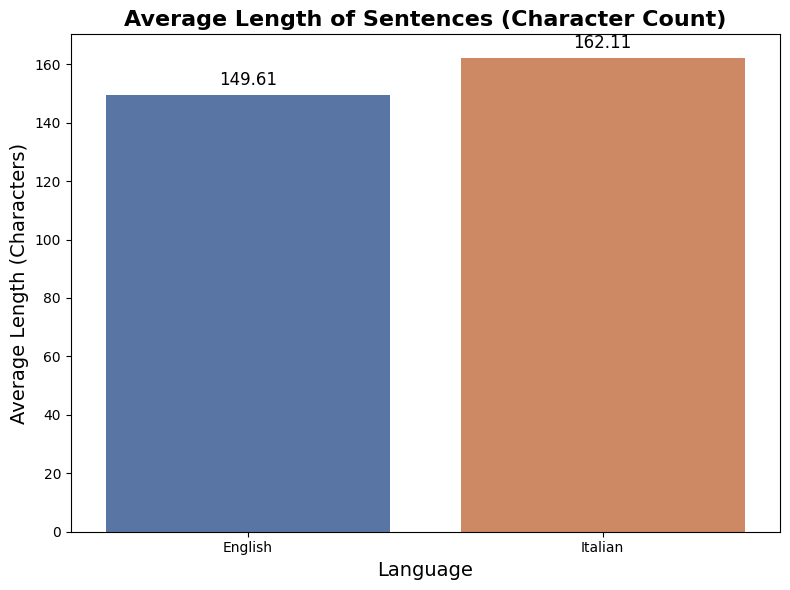

In [ ]:
plt.figure(figsize=(8, 6))
sns.barplot(x=['English', 'Italian'], y=[avg_length_english, avg_length_italian], palette=['#4C72B0', '#DD8452'])
plt.title('Average Length of Sentences (Character Count)', fontsize=16, weight='bold')
plt.ylabel('Average Length (Characters)', fontsize=14)
plt.xlabel('Language', fontsize=14)

# Adding value labels on top of the bars
for i, value in enumerate([avg_length_english, avg_length_italian]):
    plt.text(i, value + 2, f"{value:.2f}", ha='center', va='bottom', fontsize=12)
plt.tight_layout()
plt.show()

In [ ]:
# To count sentences in a text, avoiding splits at common abbreviations with split_into_sentences function
# Check if there is more than one sentence per row
def count_sentences(text):
    return len(split_into_sentences(text))

# to count sentences in each entry
df_eda['English_Sentence_Count'] = df_eda['English'].apply(count_sentences)
df_eda['Italian_Sentence_Count'] = df_eda['Italian'].apply(count_sentences)

# Sum the sentence counts to get the total number of sentences
total_sentences_english = df_eda['English_Sentence_Count'].sum()
total_sentences_italian = df_eda['Italian_Sentence_Count'].sum()

print(f"Total number of sentences in English corpus: {total_sentences_english}")
print(f"Total number of sentences in Italian corpus: {total_sentences_italian}")

Total number of sentences in English corpus: 412611
Total number of sentences in Italian corpus: 412611


In [ ]:
#matches as one sentence per line
df_eda.shape

(412611, 13)

### Analysis 2: Vocabulary Comparison: Number of Unique Words in Each Language

In [ ]:
def unique_words(text):
    return len(set(text.split()))

total_unique_english = len(set(' '.join(df_eda['English']).split()))
total_unique_italian = len(set(' '.join(df_eda['Italian']).split()))

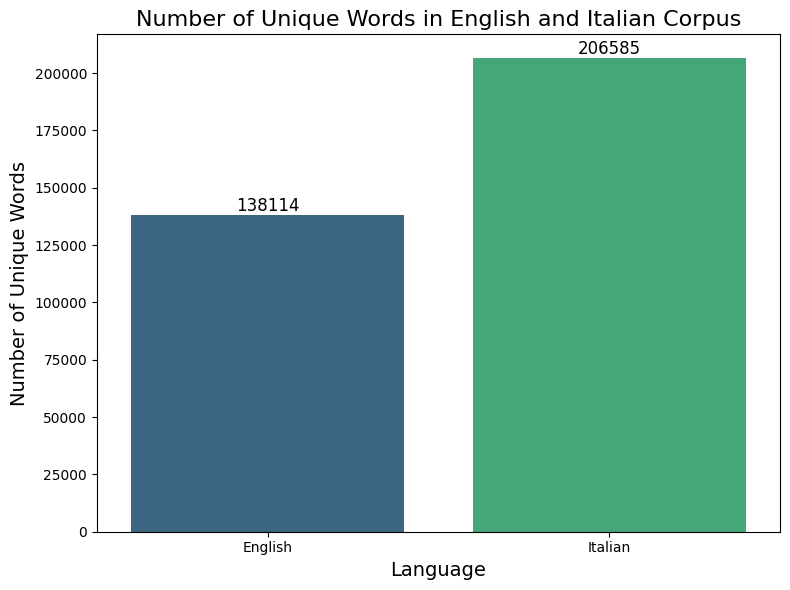

In [ ]:
plt.figure(figsize=(8, 6))
sns.barplot(x=['English', 'Italian'], y=[total_unique_english, total_unique_italian], palette="viridis")
plt.title('Number of Unique Words in English and Italian Corpus', fontsize=16)
plt.ylabel('Number of Unique Words', fontsize=14)
plt.xlabel('Language', fontsize=14)

for i, value in enumerate([total_unique_english, total_unique_italian]):
    plt.text(i, value + 100, str(value), ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.show()

In [ ]:
print(f"Number of unique words in English corpus: {total_unique_english}")
print(f"Number of unique words in Italian corpus: {total_unique_italian}")

Number of unique words in English corpus: 138114
Number of unique words in Italian corpus: 206585


### Analysis 3: Sentence Length Comparative analysis with proportions to check word alignment between languages(in which proportion the number of words in one language outweigh the other)

In [ ]:
df_eda['English_Longer'] = df_eda['English_Word_Count'] > df_eda['Italian_Word_Count']
df_eda['Italian_Longer'] = df_eda['Italian_Word_Count'] > df_eda['English_Word_Count']
df_eda['Lengths_Equal'] = df_eda['English_Word_Count'] == df_eda['Italian_Word_Count']

num_english_longer = df_eda['English_Longer'].sum()
num_italian_longer = df_eda['Italian_Longer'].sum()
num_lengths_equal = df_eda['Lengths_Equal'].sum()

In [ ]:
# Proportions
total_sentences = len(df_eda)
prop_english_longer = (num_english_longer / total_sentences) * 100
prop_italian_longer = (num_italian_longer / total_sentences) * 100
prop_lengths_equal = (num_lengths_equal / total_sentences) * 100

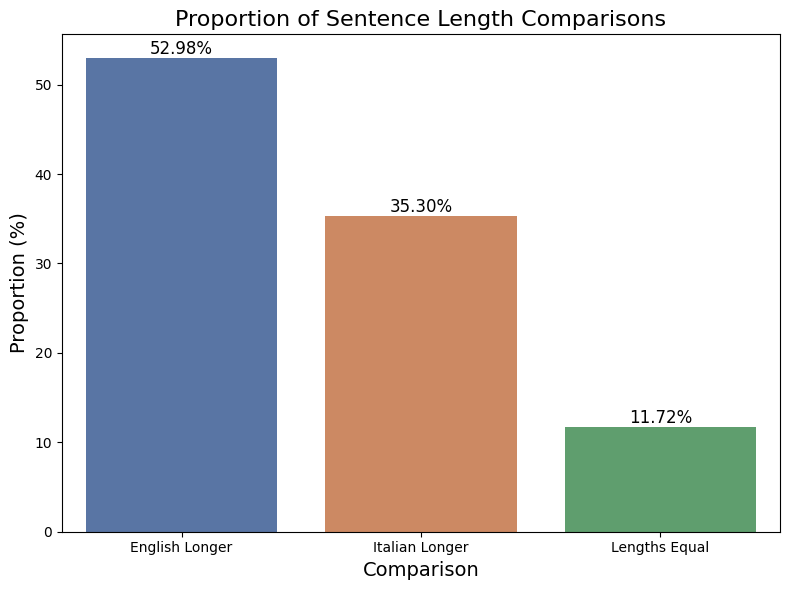

In [ ]:
plt.figure(figsize=(8, 6))
sns.barplot(x=['English Longer', 'Italian Longer', 'Lengths Equal'],
            y=[prop_english_longer, prop_italian_longer, prop_lengths_equal],
            palette=['#4C72B0', '#DD8452', '#55A868'])
plt.title('Proportion of Sentence Length Comparisons', fontsize=16)
plt.ylabel('Proportion (%)', fontsize=14)
plt.xlabel('Comparison', fontsize=14)

for i, value in enumerate([prop_english_longer, prop_italian_longer, prop_lengths_equal]):
    plt.text(i, value + 1, f"{value:.2f}%", ha='center', va='center', fontsize=12)

plt.tight_layout()
plt.show()


In [ ]:
print(f"Proportion of sentences where English version is longer: {prop_english_longer:.2f}%")
print(f"Proportion of sentences where Italian version is longer: {prop_italian_longer:.2f}%")
print(f"Proportion of sentences where lengths are equal: {prop_lengths_equal:.2f}%")

Proportion of sentences where English version is longer: 52.98%
Proportion of sentences where Italian version is longer: 35.30%
Proportion of sentences where lengths are equal: 11.72%


In [ ]:
nltk.download('stopwords')

# Defining stopwords for both languages
stop_words_english = set(stopwords.words('english'))
stop_words_italian = set(stopwords.words('italian'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### 4. Vocabulary Analysis: Word Frequency Distribution (after removing stopwords and punctuation)

In [ ]:
def word_frequency(text, stop_words):
    words = text.split()
    # Remove punctuation and stop words
    filtered_words = [word.strip(string.punctuation).lower() for word in words if word.lower() not in stop_words and word.strip(string.punctuation)]
    return Counter(filtered_words)

english_word_freq = word_frequency(' '.join(df_eda['English']), stop_words_english)
italian_word_freq = word_frequency(' '.join(df_eda['Italian']), stop_words_italian)

english_word_freq_df = pd.DataFrame(english_word_freq.items(), columns=['Word', 'Frequency']).sort_values(by='Frequency', ascending=False).head(10)
italian_word_freq_df = pd.DataFrame(italian_word_freq.items(), columns=['Word', 'Frequency']).sort_values(by='Frequency', ascending=False).head(10)

In [ ]:
english_word_freq_df

,Word,Frequency
7,european,61155
41,mr,37855
53,would,34941
92,also,34924
57,commission,32174
530,must,30605
42,president,26375
332,states,25441
8,union,25271
474,member,24462


In [ ]:
italian_word_freq_df

,Word,Frequency
62,commissione,45669
53,europea,38675
259,stati,32081
45,presidente,30974
80,essere,27720
268,parlamento,26515
35,signor,23021
256,relazione,22177
430,consiglio,21845
529,membri,21722


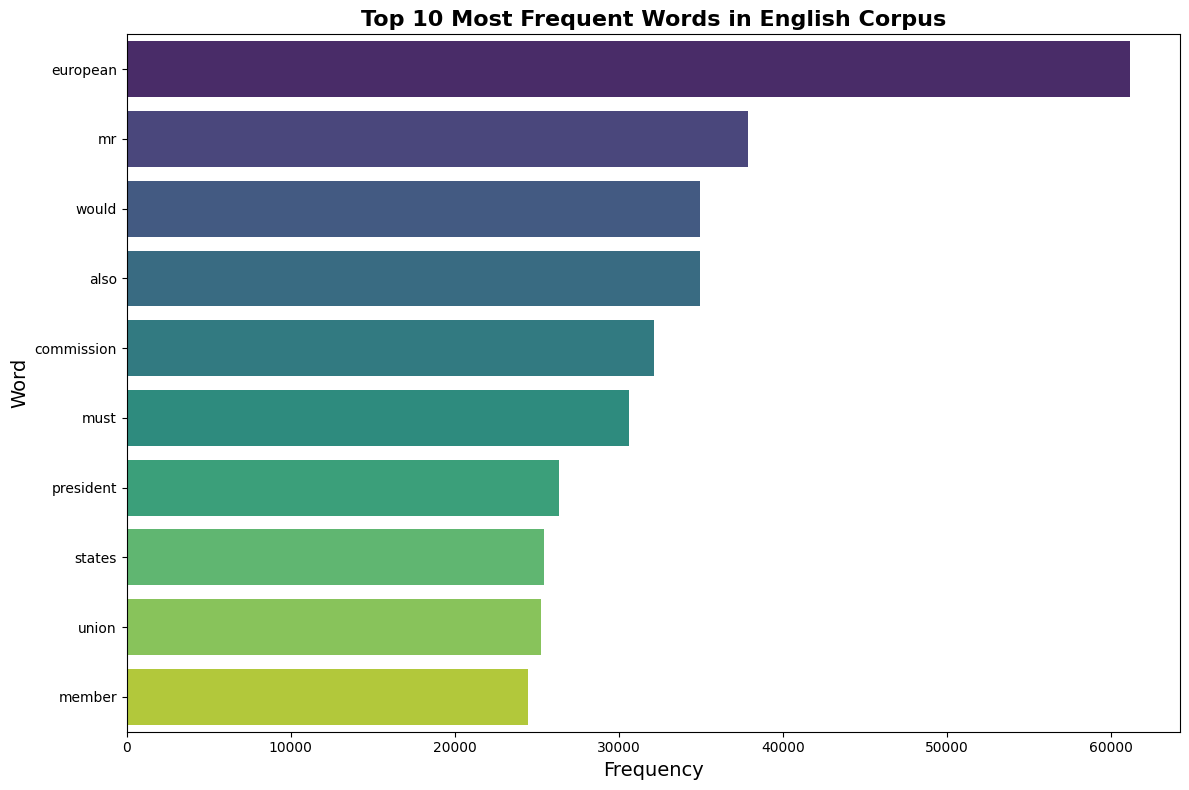

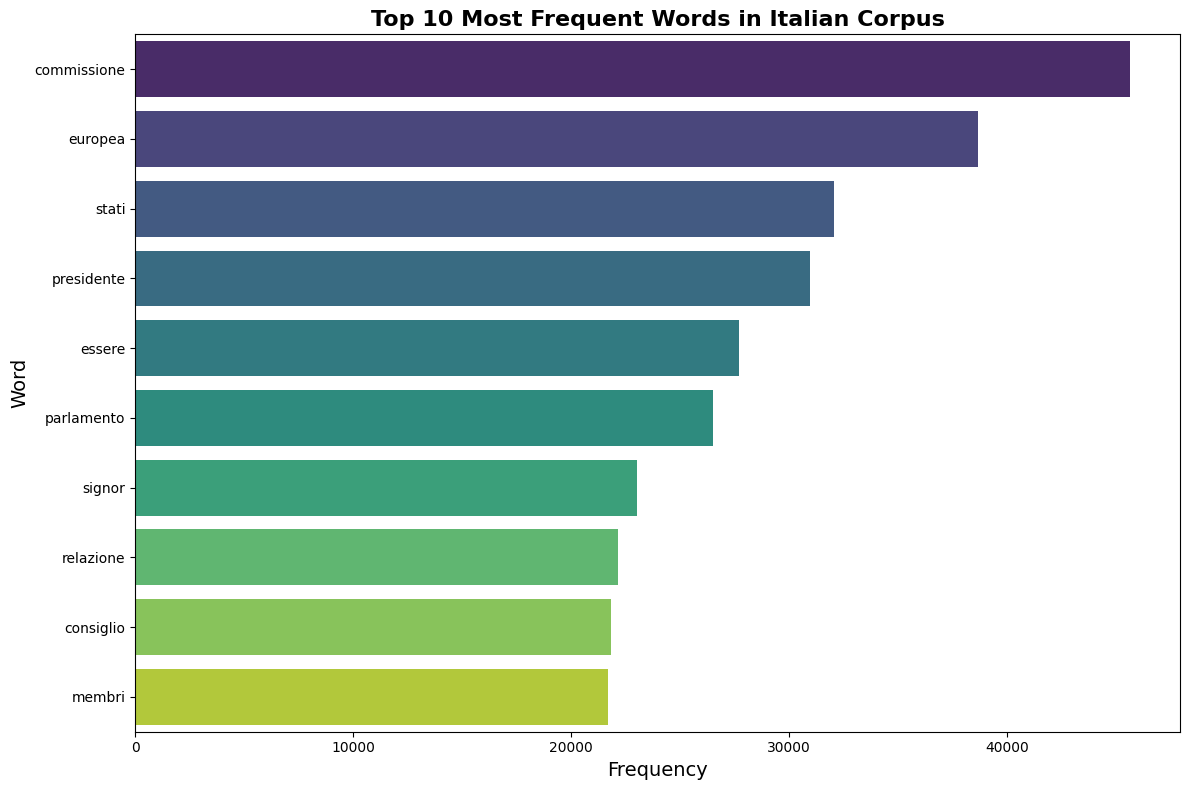

In [ ]:
custom_palette = sns.color_palette("viridis", 10)

#for english
plt.figure(figsize=(12, 8))
sns.barplot(x='Frequency', y='Word', data=english_word_freq_df, palette=custom_palette)
plt.title('Top 10 Most Frequent Words in English Corpus', fontsize=16, weight='bold')
plt.xlabel('Frequency', fontsize=14)
plt.ylabel('Word', fontsize=14)
plt.tight_layout()
plt.show()

#for italian
plt.figure(figsize=(12, 8))
sns.barplot(x='Frequency', y='Word', data=italian_word_freq_df, palette=custom_palette)
plt.title('Top 10 Most Frequent Words in Italian Corpus', fontsize=16, weight='bold')
plt.xlabel('Frequency', fontsize=14)
plt.ylabel('Word', fontsize=14)
plt.tight_layout()
plt.show()

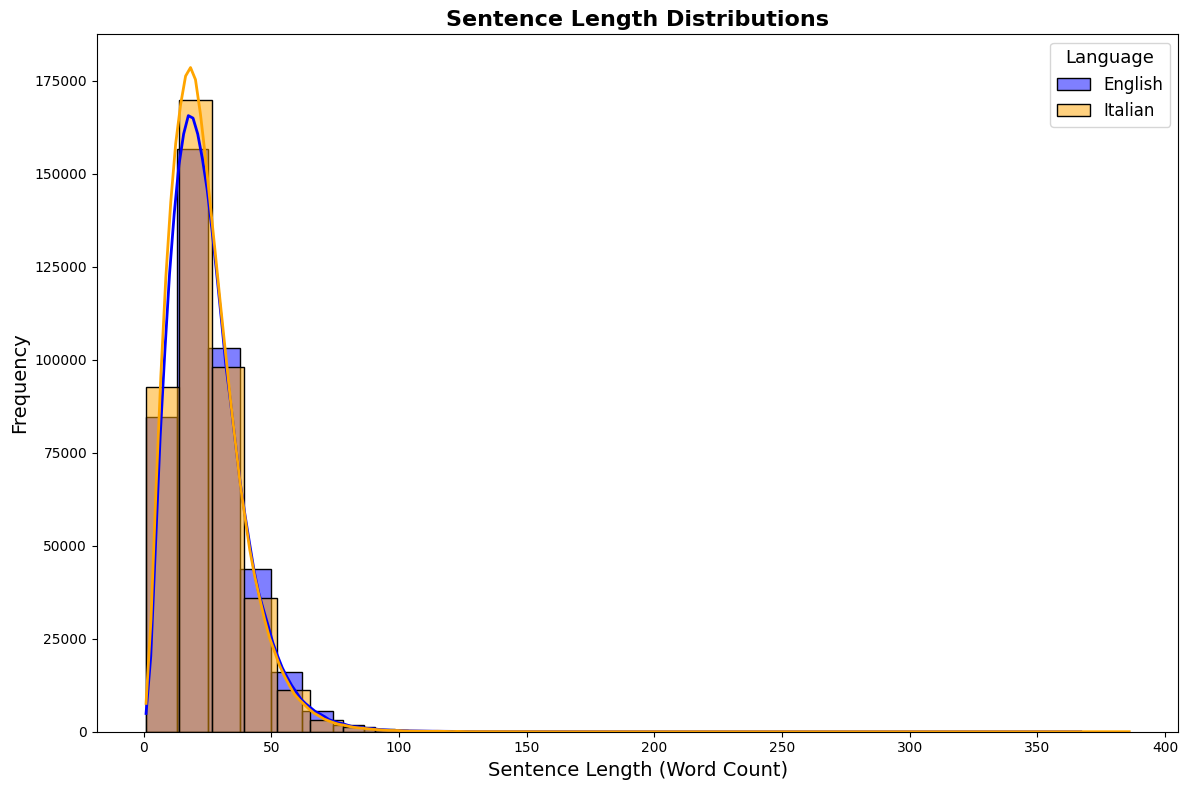

In [ ]:
#Sentence Length comparison again but with histograms to observe and compare heavy-tailed distributions, outliers
plt.figure(figsize=(12, 8))
sns.histplot(df_eda['English_Word_Count'], bins=30, kde=True, color='blue', label='English',
             line_kws={'color': 'darkblue', 'linewidth': 2})
sns.histplot(df_eda['Italian_Word_Count'], bins=30, kde=True, color='orange', label='Italian',
             line_kws={'color': 'darkorange', 'linewidth': 2})
plt.title('Sentence Length Distributions', fontsize=16, weight='bold')
plt.xlabel('Sentence Length (Word Count)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.legend(title='Language', title_fontsize='13', fontsize='12')
plt.tight_layout()
plt.show()

### 5. Average Word Length Comparison

In [ ]:
def avg_word_length(text):
    words = text.split()
    if len(words) > 0:
        return sum(len(word) for word in words) / len(words)
    return 0

df_eda['English_Avg_Word_Length'] = df_eda['English'].apply(avg_word_length)
df_eda['Italian_Avg_Word_Length'] = df_eda['Italian'].apply(avg_word_length)

avg_word_length_english = df_eda['English_Avg_Word_Length'].mean()
avg_word_length_italian = df_eda['Italian_Avg_Word_Length'].mean()

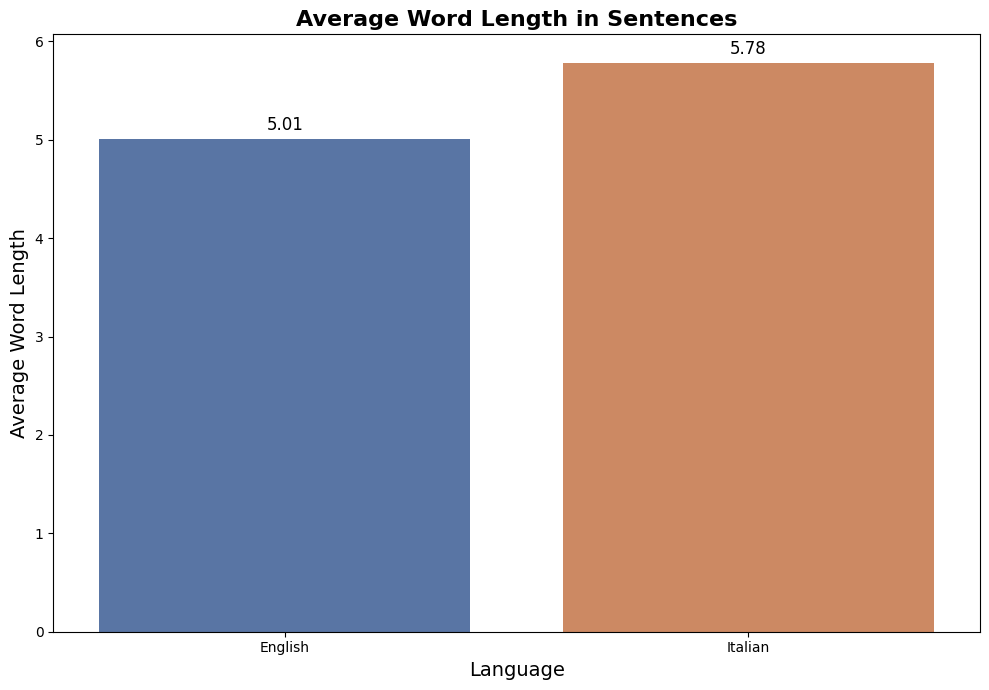

In [ ]:
plt.figure(figsize=(10, 7))
sns.barplot(x=['English', 'Italian'], y=[avg_word_length_english, avg_word_length_italian], palette=['#4C72B0', '#DD8452'])

plt.title('Average Word Length in Sentences', fontsize=16, weight='bold')
plt.ylabel('Average Word Length', fontsize=14)
plt.xlabel('Language', fontsize=14)

for i, value in enumerate([avg_word_length_english, avg_word_length_italian]):
    plt.text(i, value + 0.05, f"{value:.2f}", ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.show()

In [ ]:
print(f"Average word length in English sentences: {avg_word_length_english}")
print(f"Average word length in Italian sentences: {avg_word_length_italian}")

Average word length in English sentences: 5.006262597321054
Average word length in Italian sentences: 5.782115419861472


# Preprocessing

In [ ]:
# expanding the decontractions function
def decontractions(phrase):
    """Decontracted takes text and convert contractions into natural form."""
    # specific
    phrase = re.sub(r"won\'t|won\’t", "will not", phrase)
    phrase = re.sub(r"can\'t|can\’t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t|n\’t", " not", phrase)
    phrase = re.sub(r"\'re|\’re", " are", phrase)
    phrase = re.sub(r"\'s|\’s", " is", phrase)
    phrase = re.sub(r"\'d|\’d", " would", phrase)
    phrase = re.sub(r"\'ll|\’ll", " will", phrase)
    phrase = re.sub(r"\'t|\’t", " not", phrase)
    phrase = re.sub(r"\'ve|\’ve", " have", phrase)
    phrase = re.sub(r"\'m|\’m", " am", phrase)

    return phrase

In [ ]:
#  preprocessing for English
def preprocess_english(text):
    text = text.lower()
    text = decontractions(text)
    text = re.sub('[^A-Za-z0-9 ]+', ' ', text)
    text = re.sub(' +', ' ', text)
    text = text.split()
    return ' '.join(text)

#   preprocessing for Italian
def preprocess_italian(text):
    text = text.lower()
    text = re.sub('dr, ' ', text)
    text = re.sub(' +', ' ', text)
    text = re.sub('–', ' ', text)
    text = text.split()
    return ' '.join(text)

In [ ]:
# Function to remove lines with XML tags and empty lines
def filter_lines(english, italian):
    # Check if the English text starts with an XML tag (starts with '<')
    if english.startswith('<') or italian.startswith('<'):
        return False

    # Check if the English text is empty or contains only whitespace
    if not english.strip() or not italian.strip():
        return False
    # If the above conditions are not met, include this pair
    return True

In [ ]:
# Apply preprocessing to both columns
df['English'] = df['English'].apply(preprocess_english)
df['Italian'] = df['Italian'].apply(preprocess_italian)

In [ ]:
df.head()

,English,Italian
0,we can finally say that we have come up with a...,finalmente possiamo dirci soddisfati del docum...
1,we have adjusted this with the criteria of fle...,ci siamo regolati sulla base del criterio di f...
2,thank you minister for your first response dur...,grazie signor ministro per la sua prima rispos...
3,the vote will be taken tomorrow at 11 30 a m,la votazione si svolgerà domani alle 11 30
4,mr president i was interested to hear mr tanno...,signor presidente ho ascoltato con interesse l...


In [ ]:
filtered_df = df[df.apply(lambda x: filter_lines(x['English'], x['Italian']), axis=1)]

In [ ]:
filtered_df.head()

,English,Italian
0,we can finally say that we have come up with a...,finalmente possiamo dirci soddisfati del docum...
1,we have adjusted this with the criteria of fle...,ci siamo regolati sulla base del criterio di f...
2,thank you minister for your first response dur...,grazie signor ministro per la sua prima rispos...
3,the vote will be taken tomorrow at 11 30 a m,la votazione si svolgerà domani alle 11 30
4,mr president i was interested to hear mr tanno...,signor presidente ho ascoltato con interesse l...


In [ ]:
filtered_df.reset_index(drop=True, inplace=True)
filtered_df.shape
#df.shape

(412478, 2)

In [ ]:
# Keeping only 200000 instances due to computational limit
filtered_df = filtered_df.head(200000)
print(filtered_df.shape)

(200000, 2)


In [ ]:
# Add lengths of sentences for filtering
filtered_df['English_Word_Count'] = filtered_df['English'].apply(lambda x: len(x.split()))
filtered_df['Italian_Word_Count'] = filtered_df['Italian'].apply(lambda x: len(x.split()))

In [ ]:
for i in range(0,101,10):
    print("{}th Percentile value of english length {}".format(i,np.percentile(filtered_df['English_Word_Count'], i)))
print("*"*50)
for i in range(90,101):
    print("{}th Percentile value of length {}".format(i,np.percentile(filtered_df['English_Word_Count'], i)))
print("*"*50)
for i in [99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100]:
    print("{}th Percentile value of length {}".format(i,np.percentile(filtered_df['English_Word_Count'], i)))

0th Percentile value of english length 1.0
10th Percentile value of english length 10.0
20th Percentile value of english length 13.0
30th Percentile value of english length 17.0
40th Percentile value of english length 20.0
50th Percentile value of english length 23.0
60th Percentile value of english length 26.0
70th Percentile value of english length 30.0
80th Percentile value of english length 35.0
90th Percentile value of english length 44.0
100th Percentile value of english length 233.0
**************************************************
90th Percentile value of length 44.0
91th Percentile value of length 45.0
92th Percentile value of length 46.0
93th Percentile value of length 48.0
94th Percentile value of length 49.0
95th Percentile value of length 51.0
96th Percentile value of length 54.0
97th Percentile value of length 57.0
98th Percentile value of length 62.0
99th Percentile value of length 70.0
100th Percentile value of length 233.0
*********************************************

In [ ]:
for i in range(0,101,10):
    print("{}th Percentile value of italian length {}".format(i,np.percentile(filtered_df['Italian_Word_Count'], i)))
print("*"*50)
for i in range(90,101):
    print("{}th Percentile value of length {}".format(i,np.percentile(filtered_df['Italian_Word_Count'], i)))
print("*"*50)
for i in [99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100]:
    print("{}th Percentile value of length {}".format(i,np.percentile(filtered_df['Italian_Word_Count'], i)))

0th Percentile value of italian length 1.0
10th Percentile value of italian length 9.0
20th Percentile value of italian length 13.0
30th Percentile value of italian length 16.0
40th Percentile value of italian length 19.0
50th Percentile value of italian length 22.0
60th Percentile value of italian length 26.0
70th Percentile value of italian length 30.0
80th Percentile value of italian length 35.0
90th Percentile value of italian length 43.0
100th Percentile value of italian length 219.0
**************************************************
90th Percentile value of length 43.0
91th Percentile value of length 44.0
92th Percentile value of length 46.0
93th Percentile value of length 47.0
94th Percentile value of length 49.0
95th Percentile value of length 51.0
96th Percentile value of length 54.0
97th Percentile value of length 57.0
98th Percentile value of length 61.0
99th Percentile value of length 69.0
100th Percentile value of length 219.0
**********************************************

In [ ]:
# Filter out sentences longer than 70 words (99th percentile for both languages)
filtered_df = filtered_df[filtered_df['English_Word_Count'] <= 70]
filtered_df = filtered_df[filtered_df['Italian_Word_Count'] <= 70]

In [ ]:
filtered_df.shape

(197678, 2)

In [ ]:
# Add start and end tokens after filtering
filtered_df['English'] = filtered_df['English'].apply(lambda x: f"<start> {x} <end>")
filtered_df['Italian'] = filtered_df['Italian'].apply(lambda x: f"<start> {x} <end>")

In [ ]:
# Drop unnecessary columns
filtered_df = filtered_df.drop(['English_Word_Count', 'Italian_Word_Count'], axis=1)

In [ ]:
sampled_csv_file_path2= '/content/drive/My Drive/it-en/filtered_data_sent_before_split_25.csv'
#filtered_df.to_csv(sampled_csv_file_path2, index=False)

In [ ]:
filtered_df=pd.read_csv('/content/drive/My Drive/it-en/filtered_data_sent_before_split_25.csv')

In [ ]:
filtered_df.head()

,English,Italian
0,<start> we can finally say that we have come u...,<start> finalmente possiamo dirci soddisfati d...
1,<start> we have adjusted this with the criteri...,<start> ci siamo regolati sulla base del crite...
2,<start> thank you minister for your first resp...,<start> grazie signor ministro per la sua prim...
3,<start> the vote will be taken tomorrow at 11 ...,<start> la votazione si svolgerà domani alle 1...
4,<start> mr president i was interested to hear ...,<start> signor presidente ho ascoltato con int...


# English to Italian Translation Model

In [ ]:
# Word2Vec (English)
word2vec_model_eng = api.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [ ]:
embedding_dim = 300

In [ ]:
# GloVe (English)
def load_glove_embeddings(file_path):
    embeddings_index = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index

In [ ]:
glove_embeddings = load_glove_embeddings('/content/drive/My Drive/it-en/glove.6B.300d.txt')

In [ ]:
# Word2Vec (Italian)
word2vec_model_ita = KeyedVectors.load('/content/drive/My Drive/it-en/word2vec_italian/W2V.kv', mmap='r+')

In [ ]:
# FastText (English)
fasttext_model_eng = KeyedVectors.load_word2vec_format('/content/drive/My Drive/it-en/wiki-news-300d-1M.vec')

# FastText (Italian)
fasttext_model_ita = KeyedVectors.load_word2vec_format('/content/drive/My Drive/it-en/cc.it.300.vec')

In [ ]:
# Function to create embedding matrix
def create_embedding_matrix(tokenizer, embedding_model, vocab_size, embedding_dim):
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    for word, i in tokenizer.word_index.items():
        if i >= vocab_size:
            continue
        try:
            embedding_vector = embedding_model[word]
        except KeyError:
            embedding_vector = None
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

In [ ]:
train_val_df, test_df = train_test_split(filtered_df, test_size=0.2, random_state=121) #20% test data
train_df, val_df = train_test_split(train_val_df, test_size=0.25, random_state=542)

print(f"Train data shape = {train_df.shape}")
print(f"Validation data shape = {val_df.shape}")
print(f"Test data shape = {test_df.shape}")

Train data shape = (118606, 2)
Validation data shape = (39536, 2)
Test data shape = (39536, 2)


In [ ]:
filters = '!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n'

tokenizer_english = Tokenizer(num_words=None, filters=filters, oov_token='UNK')
tokenizer_english.fit_on_texts(train_df['English'])

tokenizer_italian = Tokenizer(num_words=None, filters=filters, oov_token='UNK')
tokenizer_italian.fit_on_texts(train_df['Italian'])

encoder_input_train = tokenizer_english.texts_to_sequences(train_df['English'])
encoder_input_val = tokenizer_english.texts_to_sequences(val_df['English'])
encoder_input_test = tokenizer_english.texts_to_sequences(test_df['English'])

decoder_tokenized_train = tokenizer_italian.texts_to_sequences(train_df['Italian'])
decoder_tokenized_val = tokenizer_italian.texts_to_sequences(val_df['Italian'])

In [ ]:
# Preparing data for decoder input and decoder output
decoder_input_train = [seq[:-1] for seq in decoder_tokenized_train]
decoder_input_val = [seq[:-1] for seq in decoder_tokenized_val]
decoder_output_train = [seq[1:] for seq in decoder_tokenized_train]
decoder_output_val = [seq[1:] for seq in decoder_tokenized_val]

# vocab sizes
english_vocab_size = len(tokenizer_english.word_index) + 1
italian_vocab_size = len(tokenizer_italian.word_index) + 1

In [ ]:
max_len = 70
#padding
encoder_train = pad_sequences(encoder_input_train, maxlen=max_len, padding='post', truncating='post')
encoder_val = pad_sequences(encoder_input_val, maxlen=max_len, padding='post', truncating='post')
encoder_test = pad_sequences(encoder_input_test, maxlen=max_len, padding='post', truncating='post')

decoder_input_train = pad_sequences(decoder_input_train, maxlen=max_len, padding='post', truncating='post')
decoder_input_val = pad_sequences(decoder_input_val, maxlen=max_len, padding='post', truncating='post')

decoder_output_train = pad_sequences(decoder_output_train, maxlen=max_len, padding='post', truncating='post')
decoder_output_val = pad_sequences(decoder_output_val, maxlen=max_len, padding='post', truncating='post')

In [ ]:
# Ensuring <end> token is at the end
def ensure_end_token(sequences, token_index):
    for seq in sequences:
        if token_index not in seq:
            seq[-1] = token_index

In [ ]:
ensure_end_token(encoder_train, tokenizer_english.word_index['<end>'])
ensure_end_token(encoder_val, tokenizer_english.word_index['<end>'])
ensure_end_token(encoder_test, tokenizer_english.word_index['<end>'])
ensure_end_token(decoder_output_train, tokenizer_italian.word_index['<end>'])
ensure_end_token(decoder_output_val, tokenizer_italian.word_index['<end>'])

In [ ]:
#examples for encoder input, decoder input and  output
print("=" * 50)
random_index_1 = np.random.randint(len(train_df))
random_index_2 = np.random.randint(len(train_df))
random_index_3 = np.random.randint(len(train_df))

print("Encoder Inputs\n")
print(" ".join([tokenizer_english.index_word.get(ele, '') for ele in encoder_train[random_index_1]]))
print(" ".join([tokenizer_english.index_word.get(ele, '') for ele in encoder_train[random_index_2]]))
print(" ".join([tokenizer_english.index_word.get(ele, '') for ele in encoder_train[random_index_3]]))

print("=" * 50)

print("Decoder Inputs\n")
print(" ".join([tokenizer_italian.index_word.get(ele, '') for ele in decoder_input_train[random_index_1]]))
print(" ".join([tokenizer_italian.index_word.get(ele, '') for ele in decoder_input_train[random_index_2]]))
print(" ".join([tokenizer_italian.index_word.get(ele, '') for ele in decoder_input_train[random_index_3]]))

print("=" * 50)

print("Decoder Outputs\n")
print(" ".join([tokenizer_italian.index_word.get(ele, '') for ele in decoder_output_train[random_index_1]]))
print(" ".join([tokenizer_italian.index_word.get(ele, '') for ele in decoder_output_train[random_index_2]]))
print(" ".join([tokenizer_italian.index_word.get(ele, '') for ele in decoder_output_train[random_index_3]]))

print("=" * 50)

Encoder Inputs

<start> there is also the question of whether the requirements of the european data protection directive can be adequately met <end>                                                 
<start> yesterday we had a link directly with people in syria who are saying that you have to strengthen the sanctions otherwise he will not stop <end>                                           
<start> i think i may say that every region in this european union has its own quite specific features and i am sure its own advantages <end>                                           
Decoder Inputs

<start> vi è inoltre la questione di soddisfare adeguatamente le richieste della direttiva europea sulla protezione dei dati                                                    
<start> ieri abbiamo avuto un collegamento diretto con cittadini siriani che dicono che occorre potenziare le sanzioni altrimenti non si fermerà                                                 
<start> ritengo che ogni regione de

In [ ]:
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout, TimeDistributed, Concatenate
class Encoder(tf.keras.Model):
    def __init__(self, inp_vocab_size, embedding_size, lstm_size, input_length, embedding_matrix):
        super().__init__()
        self.embedding = Embedding(inp_vocab_size, embedding_size, input_length=input_length, weights=[embedding_matrix], trainable=False)
        self.lstm = Bidirectional(LSTM(lstm_size, return_sequences=True, return_state=True))
        self.dropout = Dropout(0.3)

    def call(self, input_sequence, states):
        embeddings = self.embedding(input_sequence)
        embeddings = self.dropout(embeddings)
        enc_out, forward_h, forward_c, backward_h, backward_c = self.lstm(embeddings, initial_state=states)
        state_h = Concatenate()([forward_h, backward_h])
        state_c = Concatenate()([forward_c, backward_c])
        return enc_out, state_h, state_c

    def initialize_states(self, batch_size):
        lstm_units = self.lstm.forward_layer.units  #access units from forward layer
        return [tf.zeros((batch_size, lstm_units)), tf.zeros((batch_size, lstm_units)),
                tf.zeros((batch_size, lstm_units)), tf.zeros((batch_size, lstm_units))]

In [ ]:
class Decoder(tf.keras.Model):
    def __init__(self, out_vocab_size, embedding_size, lstm_size, input_length, embedding_matrix):
        super().__init__()
        self.embedding = Embedding(out_vocab_size, embedding_size, input_length=input_length, weights=[embedding_matrix], trainable=False)
        self.lstm = LSTM(lstm_size * 2, return_sequences=True, return_state=True)
        self.dropout = Dropout(0.5)
        self.dense = TimeDistributed(Dense(out_vocab_size, activation='softmax'))

    def call(self, input_sequence, initial_states):
        embeddings = self.embedding(input_sequence)
        embeddings = self.dropout(embeddings)
        dec_out, dec_h_state, dec_c_state = self.lstm(embeddings, initial_state=initial_states)
        dec_out = self.dense(dec_out)
        return dec_out, dec_h_state, dec_c_state

In [ ]:
class EncoderDecoder(tf.keras.Model):
    def __init__(self, english_vocab_size, italian_vocab_size, embedding_size, lstm_size, encoder_input_length, decoder_input_length, enc_embedding_matrix, dec_embedding_matrix):
        super().__init__()
        self.encoder = Encoder(inp_vocab_size=english_vocab_size, embedding_size=embedding_size, lstm_size=lstm_size, input_length=encoder_input_length, embedding_matrix=enc_embedding_matrix)
        self.decoder = Decoder(out_vocab_size=italian_vocab_size, embedding_size=embedding_size, lstm_size=lstm_size, input_length=decoder_input_length, embedding_matrix=dec_embedding_matrix)

    def call(self, inputs):
        encoder_input, decoder_input = inputs
        enc_initial_states = self.encoder.initialize_states(tf.shape(encoder_input)[0])
        enc_out, enc_h_state, enc_c_state = self.encoder(encoder_input, enc_initial_states)
        dec_out, dec_h_state, dec_c_state = self.decoder(decoder_input, initial_states=[enc_h_state, enc_c_state])
        return dec_out

In [ ]:
#function to generate batches (organizing data into batches of the specified size)
def data_generator(encoder_input, decoder_input, decoder_output, batch_size):
    while True:
        for i in range(0, len(encoder_input), batch_size):
            enc_inp_batch = np.zeros(shape=(batch_size, encoder_input.shape[-1]))
            dec_inp_batch = np.zeros(shape=(batch_size, decoder_input.shape[-1]))
            dec_out_batch = np.zeros(shape=(batch_size, decoder_output.shape[-1]))
            for j in range(batch_size):
                if (i + j) < len(encoder_input):
                    enc_inp_batch[j] = encoder_input[i + j]
                    dec_inp_batch[j] = decoder_input[i + j]
                    dec_out_batch[j] = decoder_output[i + j]
            yield [enc_inp_batch, dec_inp_batch], dec_out_batch

In [ ]:
def train_and_evaluate(embedding_matrix_eng, embedding_matrix_ita, embedding_name):
    embedding_dim = 300
    lstm_size = 256
    encoder_input_length = encoder_train.shape[1]
    decoder_input_length = decoder_input_train.shape[1]

    encoder_decoder_model = EncoderDecoder(
        english_vocab_size=english_vocab_size,
        italian_vocab_size=italian_vocab_size,
        embedding_size=embedding_dim,
        lstm_size=lstm_size,
        encoder_input_length=encoder_input_length,
        decoder_input_length=decoder_input_length,
        enc_embedding_matrix=embedding_matrix_eng,
        dec_embedding_matrix=embedding_matrix_ita
    )

    # Compile the model
    encoder_decoder_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.002), loss='sparse_categorical_crossentropy')

    callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.1, patience=2)]

    # Training the model
    batch_size = 64
    train_data_generator = data_generator(encoder_train, decoder_input_train, decoder_output_train, batch_size)
    val_data_generator = data_generator(encoder_val, decoder_input_val, decoder_output_val, batch_size)

    encoder_decoder_model.fit(train_data_generator, validation_data=val_data_generator, epochs=10, callbacks=callbacks,
                              steps_per_epoch=len(encoder_train) // batch_size, validation_steps=len(encoder_val) // batch_size)

    # Model summary
    encoder_decoder_model.summary()

    return encoder_decoder_model

In [ ]:
# Create embedding matrices
embedding_matrix_word2vec_eng = create_embedding_matrix(tokenizer_english, word2vec_model_eng, english_vocab_size, embedding_dim)
embedding_matrix_glove_eng = create_embedding_matrix(tokenizer_english, glove_embeddings, english_vocab_size, embedding_dim)
embedding_matrix_fasttext_eng = create_embedding_matrix(tokenizer_english, fasttext_model_eng, english_vocab_size, embedding_dim)

embedding_matrix_word2vec_ita = create_embedding_matrix(tokenizer_italian, word2vec_model_ita, italian_vocab_size, embedding_dim)
embedding_matrix_fasttext_ita = create_embedding_matrix(tokenizer_italian, fasttext_model_ita, italian_vocab_size, embedding_dim)

In [ ]:
# Train and evaluate with different embeddings
models = {}
models['word2vec'] = train_and_evaluate(embedding_matrix_word2vec_eng, embedding_matrix_word2vec_ita, 'word2vec')

Epoch 1/10
1853/1853 [==============================] - 586s 314ms/step - loss: 2.3128 - val_loss: 1.8519
Epoch 2/10
1853/1853 [==============================] - 583s 314ms/step - loss: 1.7708 - val_loss: 1.6682
Epoch 3/10
1853/1853 [==============================] - 583s 314ms/step - loss: 1.6191 - val_loss: 1.5892
Epoch 4/10
1853/1853 [==============================] - 583s 314ms/step - loss: 1.5266 - val_loss: 1.5480
Epoch 5/10
1853/1853 [==============================] - 582s 314ms/step - loss: 1.4593 - val_loss: 1.5210
Epoch 6/10
1853/1853 [==============================] - 582s 314ms/step - loss: 1.4054 - val_loss: 1.5067
Epoch 7/10
1853/1853 [==============================] - 582s 314ms/step - loss: 1.3620 - val_loss: 1.4962
Model: "encoder_decoder_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_7 (Encoder)         multiple                  10894336  
                                 

In [ ]:
models['glove'] = train_and_evaluate(embedding_matrix_glove_eng, embedding_matrix_word2vec_ita, 'glove')

Epoch 1/10
1853/1853 [==============================] - 587s 314ms/step - loss: 2.1869 - val_loss: 1.7553
Epoch 2/10
1853/1853 [==============================] - 583s 315ms/step - loss: 1.6842 - val_loss: 1.5952
Epoch 3/10
1853/1853 [==============================] - 583s 315ms/step - loss: 1.5374 - val_loss: 1.5254
Epoch 4/10
1853/1853 [==============================] - 583s 315ms/step - loss: 1.4444 - val_loss: 1.4904
Epoch 5/10
1853/1853 [==============================] - 583s 315ms/step - loss: 1.3779 - val_loss: 1.4747
Epoch 6/10
1853/1853 [==============================] - 583s 314ms/step - loss: 1.3265 - val_loss: 1.4646
Model: "encoder_decoder_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_8 (Encoder)         multiple                  10894336  
                                                                 
 decoder_8 (Decoder)         multiple                  45680031  
       

In [ ]:
models['fasttext'] = train_and_evaluate(embedding_matrix_fasttext_eng, embedding_matrix_fasttext_ita, 'fasttext')

Epoch 1/10
1853/1853 [==============================] - 587s 314ms/step - loss: 2.1799 - val_loss: 1.8388
Epoch 2/10
1853/1853 [==============================] - 583s 315ms/step - loss: 1.7589 - val_loss: 1.6592
Epoch 3/10
1853/1853 [==============================] - 583s 315ms/step - loss: 1.5914 - val_loss: 1.5787
Epoch 4/10
1853/1853 [==============================] - 583s 315ms/step - loss: 1.4862 - val_loss: 1.5290
Epoch 5/10
1853/1853 [==============================] - 583s 315ms/step - loss: 1.4031 - val_loss: 1.5020
Epoch 6/10
1853/1853 [==============================] - 583s 314ms/step - loss: 1.3392 - val_loss: 1.4864
Model: "encoder_decoder_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_9 (Encoder)         multiple                  10894336  
                                                                 
 decoder_9 (Decoder)         multiple                  45680031  
       

In [ ]:
def predict_sentence(input_sentence, model, tokenizer_input, tokenizer_output):
    # Tokenize the input sentence
    tokenized_encoder_input = tokenizer_input.texts_to_sequences([input_sentence])
    encoder_input = pad_sequences(tokenized_encoder_input, maxlen=70, padding='post')

    for ele in encoder_input:
        if tokenizer_input.word_index['<end>'] not in ele:
            ele[-1] = tokenizer_input.word_index['<end>']

    # Get initial encoder states
    enc_init_states = model.encoder.initialize_states(1)
    enc_out, enc_h_state, enc_c_state = model.encoder(encoder_input, states=enc_init_states)

    # Initialize decoder input with <start> token
    decoder_initial_states = [enc_h_state, enc_c_state]
    decoder_initial_input = np.zeros((1, 1))
    decoder_initial_input[0, 0] = tokenizer_output.word_index['<start>']

    predicted_words = []
    predicting = True
    while predicting:
        dec_out, dec_h_state, dec_c_state = model.decoder(decoder_initial_input, initial_states=decoder_initial_states)
        predicted_int = np.argmax(dec_out.numpy().ravel())
        predicted_words.append(predicted_int)
        decoder_initial_input[0, 0] = predicted_int
        decoder_initial_states = [dec_h_state, dec_c_state]

        if predicted_int == tokenizer_output.word_index['<end>'] or len(predicted_words) >= 70:
            break

    # Decode the sequence of predicted integers to words
    predicted_sentence = ' '.join([tokenizer_output.index_word.get(ele, '') for ele in predicted_words])
    return predicted_sentence

In [ ]:
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
# Evaluation on 1500 sample test set
sample_test_df = test_df.sample(1500, random_state=42)

In [ ]:
bleu_scores = {}
meteor_scores = {}

for emb in models:
    bleu_scores[emb] = []
    meteor_scores[emb] = []
    model = models[emb]

    print(f"\nEvaluating with {emb} embeddings...\n")

    for i, (index, row) in enumerate(sample_test_df.iterrows()):
        input_sent = row['English']
        predicted_ita = predict_sentence(input_sent, model, tokenizer_english, tokenizer_italian)
        actual_ita = row['Italian'].replace('<start>', '').replace('<end>', '').strip()
        actual_ita += ' <end>'

        # Calculate BLEU score
        bleu_scores[emb].append(sentence_bleu([actual_ita.split()], predicted_ita.split()))
        actual_ita_tokens = actual_ita.split()
        predicted_ita_tokens = predicted_ita.split()
        meteor_scores[emb].append(meteor_score([actual_ita_tokens], predicted_ita_tokens))

        # Print some sample predictions
        if i % 500 == 0:
            print("=" * 50)
            print(f"English sentence: {row['English'].strip()}")
            print(f"Actual Translation: {actual_ita}")
            print(f"Predicted Translation: {predicted_ita}")
            print("=" * 50)

# average scores
for emb in models:
    print(f"Average BLEU score for {emb}: {np.mean(bleu_scores[emb])}")
    print(f"Average METEOR score for {emb}: {np.mean(meteor_scores[emb])}")



Evaluating with word2vec embeddings...

English sentence: <start> the fear of the stigma attached to a positive test result can prevent patients from accessing early screening <end>
Actual Translation: il timore di essere stigmatizzati in caso di risultato positivo potrebbe dissuadere i pazienti dal ricorrere allo screening precoce <end>
Predicted Translation: il rischio di cancro è stato possibile ottenere informazioni attendibili per la terapia precoce e la terapia precoce <end>
English sentence: <start> the treaty of nice has failed to be adopted <end>
Actual Translation: il trattato di nizza è decaduto <end>
Predicted Translation: la direttiva europea non ha trattato di nizza <end>
English sentence: <start> i welcome its references to the need for respect of international legality and for relevant international covenants of human rights the respect of women is rights and all minorities in the country and the condemnation of the violations of prisoner is rights in abu grahib prison

In [ ]:
#  save the results
results = []
for emb in models:
    avg_bleu = np.mean(bleu_scores[emb])
    avg_meteor = np.mean(meteor_scores[emb])
    results.append({
        'Embedding': emb,
        'Average BLEU Score': avg_bleu,
        'Average METEOR Score': avg_meteor
    })
    print(f"Average BLEU score for {emb}: {avg_bleu}")
    print(f"Average METEOR score for {emb}: {avg_meteor}")

results_df = pd.DataFrame(results)
results_save_path = '/content/drive/My Drive/it-en/results/embedding_evaluation_results2.csv'
results_df.to_csv(results_save_path, index=False)

Average BLEU score for word2vec: 0.011096739475034085
Average METEOR score for word2vec: 0.17139014730955132
Average BLEU score for glove: 0.01147359051721853
Average METEOR score for glove: 0.17856793800832044
Average BLEU score for fasttext: 0.01361537282486438
Average METEOR score for fasttext: 0.18764027184466564


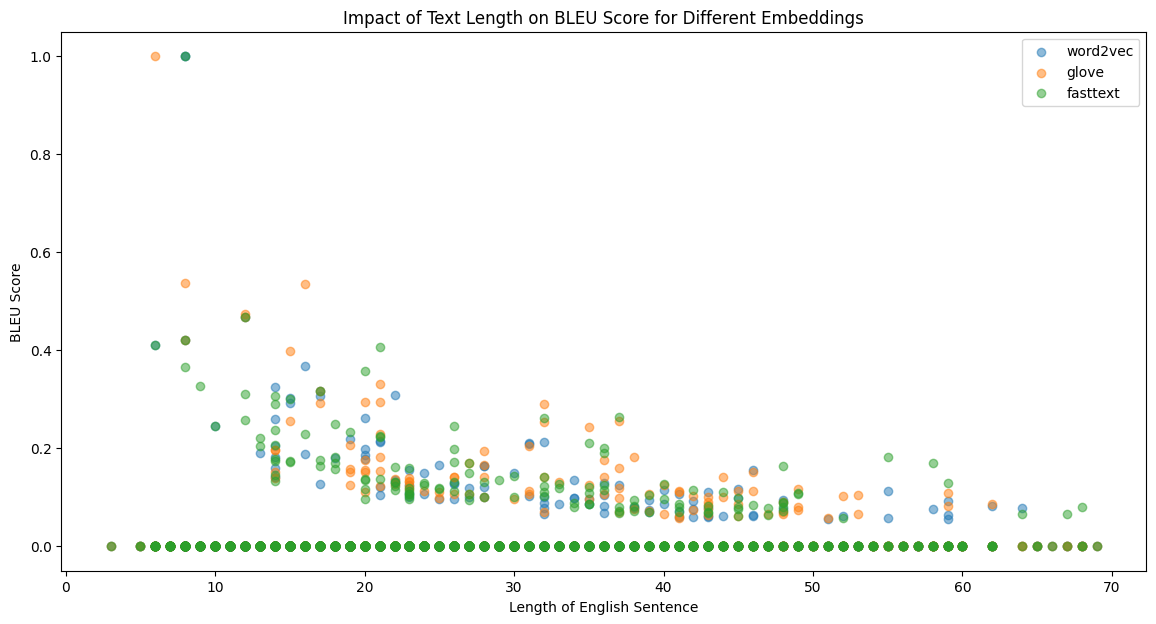

In [ ]:
# Analysis of text length impact on performance
lengths = []
bleu_scores_length = {emb: [] for emb in models}

for row in sample_test_df.itertuples():
    lengths.append(len(row.English.split()))
    for emb in models:
        bleu_scores_length[emb].append(bleu_scores[emb][len(lengths) - 1])

plt.figure(figsize=(14, 7))
for emb in models:
    plt.scatter(lengths, bleu_scores_length[emb], alpha=0.5, label=emb)
plt.xlabel('Length of English Sentence')
plt.ylabel('BLEU Score')
plt.legend()
plt.title('Impact of Text Length on BLEU Score for Different Embeddings')
plt.show()

inverse relationship between length of text and the BLEU score. As the length increases, the BLEU scores for longer sentences gets lower.

# Italian to English Translation Model

In [ ]:
filters = '!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n'

tokenizer_italian = Tokenizer(num_words=None, filters=filters, oov_token='UNK')
tokenizer_italian.fit_on_texts(train_df['Italian'])

tokenizer_english = Tokenizer(num_words=None, filters=filters, oov_token='UNK')
tokenizer_english.fit_on_texts(train_df['English'])

#encoder for italian, decoder for english
encoder_input_train = tokenizer_italian.texts_to_sequences(train_df['Italian'])
encoder_input_val = tokenizer_italian.texts_to_sequences(val_df['Italian'])
encoder_input_test = tokenizer_italian.texts_to_sequences(test_df['Italian'])

decoder_tokenized_train = tokenizer_english.texts_to_sequences(train_df['English'])
decoder_tokenized_val = tokenizer_english.texts_to_sequences(val_df['English'])
decoder_input_train = [seq[:-1] for seq in decoder_tokenized_train]
decoder_input_val = [seq[:-1] for seq in decoder_tokenized_val]
decoder_output_train = [seq[1:] for seq in decoder_tokenized_train]
decoder_output_val = [seq[1:] for seq in decoder_tokenized_val]

In [ ]:
# Vocabulary sizes
italian_vocab_size = len(tokenizer_italian.word_index) + 1
english_vocab_size = len(tokenizer_english.word_index) + 1

In [ ]:
print(italian_vocab_size, english_vocab_size)

54139 32512


In [ ]:
max_len = 70

encoder_train = pad_sequences(encoder_input_train, maxlen=max_len, padding='post', truncating='post')
encoder_val = pad_sequences(encoder_input_val, maxlen=max_len, padding='post', truncating='post')
encoder_test = pad_sequences(encoder_input_test, maxlen=max_len, padding='post', truncating='post')

decoder_input_train = pad_sequences(decoder_input_train, maxlen=max_len, padding='post', truncating='post')
decoder_input_val = pad_sequences(decoder_input_val, maxlen=max_len, padding='post', truncating='post')

decoder_output_train = pad_sequences(decoder_output_train, maxlen=max_len, padding='post', truncating='post')
decoder_output_val = pad_sequences(decoder_output_val, maxlen=max_len, padding='post', truncating='post')

In [ ]:
ensure_end_token(encoder_train, tokenizer_italian.word_index['<end>'])
ensure_end_token(encoder_val, tokenizer_italian.word_index['<end>'])
ensure_end_token(encoder_test, tokenizer_italian.word_index['<end>'])
ensure_end_token(decoder_output_train, tokenizer_english.word_index['<end>'])
ensure_end_token(decoder_output_val, tokenizer_english.word_index['<end>'])

In [ ]:
# Sample pre-processed data
print("=" * 50)
random_index_1 = np.random.randint(len(train_df))
random_index_2 = np.random.randint(len(train_df))
random_index_3 = np.random.randint(len(train_df))

print("Encoder Inputs\n")
print(" ".join([tokenizer_italian.index_word.get(ele, '') for ele in encoder_train[random_index_1]]))
print(" ".join([tokenizer_italian.index_word.get(ele, '') for ele in encoder_train[random_index_2]]))
print(" ".join([tokenizer_italian.index_word.get(ele, '') for ele in encoder_train[random_index_3]]))

print("=" * 50)

print("Decoder Inputs\n")
print(" ".join([tokenizer_english.index_word.get(ele, '') for ele in decoder_input_train[random_index_1]]))
print(" ".join([tokenizer_english.index_word.get(ele, '') for ele in decoder_input_train[random_index_2]]))
print(" ".join([tokenizer_english.index_word.get(ele, '') for ele in decoder_input_train[random_index_3]]))

print("=" * 50)

print("Decoder Outputs\n")
print(" ".join([tokenizer_english.index_word.get(ele, '') for ele in decoder_output_train[random_index_1]]))
print(" ".join([tokenizer_english.index_word.get(ele, '') for ele in decoder_output_train[random_index_2]]))
print(" ".join([tokenizer_english.index_word.get(ele, '') for ele in decoder_output_train[random_index_3]]))

print("=" * 50)


Encoder Inputs

<start> nel dibattito sulla direttiva ho trovato assolutamente scandaloso il tentativo di impedire qualsiasi soluzione che potesse comportare delle spese <end>                                                 
<start> e altresì vero comunque che il caso eurostat è anche servito da incentivo per certe importanti riforme avviate dalla commissione comprendenti l individuazione di alcune delle mancanze che esistevano come i rapporti tra i direttori generali e i commissari che si è notevolmente rafforzato nella terza relazione della commissione sui progressi della riforma e riguardo ai quali dobbiamo attenderci ulteriori sostanziali miglioramenti <end>      
<start> da allora i colloqui sullo status del nagorno karabakh si sono arenati <end>                                                        
Decoder Inputs

<start> what i found really scandalous about the debate on this directive was the attempt that was made to prevent anything that might cost money                     

In [ ]:
# Train and evaluate with different embeddings for Italian to English translation
models_ita_to_eng = {}
models_ita_to_eng['word2vec'] = train_and_evaluate(embedding_matrix_word2vec_ita, embedding_matrix_word2vec_eng, 'word2vec_ita_to_eng')

Epoch 1/10
1853/1853 [==============================] - 583s 311ms/step - loss: 2.1695 - val_loss: 1.9105
Epoch 2/10
1853/1853 [==============================] - 579s 312ms/step - loss: 1.8527 - val_loss: 1.7750
Epoch 3/10
1853/1853 [==============================] - 579s 313ms/step - loss: 1.7356 - val_loss: 1.7117
Epoch 4/10
1853/1853 [==============================] - 579s 313ms/step - loss: 1.6605 - val_loss: 1.6773
Model: "encoder_decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Encoder)           multiple                  10894336  
                                                                 
 decoder (Decoder)           multiple                  45680031  
                                                                 
Total params: 56574367 (215.81 MB)
Trainable params: 30579067 (116.65 MB)
Non-trainable params: 25995300 (99.16 MB)
_______________________________________

In [ ]:
models_ita_to_eng['glove'] = train_and_evaluate(embedding_matrix_fasttext_ita, embedding_matrix_glove_eng, 'glove_ita_to_eng')

Epoch 1/10
1853/1853 [==============================] - 581s 311ms/step - loss: 2.3380 - val_loss: 2.0003
Epoch 2/10
1853/1853 [==============================] - 579s 313ms/step - loss: 1.9261 - val_loss: 1.8500
Epoch 3/10
1853/1853 [==============================] - 579s 313ms/step - loss: 1.7971 - val_loss: 1.7618
Epoch 4/10
1853/1853 [==============================] - 580s 313ms/step - loss: 1.7066 - val_loss: 1.7110
Epoch 5/10
1853/1853 [==============================] - 579s 313ms/step - loss: 1.6369 - val_loss: 1.6781
Epoch 6/10
1853/1853 [==============================] - 578s 312ms/step - loss: 1.5812 - val_loss: 1.6587
Model: "encoder_decoder_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_1 (Encoder)         multiple                  10894336  
                                                                 
 decoder_1 (Decoder)         multiple                  45680031  
       

In [ ]:
models_ita_to_eng['fasttext'] = train_and_evaluate(embedding_matrix_fasttext_ita, embedding_matrix_fasttext_eng, 'fasttext_ita_to_eng')

Epoch 1/10
1853/1853 [==============================] - 583s 313ms/step - loss: 2.2036 - val_loss: 1.9645
Epoch 2/10
1853/1853 [==============================] - 579s 313ms/step - loss: 1.9011 - val_loss: 1.8400
Epoch 3/10
1853/1853 [==============================] - 580s 313ms/step - loss: 1.7806 - val_loss: 1.7634
Epoch 4/10
1853/1853 [==============================] - 580s 313ms/step - loss: 1.6921 - val_loss: 1.7166
Epoch 5/10
1853/1853 [==============================] - 580s 313ms/step - loss: 1.6242 - val_loss: 1.6907
Epoch 6/10
1853/1853 [==============================] - 579s 312ms/step - loss: 1.5710 - val_loss: 1.6705
Model: "encoder_decoder_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_2 (Encoder)         multiple                  10894336  
                                                                 
 decoder_2 (Decoder)         multiple                  45680031  
       

In [ ]:
bleu_scores_ita_to_eng = {}
meteor_scores_ita_to_eng = {}

for emb in models_ita_to_eng:
    bleu_scores_ita_to_eng[emb] = []
    meteor_scores_ita_to_eng[emb] = []
    model = models_ita_to_eng[emb]

    print(f"\nEvaluating with {emb} embeddings...\n")

    for i, (index, row) in enumerate(sample_test_df.iterrows()):
        input_sent = row['Italian']
        predicted_eng = predict_sentence(input_sent, model, tokenizer_italian, tokenizer_english)
        actual_eng = row['English'].replace('<start>', '').replace('<end>', '').strip()
        actual_eng += ' <end>'

        # Calculate BLEU score
        bleu_scores_ita_to_eng[emb].append(sentence_bleu([actual_eng.split()], predicted_eng.split()))

        # Tokenize the sentences for METEOR score
        actual_eng_tokens = actual_eng.split()
        predicted_eng_tokens = predicted_eng.split()

        meteor_scores_ita_to_eng[emb].append(meteor_score([actual_eng_tokens], predicted_eng_tokens))

        # Print some sample predictions
        if i % 500 == 0:
            print("=" * 50)
            print(f"Italian sentence: {row['Italian'].strip()}")
            print(f"Actual Translation: {actual_eng}")
            print(f"Predicted Translation: {predicted_eng}")
            print("=" * 50)



Evaluating with word2vec embeddings...

Italian sentence: <start> il timore di essere stigmatizzati in caso di risultato positivo potrebbe dissuadere i pazienti dal ricorrere allo screening precoce <end>
Actual Translation: the fear of the stigma attached to a positive test result can prevent patients from accessing early screening <end>
Predicted Translation: the only way to be used to be able to prevent the number of the and the of the world bank <end>
Italian sentence: <start> il trattato di nizza è decaduto <end>
Actual Translation: the treaty of nice has failed to be adopted <end>
Predicted Translation: the treaty of lisbon is a fundamental <end>
Italian sentence: <start> accolgo con soddisfazione i riferimenti del documento alla necessità di rispettare la legalità internazionale e le convenzioni relative ai diritti umani al rispetto nel paese dei diritti delle donne e di tutte le minoranze nonché alla condanna delle violazioni dei diritti dei prigionieri nel carcere di abu ghrai

In [ ]:
# Calculate average scores
for emb in models_ita_to_eng:
    print(f"Average BLEU score for {emb}: {np.mean(bleu_scores_ita_to_eng[emb])}")
    print(f"Average METEOR score for {emb}: {np.mean(meteor_scores_ita_to_eng[emb])}")

# Calculate average scores and save the results
results = []
for emb in models_ita_to_eng:
    avg_bleu = np.mean(bleu_scores_ita_to_eng[emb])
    avg_meteor = np.mean(meteor_scores_ita_to_eng[emb])
    results.append({
        'Embedding': emb,
        'Average BLEU Score': avg_bleu,
        'Average METEOR Score': avg_meteor
    })
    print(f"Average BLEU score for {emb}: {avg_bleu}")
    print(f"Average METEOR score for {emb}: {avg_meteor}")

Average BLEU score for word2vec: 0.010686809861206098
Average METEOR score for word2vec: 0.19444135155071837
Average BLEU score for glove: 0.019939272634466106
Average METEOR score for glove: 0.22359281003145798
Average BLEU score for fasttext: 0.020420418717572657
Average METEOR score for fasttext: 0.22234551024707863
Average BLEU score for word2vec: 0.010686809861206098
Average METEOR score for word2vec: 0.19444135155071837
Average BLEU score for glove: 0.019939272634466106
Average METEOR score for glove: 0.22359281003145798
Average BLEU score for fasttext: 0.020420418717572657
Average METEOR score for fasttext: 0.22234551024707863


In [ ]:
# saving results to drive
results_df = pd.DataFrame(results)
results_save_path = '/content/drive/My Drive/it-en/results/embedding_evaluation_results_ita_to_eng2.csv'
results_df.to_csv(results_save_path, index=False)

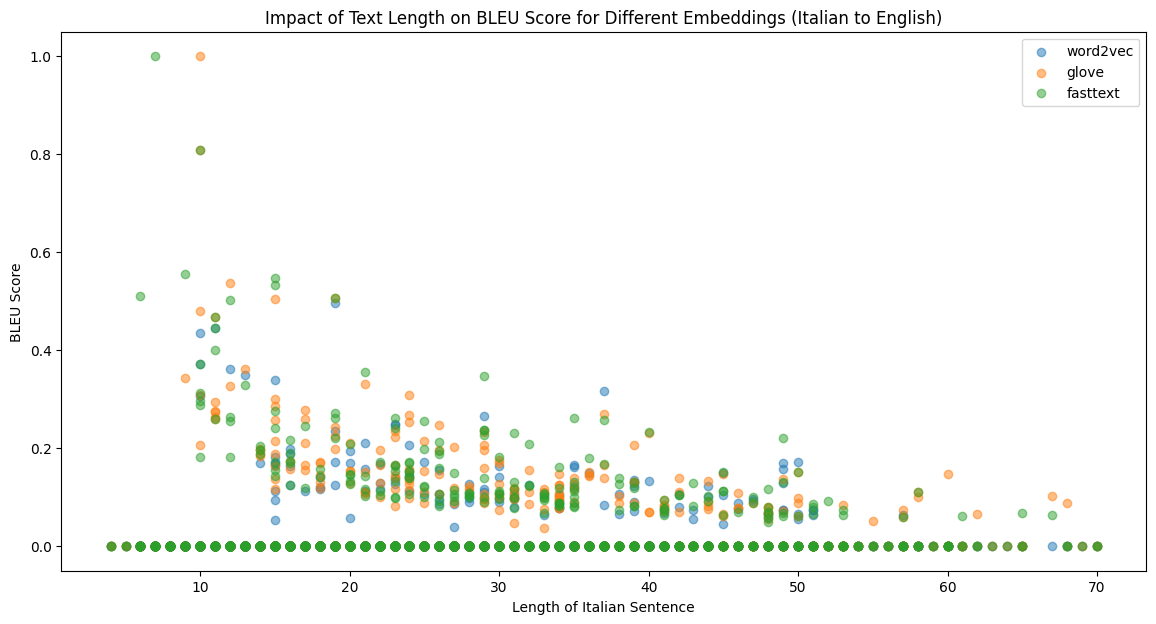

In [ ]:
# Analysis of text length impact on performance
lengths = []
bleu_scores_length_ita_to_eng = {emb: [] for emb in models_ita_to_eng}

for row in sample_test_df.itertuples():
    lengths.append(len(row.Italian.split()))
    for emb in models_ita_to_eng:
        bleu_scores_length_ita_to_eng[emb].append(bleu_scores_ita_to_eng[emb][len(lengths) - 1])

plt.figure(figsize=(14, 7))
for emb in models_ita_to_eng:
    plt.scatter(lengths, bleu_scores_length_ita_to_eng[emb], alpha=0.5, label=emb)
plt.xlabel('Length of Italian Sentence')
plt.ylabel('BLEU Score')
plt.legend()
plt.title('Impact of Text Length on BLEU Score for Different Embeddings (Italian to English)')
plt.show()

In [ ]:
sample_test_df_path = '/content/drive/My Drive/it-en/results/sample_test_df.csv'
sample_test_df.to_csv(sample_test_df_path, index=False)

#English to Italian Translation Model with Attention layer

As the Attention layer will be integrated into Decoder, Encoder class stays the same, but decoder needs to be updated.

In [ ]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, att_units):
        super().__init__()
        self.W1 = Dense(att_units)
        self.W2 = Dense(att_units)
        self.V = Dense(1)

    def call(self, decoder_hidden_state, encoder_output):
        # encoder_output shape: (batch_size, max_len, enc_units)
        # decoder_hidden_state shape: (batch_size, dec_units)
        decoder_hidden_state_with_time_axis = tf.expand_dims(decoder_hidden_state, 1)
        score = self.V(tf.nn.tanh(self.W1(encoder_output) + self.W2(decoder_hidden_state_with_time_axis)))
        attention_weights = tf.nn.softmax(score, axis=1)
        context_vector = attention_weights * encoder_output
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights

#The One_Step_Decoder class performs a single decoding step by integrating
# an attention mechanism, embedding layer, LSTM, and dense layer
# uses context vector from the attention mechanism to focus on relevant parts of encoder's output

class One_Step_Decoder(tf.keras.Model):
    def __init__(self, tar_vocab_size, embedding_dim, input_length, dec_units, att_units):
        super().__init__()
        self.embedding = Embedding(tar_vocab_size, embedding_dim, input_length=input_length)
        self.lstm = LSTM(dec_units * 2, return_sequences=False, return_state=True)
        self.dense = Dense(tar_vocab_size)
        self.attention = BahdanauAttention(att_units)

    def call(self, input_to_decoder, encoder_output, state_h, state_c):
        embeddings_input_dec = self.embedding(input_to_decoder)
        context_vec, att_weights = self.attention(state_h, encoder_output)
        context_vec = tf.expand_dims(context_vec, 1)
        input_to_decoder = tf.concat([embeddings_input_dec, context_vec], axis=-1)
        dec_out, dec_h_state, dec_c_state = self.lstm(input_to_decoder, initial_state=[state_h, state_c])
        predicted_out = self.dense(dec_out)
        return predicted_out, dec_h_state, dec_c_state, att_weights, context_vec

In [ ]:
class Decoder(tf.keras.Model):
    def __init__(self, out_vocab_size, embedding_size, input_length, dec_units, att_units):
        super().__init__()
        self.onestepdecoder = One_Step_Decoder(out_vocab_size, embedding_size, input_length, dec_units, att_units)

    def call(self, input_to_decoder, encoder_output, decoder_hidden_state, decoder_cell_state):
        all_outputs = tf.TensorArray(tf.float32, size=tf.shape(input_to_decoder)[1])
        for timestep in range(tf.shape(input_to_decoder)[1]):
            output, decoder_hidden_state, decoder_cell_state, _, _ = self.onestepdecoder(input_to_decoder[:, timestep:timestep+1], encoder_output, decoder_hidden_state, decoder_cell_state)
            all_outputs = all_outputs.write(timestep, output)
        all_outputs = tf.transpose(all_outputs.stack(), perm=[1, 0, 2])
        return all_outputs


In [ ]:
class EncoderDecoder(tf.keras.Model):
    def __init__(self, english_vocab_size, italian_vocab_size, embedding_size, enc_lstm_units, dec_lstm_units, encoder_input_length, decoder_input_length, enc_embedding_matrix, dec_embedding_matrix, att_units):
        super().__init__()
        self.encoder = Encoder(english_vocab_size, embedding_size, enc_lstm_units, encoder_input_length, enc_embedding_matrix)
        self.decoder = Decoder(italian_vocab_size, embedding_size, decoder_input_length, dec_lstm_units, att_units)

    def call(self, data):
        encoder_inputs, decoder_inputs = data
        encoder_initial_states = self.encoder.initialize_states(tf.shape(encoder_inputs)[0])
        enc_out, enc_h_state, enc_c_state = self.encoder(encoder_inputs, encoder_initial_states)
        dec_out = self.decoder(decoder_inputs, enc_out, enc_h_state, enc_c_state)
        return dec_out

In [ ]:
# custom loss function
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def custom_lossfunction(targets, logits):
   #  a mask to ignore padding tokens
    mask = tf.math.logical_not(tf.math.equal(targets, 0))
    #the loss for each element
    loss_ = loss_object(targets, logits)
    #converting the boolean mask to the same dtype as loss_
    mask = tf.cast(mask, dtype=loss_.dtype)
    # Applying the mask to the loss values
    loss_ *= mask
    # computing the mean loss, ignoring the padding tokens
    return tf.reduce_mean(loss_)

In [ ]:
def train_and_evaluate_attention(embedding_matrix_inp, embedding_matrix_out, embedding_name):
    embedding_dim = 300
    lstm_size = 256
    att_units = 256
    encoder_input_length = encoder_train.shape[1]
    decoder_input_length = decoder_input_train.shape[1]

    encoder_decoder_model = EncoderDecoder(
        english_vocab_size=english_vocab_size,
        italian_vocab_size=italian_vocab_size,
        embedding_size=embedding_dim,
        enc_lstm_units=lstm_size,
        dec_lstm_units=lstm_size,
        encoder_input_length=encoder_input_length,
        decoder_input_length=decoder_input_length,
        enc_embedding_matrix=embedding_matrix_inp,
        dec_embedding_matrix=embedding_matrix_out,
        att_units=att_units
    )
    # Applying the scheduler to an optimizer
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.002)


    encoder_decoder_model.compile(optimizer=optimizer, loss=custom_lossfunction)
    callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.1, patience=2) ]
    batch_size = 256
    train_data_generator = data_generator(encoder_train, decoder_input_train, decoder_output_train, batch_size)
    val_data_generator = data_generator(encoder_val, decoder_input_val, decoder_output_val, batch_size)

    encoder_decoder_model.fit(train_data_generator, validation_data=val_data_generator, epochs=10,callbacks=callbacks,  steps_per_epoch=len(encoder_train) // batch_size, validation_steps=len(encoder_val) // batch_size)
    return encoder_decoder_model

In [ ]:
# Training with FastText embeddings only
attention_model = train_and_evaluate_attention(embedding_matrix_fasttext_eng, embedding_matrix_fasttext_ita, 'fasttext')

Epoch 1/10
463/463 [==============================] - 336s 705ms/step - loss: 2.5849 - val_loss: 2.4629
Epoch 2/10
463/463 [==============================] - 325s 701ms/step - loss: 2.2356 - val_loss: 1.9709
Epoch 3/10
463/463 [==============================] - 325s 702ms/step - loss: 1.8260 - val_loss: 1.7111
Epoch 4/10
463/463 [==============================] - 325s 702ms/step - loss: 1.5623 - val_loss: 1.4910
Epoch 5/10
463/463 [==============================] - 324s 700ms/step - loss: 1.3597 - val_loss: 1.3615
Epoch 6/10
463/463 [==============================] - 324s 699ms/step - loss: 1.2196 - val_loss: 1.2738
Epoch 7/10
463/463 [==============================] - 324s 700ms/step - loss: 1.1134 - val_loss: 1.2160
Epoch 8/10
463/463 [==============================] - 324s 700ms/step - loss: 1.0277 - val_loss: 1.1819
Epoch 9/10
463/463 [==============================] - 324s 700ms/step - loss: 0.9580 - val_loss: 1.1538


In [ ]:
def plot_attention(attention_weights, encoder_inputs, predicted_words):
    heatmap_data = pd.DataFrame(attention_weights, columns=encoder_inputs, index=predicted_words)
    plt.figure(figsize=(15, 15))
    sns.heatmap(heatmap_data, cmap='viridis')
    plt.xlabel("English Words")
    plt.ylabel("Italian Translated Words")
    plt.title("Attention Plot")
    plt.tick_params(axis='both', which='major', labelsize=12, labelbottom=False, bottom=False, top=True, labeltop=True)
    plt.show()

In [ ]:
def predict_attention(input_sentence, model, tokenizer_inp, tokenizer_out, plot_attention_weights=False):
    # Tokenize the input English sentence
    tokenized_encoder_input = tokenizer_inp.texts_to_sequences([input_sentence])
    encoder_input = pad_sequences(tokenized_encoder_input, maxlen=70, padding='post')

    # Ensure the <end> token is present in the input
    for ele in encoder_input:
        if tokenizer_inp.word_index['<end>'] not in ele:
            ele[-1] = tokenizer_inp.word_index['<end>']

    #  initial encoder states
    enc_init_states = model.encoder.initialize_states(1)
    enc_out, enc_h_state, enc_c_state = model.encoder(encoder_input, states=enc_init_states)

    dec_h_state = enc_h_state
    dec_c_state = enc_c_state

    # Decoder initial input with <start> token
    decoder_initial_input = np.zeros((1, 1))
    decoder_initial_input[0, 0] = tokenizer_out.word_index['<start>']

    predicted_words = []
    att_weights_all = []
    while True:
        prediction, dec_h_state, dec_c_state, att_weights, _ = model.decoder.onestepdecoder(decoder_initial_input, enc_out, dec_h_state, dec_c_state)
        predicted_int = np.argmax(prediction.numpy().ravel())
        predicted_words.append(predicted_int)

        # Append attention weights
        att_weights_all.append(att_weights.numpy().ravel())
        # Change input to decoder
        decoder_initial_input[0, 0] = predicted_int
        if predicted_int == tokenizer_out.word_index['<end>'] or len(predicted_words) >= 70:
            break

    att_weights_all = np.array(att_weights_all)
    # Check for non-padding words in encoder input
    non_padded_encoder_input = np.where(encoder_input[0] != 0)[0]
    encoder_input_words = np.array(input_sentence.split())[non_padded_encoder_input]
    decoder_output_words = [tokenizer_out.index_word.get(ele, '') for ele in predicted_words]

    # Keep only those attention weights corresponding to non-padded words
    att_weights_all = att_weights_all[:, non_padded_encoder_input]

    # Plot the attention weights
    if plot_attention_weights:
        plot_attention(att_weights_all, encoder_input_words, decoder_output_words)
    else:
        return ' '.join(decoder_output_words)

In [ ]:
#the same test set for evaluation
sample_test_df=pd.read_csv('/content/drive/My Drive/it-en/results/sample_test_df.csv')

In [ ]:
bleu_scores = []
meteor_scores = []

print("\nEvaluating with attention mechanism...\n")

for i, (index, row) in enumerate(sample_test_df.iterrows()):
    input_sent = row['English']
    predicted_ita = predict_attention(input_sent, attention_model, tokenizer_english, tokenizer_italian)
    actual_ita = row['Italian'].replace('<start>', '').replace('<end>', '').strip()

    bleu_scores.append(sentence_bleu([actual_ita.split()], predicted_ita.split()))

    actual_ita_tokens = actual_ita.split()
    predicted_ita_tokens = predicted_ita.split()
    meteor_scores.append(meteor_score([actual_ita_tokens], predicted_ita_tokens))

    # Print some sample predictions
    if i % 500 == 0:
        print("=" * 50)
        print(f"English sentence: {row['English'].strip()}")
        print(f"Actual Translation: {actual_ita}")
        print(f"Predicted Translation: {predicted_ita}")
        print("=" * 50)


Evaluating with attention mechanism...

English sentence: <start> the fear of the stigma attached to a positive test result can prevent patients from accessing early screening <end>
Actual Translation: il timore di essere stigmatizzati in caso di risultato positivo potrebbe dissuadere i pazienti dal ricorrere allo screening precoce
Predicted Translation: la mancanza di tale esperienza si può dare un risultato positivo che può impedire ai pazienti di acquisto di un periodo di raccolta di trattamento <end>
English sentence: <start> the treaty of nice has failed to be adopted <end>
Actual Translation: il trattato di nizza è decaduto
Predicted Translation: il trattato di nizza non è stato adottato <end>
English sentence: <start> i welcome its references to the need for respect of international legality and for relevant international covenants of human rights the respect of women is rights and all minorities in the country and the condemnation of the violations of prisoner is rights in abu

In [ ]:
avg_bleu = np.mean(bleu_scores)
avg_meteor = np.mean(meteor_scores)

print(f"Average BLEU score with attention: {avg_bleu}")
print(f"Average METEOR score with attention: {avg_meteor}")

Average BLEU score with attention: 0.08680151699068862
Average METEOR score with attention: 0.3290130045987295


In [ ]:
# Saving the results
results = [{
    'Embedding': 'fasttext_attention',
    'Average BLEU Score': avg_bleu,
    'Average METEOR Score': avg_meteor
}]
results_df = pd.DataFrame(results)
results_save_path = '/content/drive/My Drive/it-en/results/attention_embedding_evaluation_results2.csv'
results_df.to_csv(results_save_path, index=False)

In [ ]:
# for heatmap visual, selecting shorter sentences for clearness of texts and ensure fitting
filtered_test_df = sample_test_df[sample_test_df['English'].apply(lambda x: 7 <= len(x.split()) <= 9)]

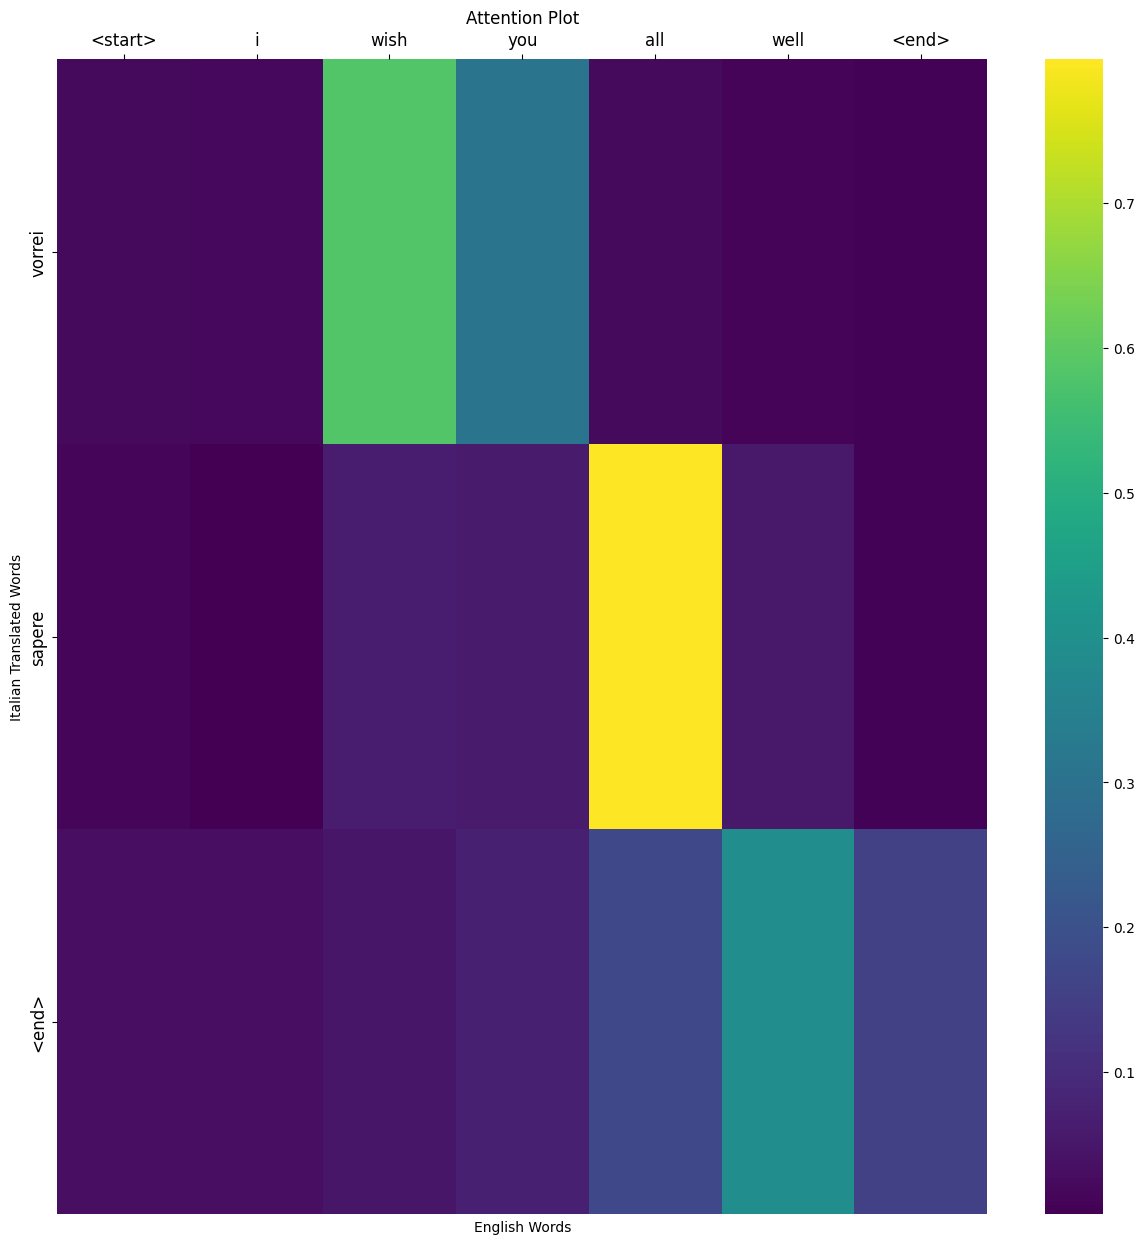

In [ ]:
sample_sentence = filtered_test_df['English'].sample(1).values[0]
predict_attention(sample_sentence, attention_model, tokenizer_english, tokenizer_italian, plot_attention_weights=True)

#Italian to English Translation Model with Attention layer

In [ ]:
attention_model2 = train_and_evaluate_attention_ita_to_eng(embedding_matrix_fasttext_ita, embedding_matrix_fasttext_eng, 'fasttext')

Epoch 1/10
463/463 [==============================] - 275s 576ms/step - loss: 2.3952 - val_loss: 2.2858
Epoch 2/10
463/463 [==============================] - 265s 573ms/step - loss: 2.0137 - val_loss: 1.7991
Epoch 3/10
463/463 [==============================] - 265s 572ms/step - loss: 1.6583 - val_loss: 1.5368
Epoch 4/10
463/463 [==============================] - 264s 571ms/step - loss: 1.4018 - val_loss: 1.3509
Epoch 5/10
463/463 [==============================] - 265s 573ms/step - loss: 1.2292 - val_loss: 1.2458
Epoch 6/10
463/463 [==============================] - 266s 575ms/step - loss: 1.1099 - val_loss: 1.1871
Epoch 7/10
463/463 [==============================] - 265s 572ms/step - loss: 1.0207 - val_loss: 1.1331
Epoch 8/10
463/463 [==============================] - 264s 571ms/step - loss: 0.9487 - val_loss: 1.1079
Epoch 9/10
463/463 [==============================] - 264s 571ms/step - loss: 0.8924 - val_loss: 1.0913
Model: "encoder_decoder_3"
_____________________________________

In [ ]:
def plot_attention(attention_weights, encoder_inputs, predicted_words):
    heatmap_data = pd.DataFrame(attention_weights, columns=encoder_inputs, index=predicted_words)
    plt.figure(figsize=(15, 15))
    sns.heatmap(heatmap_data, cmap='viridis')
    plt.xlabel("Italian Words")
    plt.ylabel("English Translated Words")
    plt.title("Attention Plot")
    plt.tick_params(axis='both', which='major', labelsize=12, labelbottom=False, bottom=False, top=True, labeltop=True)
    plt.show()

In [ ]:
bleu_scores = []
meteor_scores = []

print("\nEvaluating with attention mechanism...\n")

for i, (index, row) in enumerate(sample_test_df.iterrows()):
    input_sent = row['Italian']
    predicted_eng = predict_attention(input_sent, attention_model2, tokenizer_italian, tokenizer_english)
    actual_eng = row['English'].replace('<start>', '').replace('<end>', '').strip()

    bleu_scores.append(sentence_bleu([actual_eng.split()], predicted_eng.split()))

    actual_eng_tokens = actual_eng.split()
    predicted_eng_tokens = predicted_eng.split()
    meteor_scores.append(meteor_score([actual_eng_tokens], predicted_eng_tokens))

    if i % 500 == 0:
        print("=" * 50)
        print(f"Italian sentence: {row['Italian'].strip()}")
        print(f"Actual Translation: {actual_eng}")
        print(f"Predicted Translation: {predicted_eng}")
        print("=" * 50)



Evaluating with attention mechanism...

Italian sentence: <start> il timore di essere stigmatizzati in caso di risultato positivo potrebbe dissuadere i pazienti dal ricorrere allo screening precoce <end>
Actual Translation: the fear of the stigma attached to a positive test result can prevent patients from accessing early screening
Predicted Translation: the fear of such a risk of the child would be allowed to leave patients from the use of high speed <end>
Italian sentence: <start> il trattato di nizza è decaduto <end>
Actual Translation: the treaty of nice has failed to be adopted
Predicted Translation: the treaty of nice is not <end>
Italian sentence: <start> accolgo con soddisfazione i riferimenti del documento alla necessità di rispettare la legalità internazionale e le convenzioni relative ai diritti umani al rispetto nel paese dei diritti delle donne e di tutte le minoranze nonché alla condanna delle violazioni dei diritti dei prigionieri nel carcere di abu ghraib <end>
Actual 

In [ ]:
# Calculate average scores
print(f"Average BLEU score: {np.mean(bleu_scores)}")
print(f"Average METEOR score: {np.mean(meteor_scores)}")

# Save the results as a CSV file in Google Drive
results = [{
    'Model': 'attention_en_it',
    'Average BLEU Score': np.mean(bleu_scores),
    'Average METEOR Score': np.mean(meteor_scores)
}]
results_df = pd.DataFrame(results)
results_save_path = '/content/drive/My Drive/it-en/results/attention_en_it_model_evaluation_results3.csv'
results_df.to_csv(results_save_path, index=False)

Average BLEU score: 0.119454119668354
Average METEOR score: 0.4177631583274916


In [ ]:
# Filter test_df for sentences between 7 and 10 words for fitting into heatmap visual
filtered_test_df = sample_test_df[sample_test_df['Italian'].apply(lambda x: 7 <= len(x.split()) <= 10)]

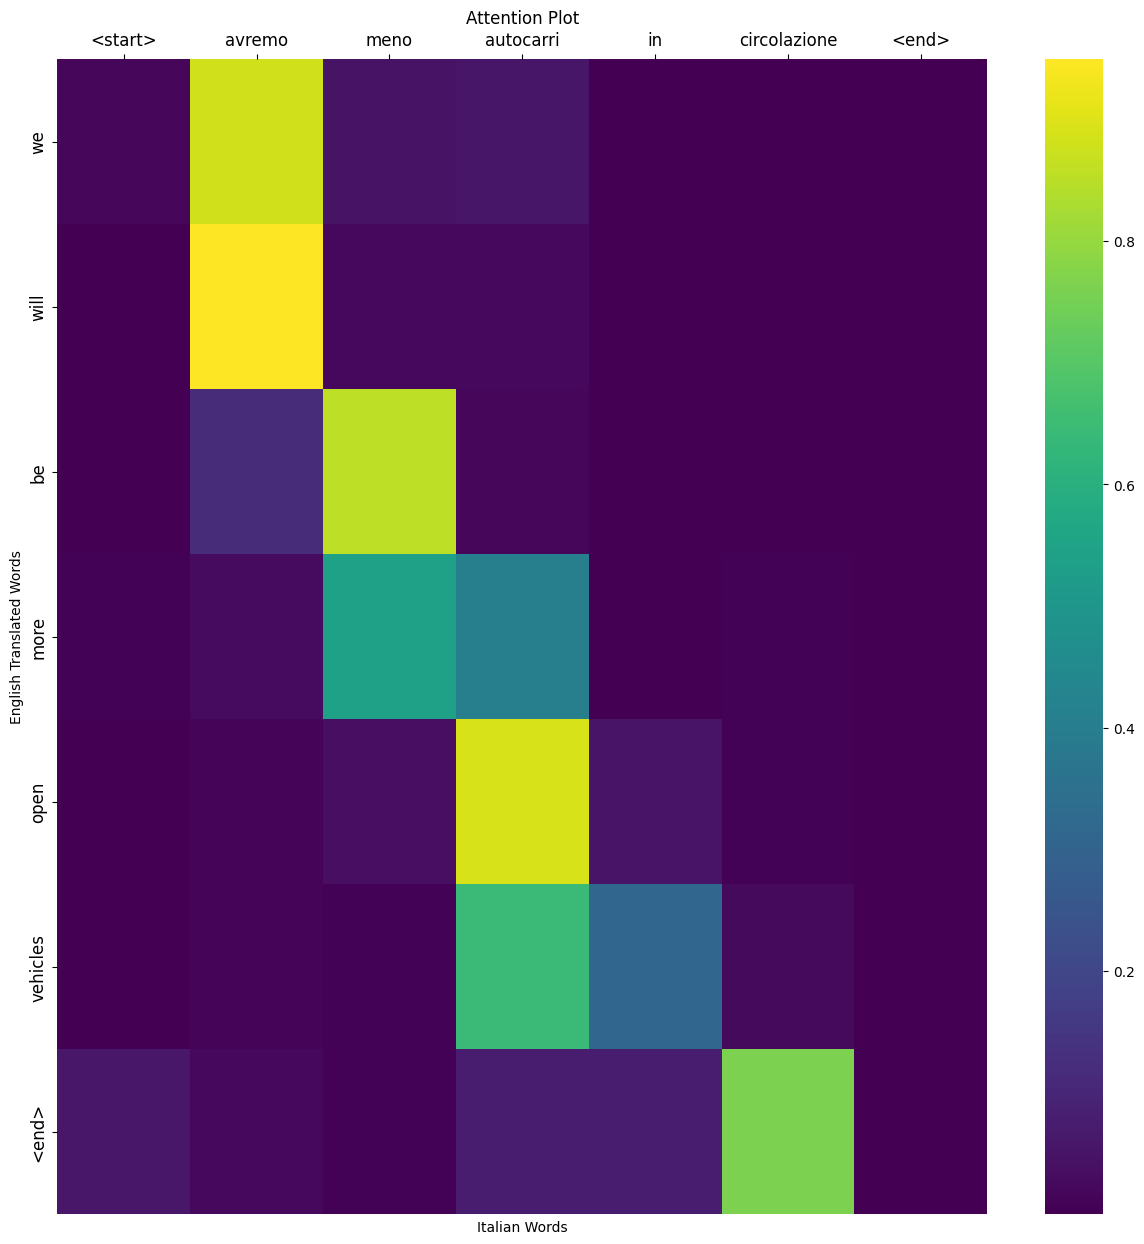

In [ ]:
sample_sentence = filtered_test_df['Italian'].sample(1).values[0]
predict_attention(sample_sentence, attention_model2, tokenizer_italian, tokenizer_english, plot_attention_weights=True)

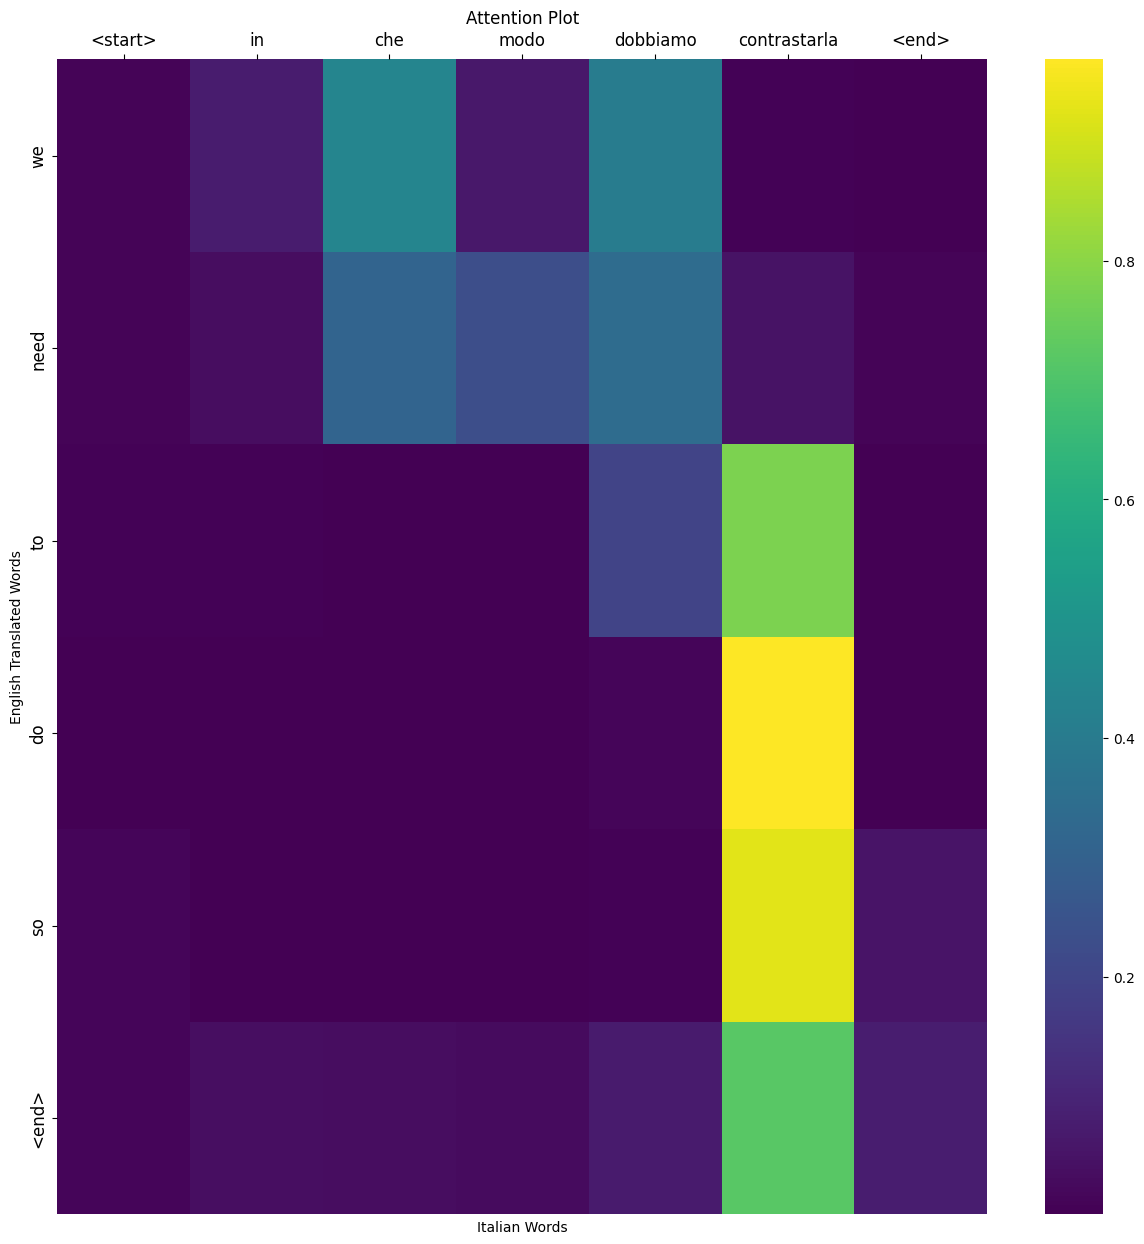

In [ ]:
sample_sentence = filtered_test_df['Italian'].sample(1).values[0]
predict_attention(sample_sentence, attention_model2, tokenizer_italian, tokenizer_english, plot_attention_weights=True)

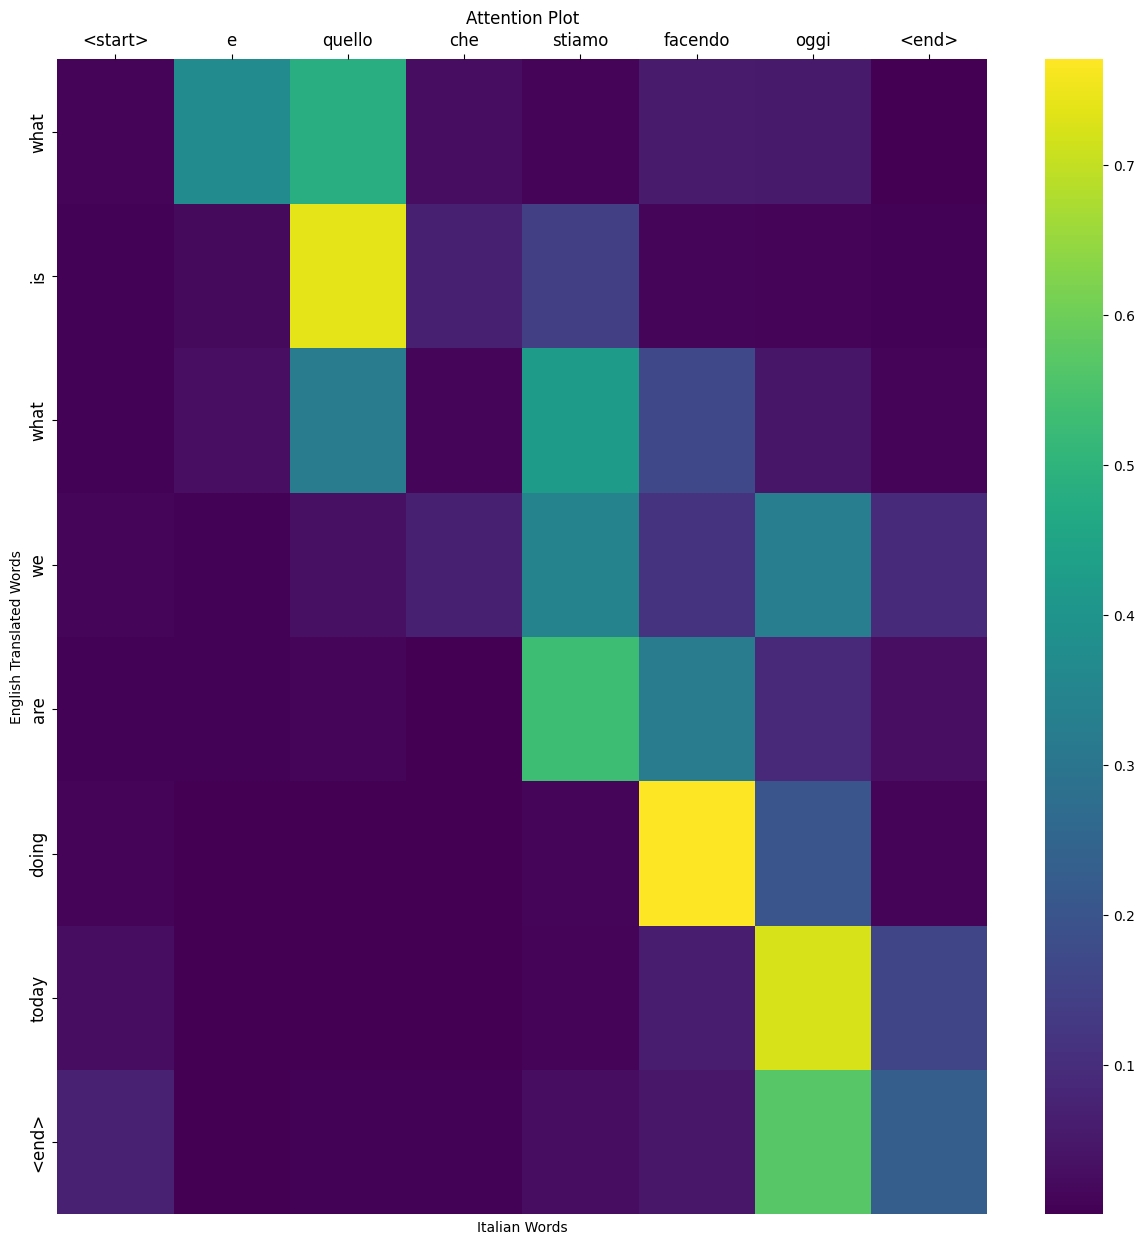

In [ ]:
sample_sentence = filtered_test_df['Italian'].sample(1).values[0]
predict_attention(sample_sentence, attention_model2, tokenizer_italian, tokenizer_english, plot_attention_weights=True)

# Bonus Task
We already have Eng->Ita model with attention, we will develop German->Eng model and combine them for translation from German to Italian. For German to English model, the development procedure will be same as previous models.

In [ ]:
drive_path = '/content/drive/My Drive/de-en'
german_file_path = os.path.join(drive_path, 'europarl-v7.de-en.de')
english_file_path = os.path.join(drive_path, 'europarl-v7.de-en.en')


def read_data(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        lines = file.readlines()
    return lines

german_lines = read_data(german_file_path)
english_lines = read_data(english_file_path)

In [ ]:
# Viewing samples of sentences and their translations
num_samples_to_view = 5
print("Sampled Sentences and Their Translations:\n")
for i in range(num_samples_to_view):
    print(f"German: {german_lines[i].strip()}")
    print(f"English: {english_lines[i].strip()}")
    print()

Sampled Sentences and Their Translations:

German: Wiederaufnahme der Sitzungsperiode
English: Resumption of the session

German: Ich erkläre die am Freitag, dem 17. Dezember unterbrochene Sitzungsperiode des Europäischen Parlaments für wiederaufgenommen, wünsche Ihnen nochmals alles Gute zum Jahreswechsel und hoffe, daß Sie schöne Ferien hatten.
English: I declare resumed the session of the European Parliament adjourned on Friday 17 December 1999, and I would like once again to wish you a happy new year in the hope that you enjoyed a pleasant festive period.

German: Wie Sie feststellen konnten, ist der gefürchtete "Millenium-Bug " nicht eingetreten. Doch sind Bürger einiger unserer Mitgliedstaaten Opfer von schrecklichen Naturkatastrophen geworden.
English: Although, as you will have seen, the dreaded 'millennium bug' failed to materialise, still the people in a number of countries suffered a series of natural disasters that truly were dreadful.

German: Im Parlament besteht der Wuns

In [ ]:
# Sampling 25% of the data
sample_size = int(len(german_lines) * 0.25)
sample_indices = random.sample(range(len(german_lines)), sample_size)

german_sampled_lines = [german_lines[i] for i in sample_indices]
english_sampled_lines = [english_lines[i] for i in sample_indices]

In [ ]:
# Initialize lists to store split sentences
aligned_german_sentences = []
aligned_english_sentences = []

german_sentence_counts = []
english_sentence_counts = []

# Iterate through the sampled lines
for ger_line, eng_line in zip(german_sampled_lines, english_sampled_lines):
    ger_sentences = split_into_sentences(ger_line.strip())
    eng_sentences = split_into_sentences(eng_line.strip())
    german_sentence_counts.append(len(ger_sentences))
    english_sentence_counts.append(len(eng_sentences))

    aligned_german_sentences.extend(ger_sentences)
    aligned_english_sentences.extend(eng_sentences)

In [ ]:
# Analysis of sentence counts
total_instances = len(german_sentence_counts)
more_german_sentences = sum(1 for ger_count, eng_count in zip(german_sentence_counts, english_sentence_counts) if ger_count > eng_count)
more_english_sentences = sum(1 for ger_count, eng_count in zip(german_sentence_counts, english_sentence_counts) if eng_count > ger_count)
matching_sentence_counts = sum(1 for ger_count, eng_count in zip(german_sentence_counts, english_sentence_counts) if ger_count == eng_count)

print(f"Total instances: {total_instances}")
print(f"More German sentences: {more_german_sentences} ({more_german_sentences / total_instances * 100:.2f}%)")
print(f"More English sentences: {more_english_sentences} ({more_english_sentences / total_instances * 100:.2f}%)")
print(f"Matching sentence counts: {matching_sentence_counts} ({matching_sentence_counts / total_instances * 100:.2f}%)")

Total instances: 480052
More German sentences: 50915 (10.61%)
More English sentences: 12213 (2.54%)
Matching sentence counts: 416924 (86.85%)


In [ ]:
# Filter instances where the number of sentences match and keep only the first sentence
filtered_german_sentences = []
filtered_english_sentences = []

for ger_count, eng_count, ger_line, eng_line in zip(german_sentence_counts, english_sentence_counts, german_sampled_lines, english_sampled_lines):
    if ger_count == eng_count:
        ger_sentences = split_into_sentences(ger_line.strip())
        eng_sentences = split_into_sentences(eng_line.strip())
        filtered_german_sentences.append(ger_sentences[0])
        filtered_english_sentences.append(eng_sentences[0])

final_df = pd.DataFrame({
    'German': filtered_german_sentences,
    'English': filtered_english_sentences
})

In [ ]:
final_df.head()
final_df = final_df.drop_duplicates()
final_df = final_df[final_df.apply(filter_empty_lines, axis=1)]

# Resetting index after filtering
final_df = final_df.reset_index(drop=True)
final_df.head()


,German,English
0,Man braucht nur ein Entwicklungs-Glossar zu ne...,All we would have to do is get a directory of ...
1,Die derzeitige Meinungsverschiedenheit beruht ...,The difference at the moment is that we do not...
2,"Gleichzeitig sehe ich keinen Widerspruch, wenn...","At the same time, I see no contradiction in or..."
3,"Ich will ein Europa, das die Entstehung neuer ...",I want a Europe that allows for the emergence ...
4,"Diese Arbeitnehmer waren bereit, zu wesentlich...",These workers were willing to work for conside...


In [ ]:
# Saving to drive
final_csv_file_path = '/content/drive/My Drive/de-en/europarl-v7.de-en-aligned-sentences_25.csv'
final_df.to_csv(final_csv_file_path, index=False)

In [ ]:
#final_csv_file_path = '/content/drive/My Drive/de-en/europarl-v7.de-en-aligned-sentences_25.csv'
#final_df = pd.read_csv(final_csv_file_path)

In [ ]:
# Preprocessing
#similar to italian, preserving german specific letters
def preprocess_german(text):
    text = text.lower()
    text = re.sub('[$)\?"’.°!;\'€%:,(/]', ' ', text)
    text = re.sub(' +', ' ', text)
    text = re.sub('–', ' ', text)
    text = text.split()
    return ' '.join(text)

def filter_lines(german, english):
    if german.startswith('<') or english.startswith('<'):
        return False
    if not german.strip() or not english.strip():
        return False
    return True

In [ ]:
# Apply preprocessing to both columns
final_df['English'] = final_df['English'].apply(preprocess_english)
final_df['German'] = final_df['German'].apply(preprocess_german)

filtered_df = final_df[final_df.apply(lambda x: filter_lines(x['German'], x['English']), axis=1)]

filtered_df.head()

,German,English
0,man braucht nur ein entwicklungs-glossar zu ne...,all we would have to do is get a directory of ...
1,die derzeitige meinungsverschiedenheit beruht ...,the difference at the moment is that we do not...
2,gleichzeitig sehe ich keinen widerspruch wenn ...,at the same time i see no contradiction in org...
3,ich will ein europa das die entstehung neuer w...,i want a europe that allows for the emergence ...
4,diese arbeitnehmer waren bereit zu wesentlich ...,these workers were willing to work for conside...


In [ ]:
filtered_df.shape

(404679, 2)

In [ ]:
# Keeping only 200000 instances due to computational limit
filtered_df = filtered_df.head(200000)
print(filtered_df.shape)

(200000, 2)


In [ ]:
# Add lengths of sentences for filtering
filtered_df['English_Word_Count'] = filtered_df['English'].apply(lambda x: len(x.split()))
filtered_df['German_Word_Count'] = filtered_df['German'].apply(lambda x: len(x.split()))

In [ ]:
for i in range(0,101,10):
    print("{}th Percentile value of english length {}".format(i, np.percentile(filtered_df['English_Word_Count'], i)))
print("*" * 50)
for i in range(90,101):
    print("{}th Percentile value of length {}".format(i, np.percentile(filtered_df['English_Word_Count'], i)))
print("*" * 50)
for i in [99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100]:
    print("{}th Percentile value of length {}".format(i, np.percentile(filtered_df['English_Word_Count'], i)))

0th Percentile value of english length 1.0
10th Percentile value of english length 9.0
20th Percentile value of english length 13.0
30th Percentile value of english length 16.0
40th Percentile value of english length 19.0
50th Percentile value of english length 22.0
60th Percentile value of english length 25.0
70th Percentile value of english length 29.0
80th Percentile value of english length 34.0
90th Percentile value of english length 42.0
100th Percentile value of english length 396.0
**************************************************
90th Percentile value of length 42.0
91th Percentile value of length 43.0
92th Percentile value of length 44.0
93th Percentile value of length 46.0
94th Percentile value of length 47.0
95th Percentile value of length 49.0
96th Percentile value of length 52.0
97th Percentile value of length 55.0
98th Percentile value of length 60.0
99th Percentile value of length 67.0
100th Percentile value of length 396.0
**********************************************

In [ ]:
for i in range(0,101,10):
    print("{}th Percentile value of german length {}".format(i, np.percentile(filtered_df['German_Word_Count'], i)))
print("*" * 50)
for i in range(90,101):
    print("{}th Percentile value of length {}".format(i, np.percentile(filtered_df['German_Word_Count'], i)))
print("*" * 50)
for i in [99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100]:
    print("{}th Percentile value of length {}".format(i, np.percentile(filtered_df['German_Word_Count'], i)))

0th Percentile value of german length 1.0
10th Percentile value of german length 8.0
20th Percentile value of german length 12.0
30th Percentile value of german length 14.0
40th Percentile value of german length 17.0
50th Percentile value of german length 20.0
60th Percentile value of german length 23.0
70th Percentile value of german length 27.0
80th Percentile value of german length 31.0
90th Percentile value of german length 39.0
100th Percentile value of german length 361.0
**************************************************
90th Percentile value of length 39.0
91th Percentile value of length 40.0
92th Percentile value of length 41.0
93th Percentile value of length 43.0
94th Percentile value of length 44.0
95th Percentile value of length 46.0
96th Percentile value of length 48.0
97th Percentile value of length 51.0
98th Percentile value of length 56.0
99th Percentile value of length 63.0
100th Percentile value of length 361.0
**************************************************
99.1th

In [ ]:
# Filter out sentences longer than 70 words (99th percentile for both languages)
filtered_df = filtered_df[filtered_df['English_Word_Count'] <= 70]
filtered_df = filtered_df[filtered_df['German_Word_Count'] <= 70]

In [ ]:
filtered_df.shape

(198389, 4)

In [ ]:
# Add start and end tokens after filtering
filtered_df['English'] = filtered_df['English'].apply(lambda x: f"<start> {x} <end>")
filtered_df['German'] = filtered_df['German'].apply(lambda x: f"<start> {x} <end>")

# Drop unnecessary columns
filtered_df = filtered_df.drop(['English_Word_Count', 'German_Word_Count'], axis=1)

In [ ]:
filtered_df.head()

,German,English
0,<start> man braucht nur ein entwicklungs-gloss...,<start> all we would have to do is get a direc...
1,<start> die derzeitige meinungsverschiedenheit...,<start> the difference at the moment is that w...
2,<start> gleichzeitig sehe ich keinen widerspru...,<start> at the same time i see no contradictio...
3,<start> ich will ein europa das die entstehung...,<start> i want a europe that allows for the em...
4,<start> diese arbeitnehmer waren bereit zu wes...,<start> these workers were willing to work for...


In [ ]:
# saving to drive
final_csv_file_path = '/content/drive/My Drive/de-en/filtered_data_sent_before_split.csv'
filtered_df.to_csv(final_csv_file_path, index=False)

In [ ]:
filtered_df_de_en = pd.read_csv('/content/drive/My Drive/de-en/filtered_data_sent_before_split.csv')

# Splitting the data into train, validation, and test sets
train_val_df_de_en, test_df_de_en = train_test_split(filtered_df_de_en, test_size=0.2, random_state=121)
train_df_de_en, val_df_de_en = train_test_split(train_val_df_de_en, test_size=0.25, random_state=542)  # 0.25 * 0.8 = 0.2

print(f"Train data shape = {train_df_de_en.shape}")
print(f"Validation data shape = {val_df_de_en.shape}")
print(f"Test data shape = {test_df_de_en.shape}")

Train data shape = (119033, 2)
Validation data shape = (39678, 2)
Test data shape = (39678, 2)


In [ ]:
filters = '!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n'
# Tokenize German as encoder input
tokenizer_german = Tokenizer(num_words=None, filters=filters, oov_token='UNK')
tokenizer_german.fit_on_texts(train_df_de_en['German'])

# Tokenize English as decoder input/output
tokenizer_english = Tokenizer(num_words=None, filters=filters, oov_token='UNK')
tokenizer_english.fit_on_texts(train_df_de_en['English'])

encoder_input_train = tokenizer_german.texts_to_sequences(train_df_de_en['German'])
encoder_input_val = tokenizer_german.texts_to_sequences(val_df_de_en['German'])
encoder_input_test = tokenizer_german.texts_to_sequences(test_df_de_en['German'])

decoder_tokenized_train = tokenizer_english.texts_to_sequences(train_df_de_en['English'])
decoder_tokenized_val = tokenizer_english.texts_to_sequences(val_df_de_en['English'])

# Prepare data for decoder input and decoder output
decoder_input_train = [seq[:-1] for seq in decoder_tokenized_train]
decoder_input_val = [seq[:-1] for seq in decoder_tokenized_val]
decoder_output_train = [seq[1:] for seq in decoder_tokenized_train]
decoder_output_val = [seq[1:] for seq in decoder_tokenized_val]

# Vocabulary sizes
german_vocab_size = len(tokenizer_german.word_index) + 1
english_vocab_size = len(tokenizer_english.word_index) + 1

print(german_vocab_size, english_vocab_size)

81552 31807


In [ ]:
max_len = 70

encoder_train = pad_sequences(encoder_input_train, maxlen=max_len, padding='post', truncating='post')
encoder_val = pad_sequences(encoder_input_val, maxlen=max_len, padding='post', truncating='post')
encoder_test = pad_sequences(encoder_input_test, maxlen=max_len, padding='post', truncating='post')

decoder_input_train = pad_sequences(decoder_input_train, maxlen=max_len, padding='post', truncating='post')
decoder_input_val = pad_sequences(decoder_input_val, maxlen=max_len, padding='post', truncating='post')

decoder_output_train = pad_sequences(decoder_output_train, maxlen=max_len, padding='post', truncating='post')
decoder_output_val = pad_sequences(decoder_output_val, maxlen=max_len, padding='post', truncating='post')

In [ ]:
# Ensuring <end> token is at the end
def ensure_end_token(sequences, token_index):
    for seq in sequences:
        if token_index not in seq:
            seq[-1] = token_index

ensure_end_token(encoder_train, tokenizer_german.word_index['<end>'])
ensure_end_token(encoder_val, tokenizer_german.word_index['<end>'])
ensure_end_token(encoder_test, tokenizer_german.word_index['<end>'])
ensure_end_token(decoder_output_train, tokenizer_english.word_index['<end>'])
ensure_end_token(decoder_output_val, tokenizer_english.word_index['<end>'])

In [ ]:
# Sample input outputs for encoder decoder
print("=" * 50)
random_index_1 = np.random.randint(len(train_df_de_en))
random_index_2 = np.random.randint(len(train_df_de_en))
random_index_3 = np.random.randint(len(train_df_de_en))

print("Encoder Inputs\n")
print(" ".join([tokenizer_german.index_word.get(ele, '') for ele in encoder_train[random_index_1]]))
print(" ".join([tokenizer_german.index_word.get(ele, '') for ele in encoder_train[random_index_2]]))
print(" ".join([tokenizer_german.index_word.get(ele, '') for ele in encoder_train[random_index_3]]))

print("=" * 50)

print("Decoder Inputs\n")
print(" ".join([tokenizer_english.index_word.get(ele, '') for ele in decoder_input_train[random_index_1]]))
print(" ".join([tokenizer_english.index_word.get(ele, '') for ele in decoder_input_train[random_index_2]]))
print(" ".join([tokenizer_english.index_word.get(ele, '') for ele in decoder_input_train[random_index_3]]))

print("=" * 50)

print("Decoder Outputs\n")
print(" ".join([tokenizer_english.index_word.get(ele, '') for ele in decoder_output_train[random_index_1]]))
print(" ".join([tokenizer_english.index_word.get(ele, '') for ele in decoder_output_train[random_index_2]]))
print(" ".join([tokenizer_english.index_word.get(ele, '') for ele in decoder_output_train[random_index_3]]))

print("=" * 50)

Encoder Inputs

<start> wir sind uns auch einig eine vereinbarung über die beteiligung des parlaments an den gasp maßnahmen im rahmen des vertrags anzustreben <end>                                               
<start> dies beinhaltet daß man versuchen muß kompromisse zwischen den verschiedenen forderungen zu finden <end>                                                       
<start> der zweite punkt betrifft die rückübernahmeabkommen <end>                                                              
Decoder Inputs

<start> we are also agreed about trying to reach an agreement on involving parliament in the cfsp arrangements within the framework of the treaty                                              
<start> this means trying to find compromises between the various demands                                                           
<start> the second point concerns the readmission agreements                                                              
Decoder Outputs

we are also

In [ ]:
# creating embedding matrices for FastText for german and english
embedding_dim = 300
fasttext_model_ger = KeyedVectors.load_word2vec_format('/content/drive/My Drive/it-en/cc.de.300.vec')
embedding_matrix_fasttext_ger = create_embedding_matrix(tokenizer_german, fasttext_model_ger, german_vocab_size, embedding_dim)
embedding_matrix_fasttext_eng = create_embedding_matrix(tokenizer_english, fasttext_model_eng, english_vocab_size, embedding_dim)

In [ ]:
attention_model_ger_eng = train_and_evaluate_attention_german_english(embedding_matrix_fasttext_ger, embedding_matrix_fasttext_eng)

Epoch 1/10
464/464 [==============================] - 276s 576ms/step - loss: 2.2804 - val_loss: 2.1566
Epoch 2/10
464/464 [==============================] - 265s 572ms/step - loss: 1.9556 - val_loss: 1.7759
Epoch 3/10
464/464 [==============================] - 267s 575ms/step - loss: 1.6608 - val_loss: 1.5842
Epoch 4/10
464/464 [==============================] - 266s 573ms/step - loss: 1.4754 - val_loss: 1.4414
Epoch 5/10
464/464 [==============================] - 266s 573ms/step - loss: 1.3338 - val_loss: 1.3461
Epoch 6/10
464/464 [==============================] - 265s 571ms/step - loss: 1.2275 - val_loss: 1.2814
Epoch 7/10
464/464 [==============================] - 265s 572ms/step - loss: 1.1447 - val_loss: 1.2337
Epoch 8/10
464/464 [==============================] - 266s 573ms/step - loss: 1.0763 - val_loss: 1.2039


In [ ]:
def plot_attention(attention_weights, encoder_inputs, predicted_words):
    heatmap_data = pd.DataFrame(attention_weights, columns=encoder_inputs, index=predicted_words)
    plt.figure(figsize=(15, 15))
    sns.heatmap(heatmap_data, cmap='viridis')
    plt.xlabel("Input Words")
    plt.ylabel("Output Words")
    plt.title("Attention Plot")
    plt.tick_params(axis='both', which='major', labelsize=12, labelbottom=False, bottom=False, top=True, labeltop=True)
    plt.show()

In [ ]:
sample_test_df_de_en = test_df_de_en.sample(1500, random_state=42)
sample_test_df_de_en.head()
#sample_test_df_de_en.to_csv('/content/drive/My Drive/de-en/sample_test_data.csv')

In [ ]:
def predict_attention_english_italian(input_sentence, model, tokenizer_english, tokenizer_italian, plot_attention_weights=False):
    return predict_attention(input_sentence, model, tokenizer_english, tokenizer_italian, plot_attention_weights=plot_attention_weights)

def predict_attention_german_english(input_sentence, model, tokenizer_german, tokenizer_english, plot_attention_weights=False):
    return predict_attention(input_sentence, model, tokenizer_german, tokenizer_english, plot_attention_weights=plot_attention_weights)


In [ ]:
# Evaluation on 1500 sample test set and print some predictions
bleu_scores = []
meteor_scores = []

print("\nEvaluating German to English model with attention mechanism...\n")
for i, (index, row) in enumerate(sample_test_df_de_en.iterrows()):
    input_sent = row['German']
    predicted_eng, _ = predict_attention_german_english(input_sent, attention_model_ger_eng, tokenizer_german, tokenizer_english)
    actual_eng = row['English'].replace('<start>', '').replace('<end>', '').strip()

    bleu_scores.append(sentence_bleu([actual_eng.split()], predicted_eng.split()))

    actual_eng_tokens = actual_eng.split()
    predicted_eng_tokens = predicted_eng.split()
    meteor_scores.append(meteor_score([actual_eng_tokens], predicted_eng_tokens))

    if i % 500 == 0:
        print("=" * 50)
        print(f"German sentence: {row['German'].strip()}")
        print(f"Actual Translation: {actual_eng}")
        print(f"Predicted Translation: {predicted_eng}")
        print("=" * 50)


Evaluating German to English model with attention mechanism...

German sentence: <start> im kampf für die redefreiheit die allen europäischen demokraten heilig ist wurde viel blut vergossen <end>
Actual Translation: a lot of blood was shed in the battle to achieve the right to freedom of speech which is sacred to all democrats of europe
Predicted Translation: the fight against terrorism which all the european people is of course is very sad to be <end>
German sentence: <start> abschließend möchte ich dem ausschuß für soziale angelegenheiten und insbesondere frau jöns im namen der europäischen kommission danken für die unterstützung der hauptlinien der eigenen vorschläge der kommission <end>
Actual Translation: finally on behalf of the european commission i would like to thank the social affairs committee and in particular mrs j ns for their support of the main points of the commission is own proposals
Predicted Translation: finally i would like to thank the rapporteur for social affai

In [ ]:
# Calculate and print average scores
avg_bleu = np.mean(bleu_scores)
avg_meteor = np.mean(meteor_scores)

print(f"Average BLEU score with attention: {avg_bleu}")
print(f"Average METEOR score with attention: {avg_meteor}")

# Save the results
results = [{
    'Model': 'german_to_english_with_attention',
    'Average BLEU Score': avg_bleu,
    'Average METEOR Score': avg_meteor
}]
results_df = pd.DataFrame(results)
results_save_path = '/content/drive/My Drive/de-en/results/german_to_english_attention_results.csv'
results_df.to_csv(results_save_path, index=False)

Average BLEU score with attention: 0.06365092641538336
Average METEOR score with attention: 0.328906526724767


### Pivot translating by combining the models

In [ ]:
def predict_german_to_italian(input_sentence, german_to_english_model, english_to_italian_model, tokenizer_german, tokenizer_english, tokenizer_italian):
    # Step 1 - translating German to English
    intermediate_translation, _ = predict_attention_german_english(input_sentence, german_to_english_model, tokenizer_german, tokenizer_english)

    # Step 2 - translating English to Italian
    final_translation, _ = predict_attention_english_italian(intermediate_translation, english_to_italian_model, tokenizer_english, tokenizer_italian)
    #returnning intermediate_translation just to review process
    return intermediate_translation, final_translation

In [ ]:
# Select some sample German sentences to translate
num_samples_to_view = 5
sample_indices = random.sample(range(len(sample_test_df)), num_samples_to_view)

In [ ]:
for i in sample_indices:
    german_sentence = sample_test_df_de_en.iloc[i]['German']
    print(f"Original German sentence: {german_sentence.strip()}")

    intermediate_translation, final_translation = predict_german_to_italian(
        german_sentence,
        attention_model_ger_eng,
        attention_model,
        tokenizer_german,
        tokenizer_english,
        tokenizer_italian
    )

    print(f"Intermediate English translation: {intermediate_translation}")
    print(f"Final Italian translation: {final_translation}")
    print("=" * 50)

Original German sentence: <start> wenn wir die rolle der kommission zu sehr schwächen entstehen ernsthafte probleme bezüglich der politischen verantwortung <end>
Intermediate English translation: if we are to be aware of the role of the commission to respond to the problems of political responsibility <end>
Final Italian translation: come si può fare per l onorevole poettering per costruire la possibilità di fare <end>
Original German sentence: <start> schweden besitzt seit 1999 als erstes und einziges land der eu diese art von exterritorialer gesetzgebung die es nun hoffentlich ermöglichen wird gegen die schweden vorzugehen die ihre töchter der sommerferienverstümmelung im ausland aussetzen <end>
Intermediate English translation: sweden has already been the first and second country of the eu to be able to use this type of a policy based on the agenda which now now to be able to give the united states to protect their fellow citizens in the netherlands <end>
Final Italian translation: 

In [ ]:
# Sample sentences for translation from German to Italian through English
sample_sentences = [
    "Die Bekämpfung des Klimawandels erfordert globale Zusammenarbeit.",
    "Die Europäische Union spielt eine Schlüsselrolle in der internationalen Politik.",
    "Es ist wichtig, dass wir die Demokratie in unserer Region stärken.",
    "Der Schutz der Umwelt sollte oberste Priorität haben.",
    "Die Zusammenarbeit mit unseren internationalen Partnern ist entscheidend für den Frieden und die Sicherheit."
]

In [ ]:
#translating samples
for sent in sample_sentences:
    print(f"\nGerman sentence: {sent}")
    intermediate_translation, translated_sentence = predict_german_to_italian(sent, attention_model_ger_eng, attention_model, tokenizer_german, tokenizer_english, tokenizer_italian)
    print(f"Intermediate English translation: {intermediate_translation}")
    print(f"Final Italian translation: {translated_sentence}")


German sentence: Die Bekämpfung des Klimawandels erfordert globale Zusammenarbeit.
Intermediate English translation: the fight against climate change is global cooperation <end>
Final Italian translation: i nuovi sistemi di mercato sociale si è d accordo <end>

German sentence: Die Europäische Union spielt eine Schlüsselrolle in der internationalen Politik.
Intermediate English translation: the european union plays a key role in the international policy <end>
Final Italian translation: l unione europea ha definito un sistema di regolamentazione <end>

German sentence: Es ist wichtig, dass wir die Demokratie in unserer Region stärken.
Intermediate English translation: it is important that we are able to strengthen democracy in our region <end>
Final Italian translation: e importante che ci concentriamo la necessità di coinvolgere <end>

German sentence: Der Schutz der Umwelt sollte oberste Priorität haben.
Intermediate English translation: the protection of the environment should be th


German sentence: Die Bekämpfung des Klimawandels erfordert globale Zusammenarbeit.


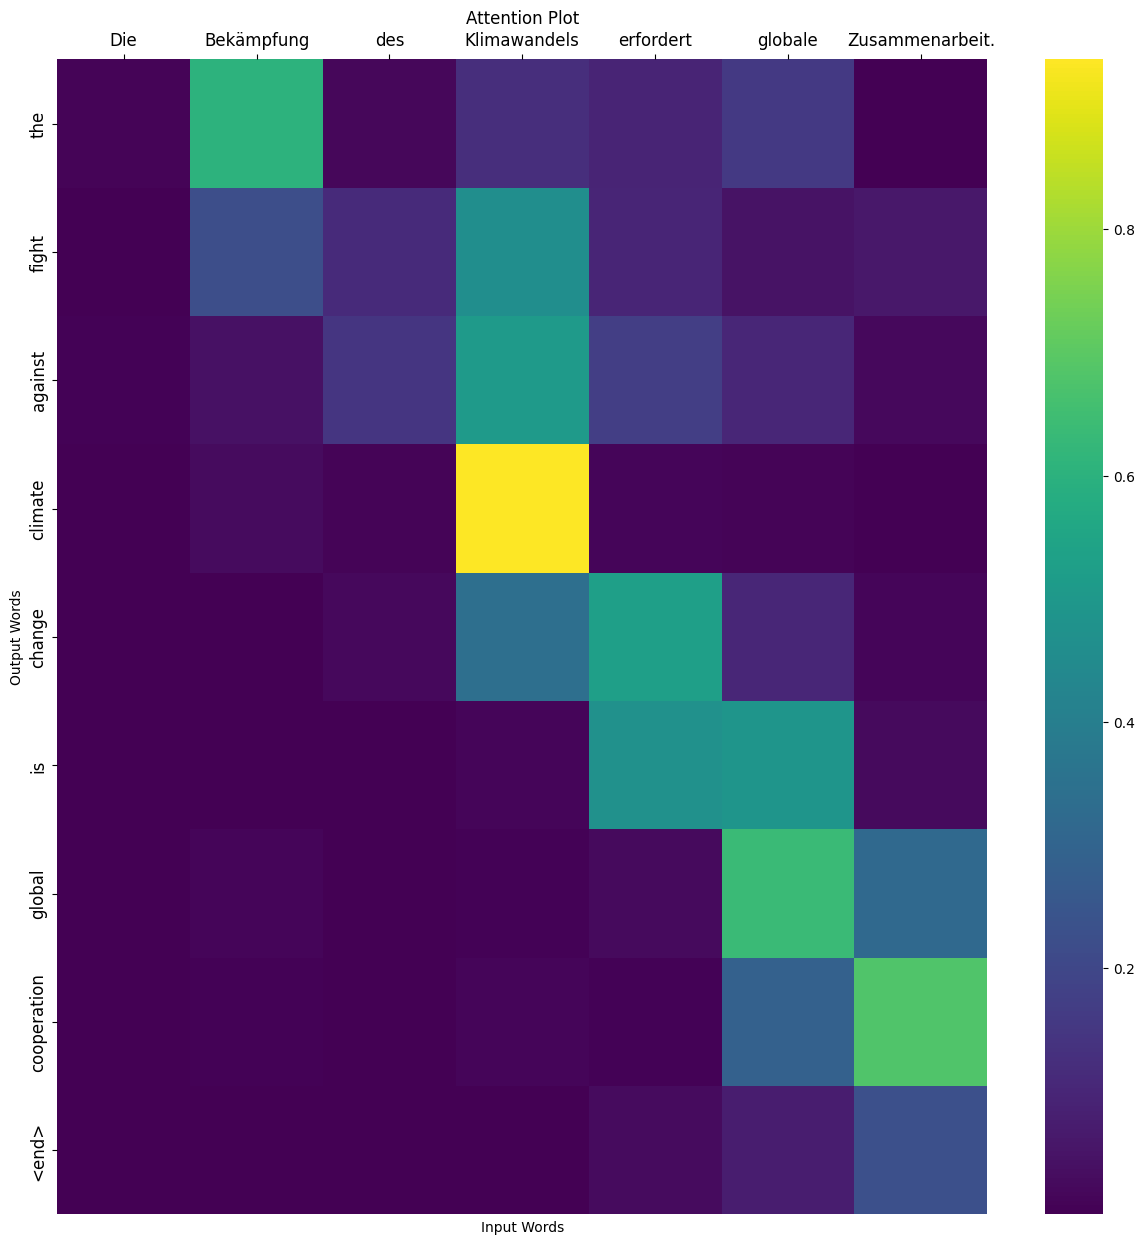

English translation: the fight against climate change is global cooperation <end>


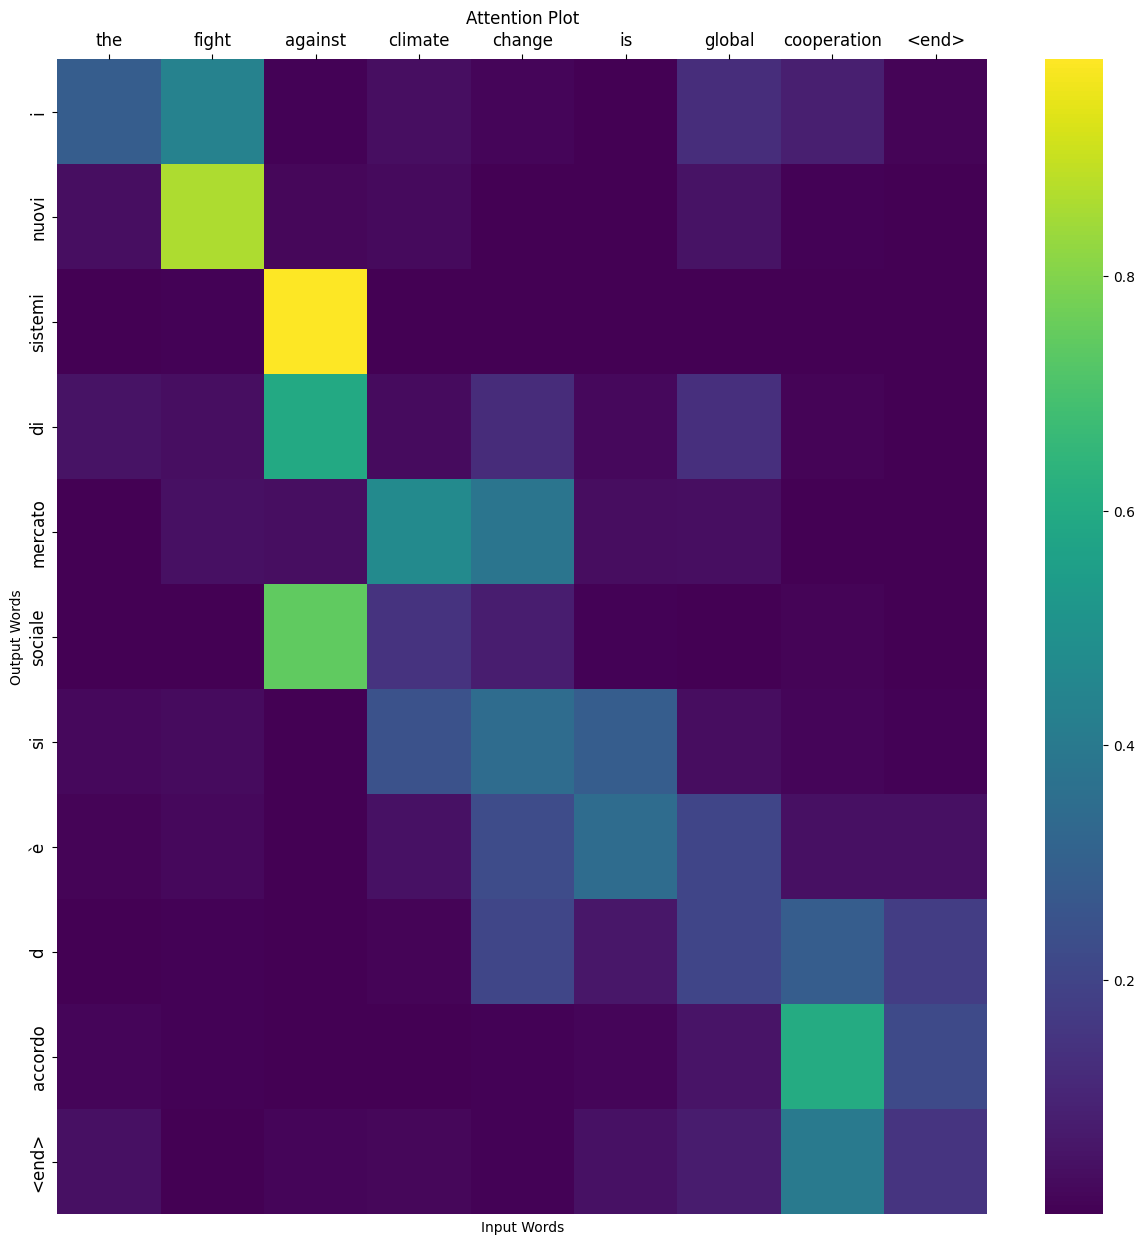

Italian translation: i nuovi sistemi di mercato sociale si è d accordo <end>

German sentence: Die Europäische Union spielt eine Schlüsselrolle in der internationalen Politik.


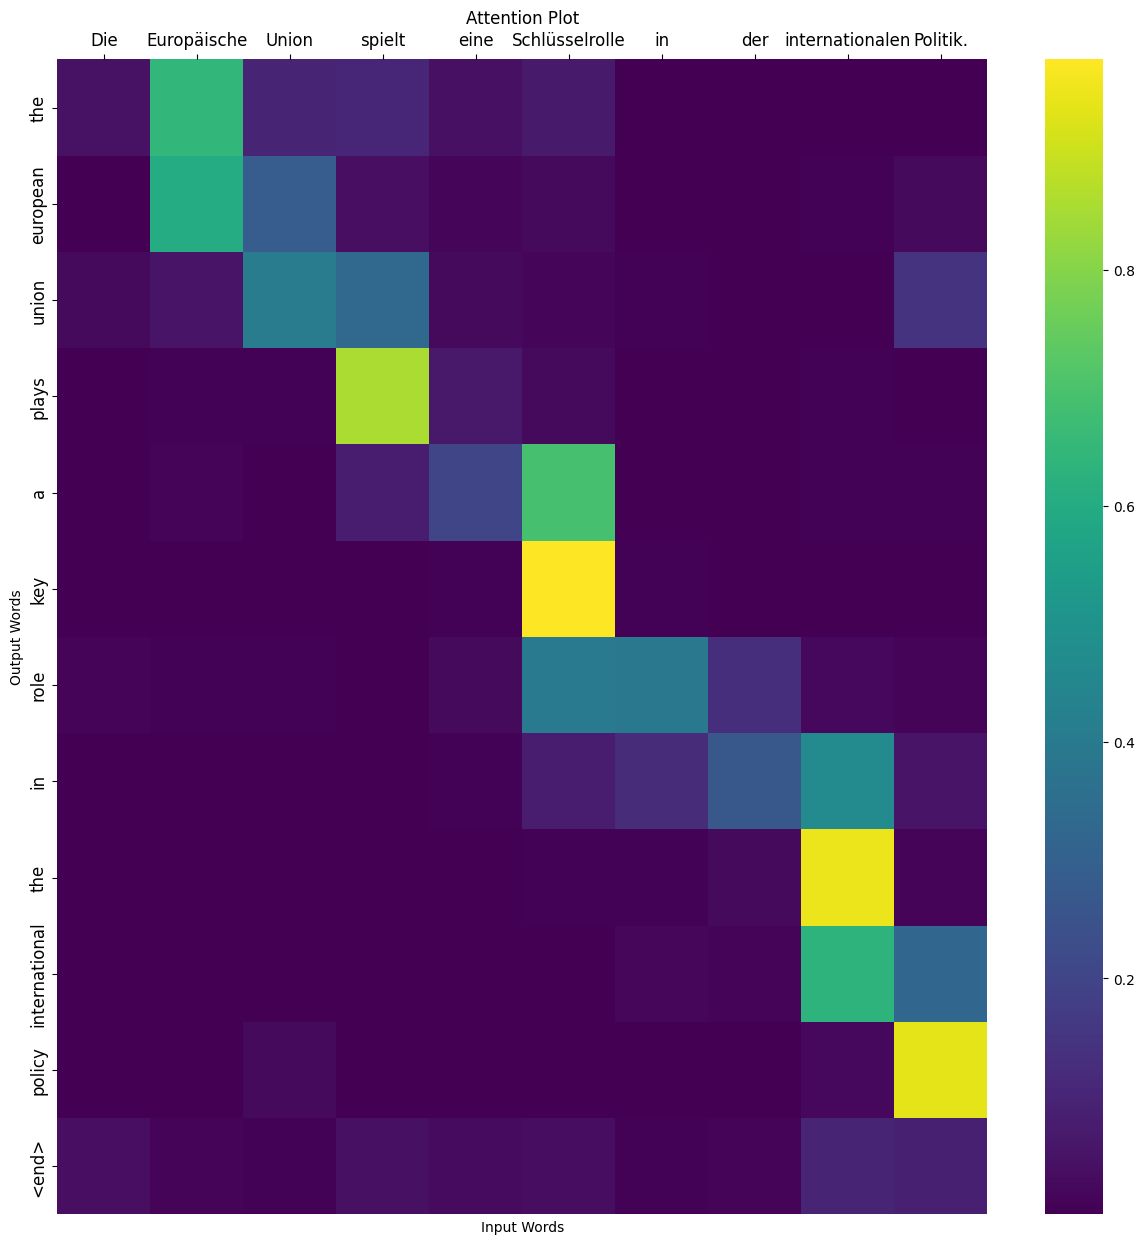

English translation: the european union plays a key role in the international policy <end>


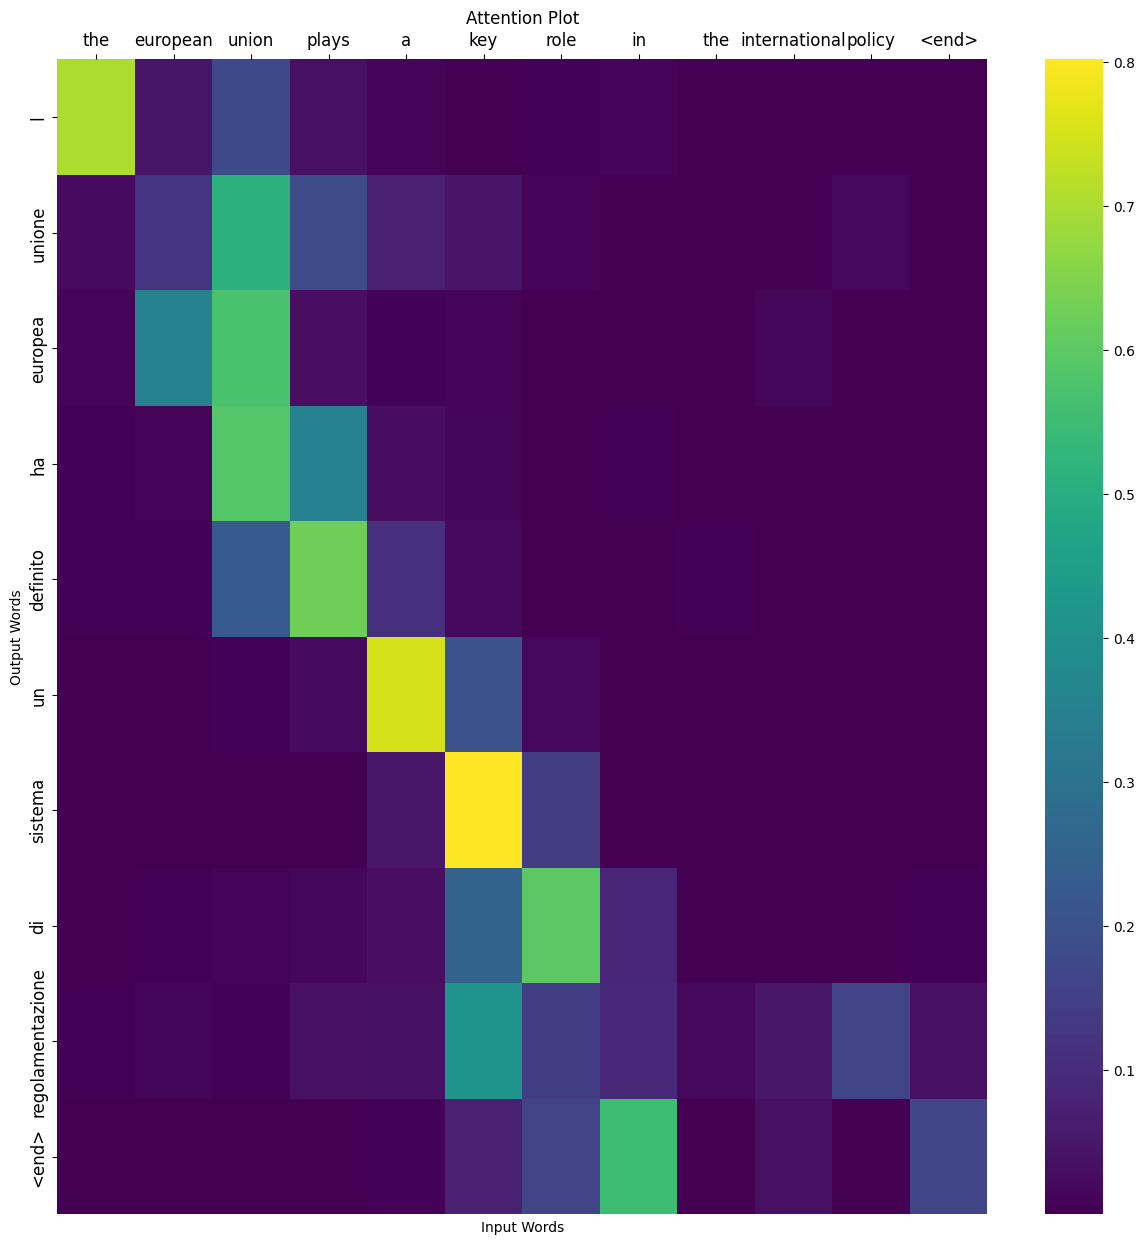

Italian translation: l unione europea ha definito un sistema di regolamentazione <end>

German sentence: Es ist wichtig, dass wir die Demokratie in unserer Region stärken.


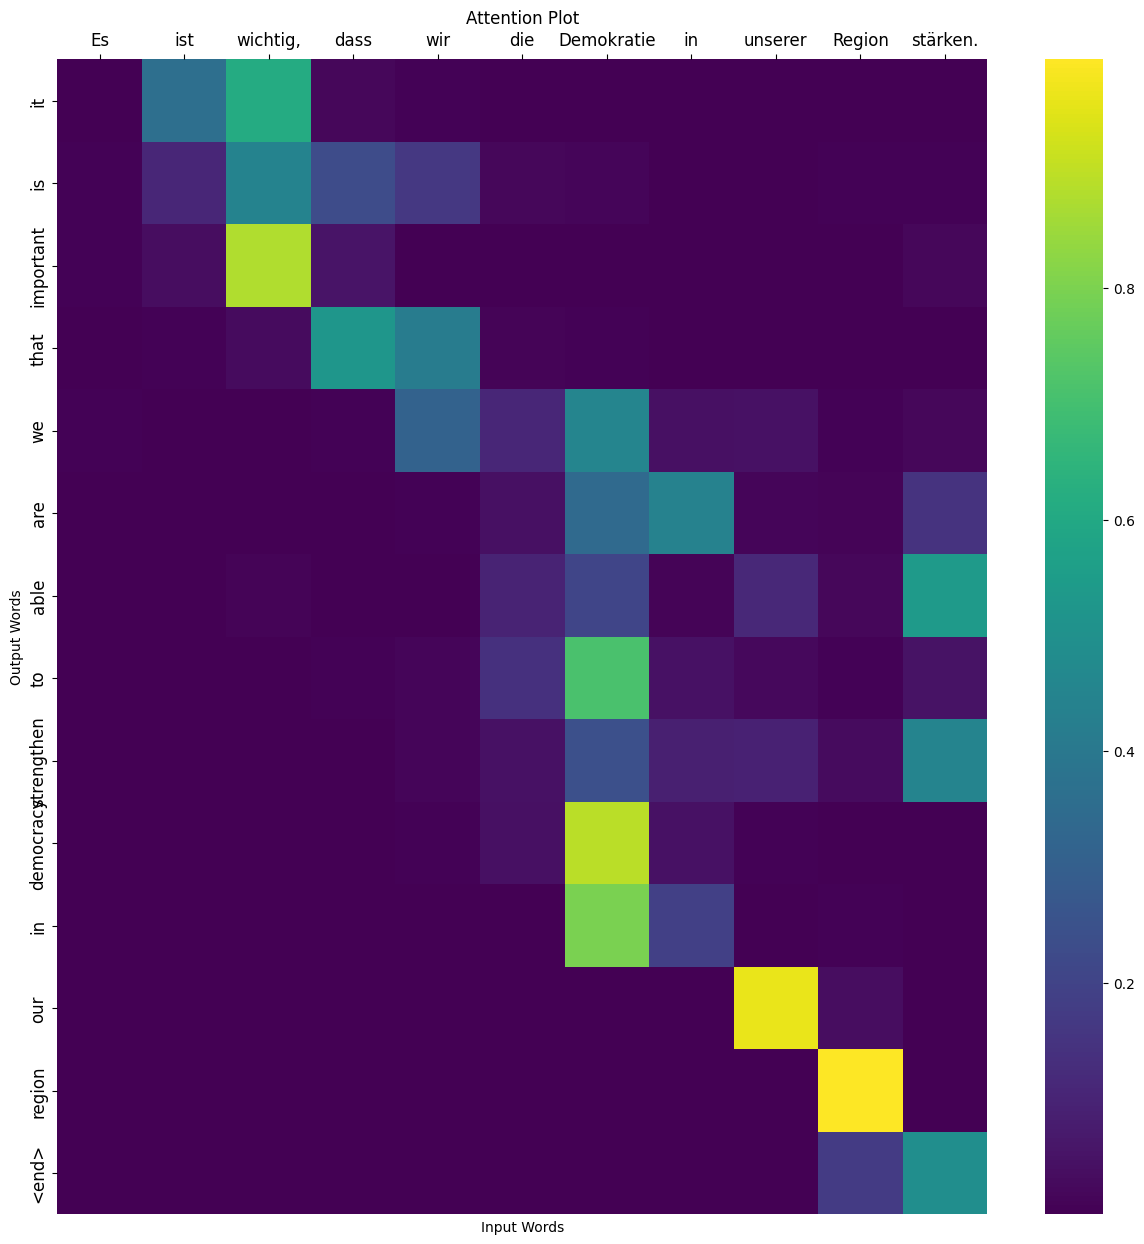

English translation: it is important that we are able to strengthen democracy in our region <end>


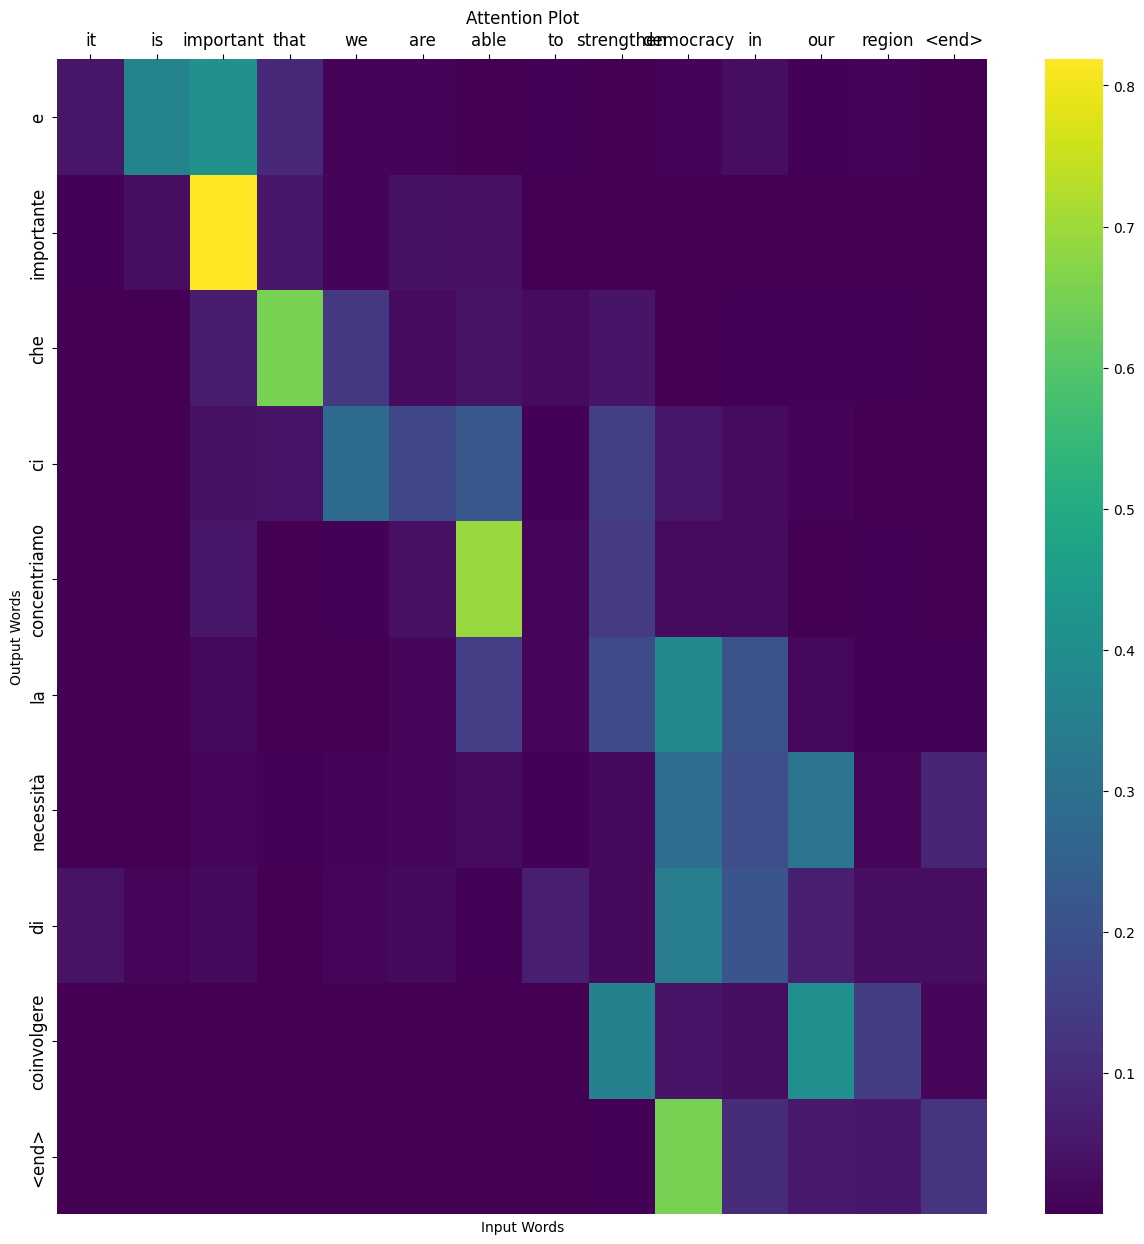

Italian translation: e importante che ci concentriamo la necessità di coinvolgere <end>

German sentence: Der Schutz der Umwelt sollte oberste Priorität haben.


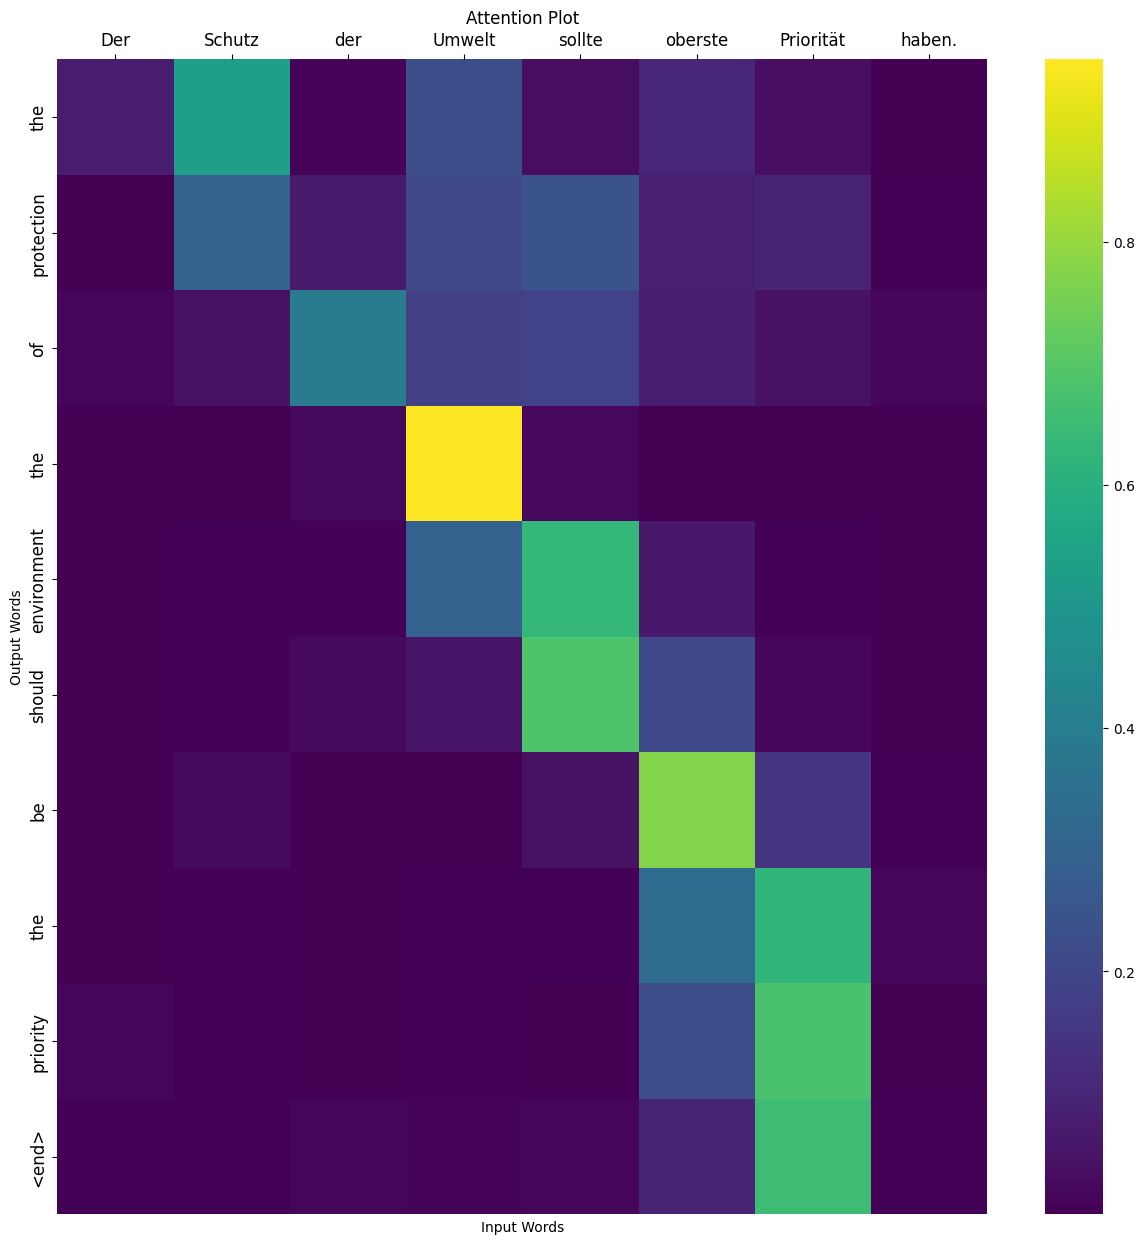

English translation: the protection of the environment should be the priority <end>


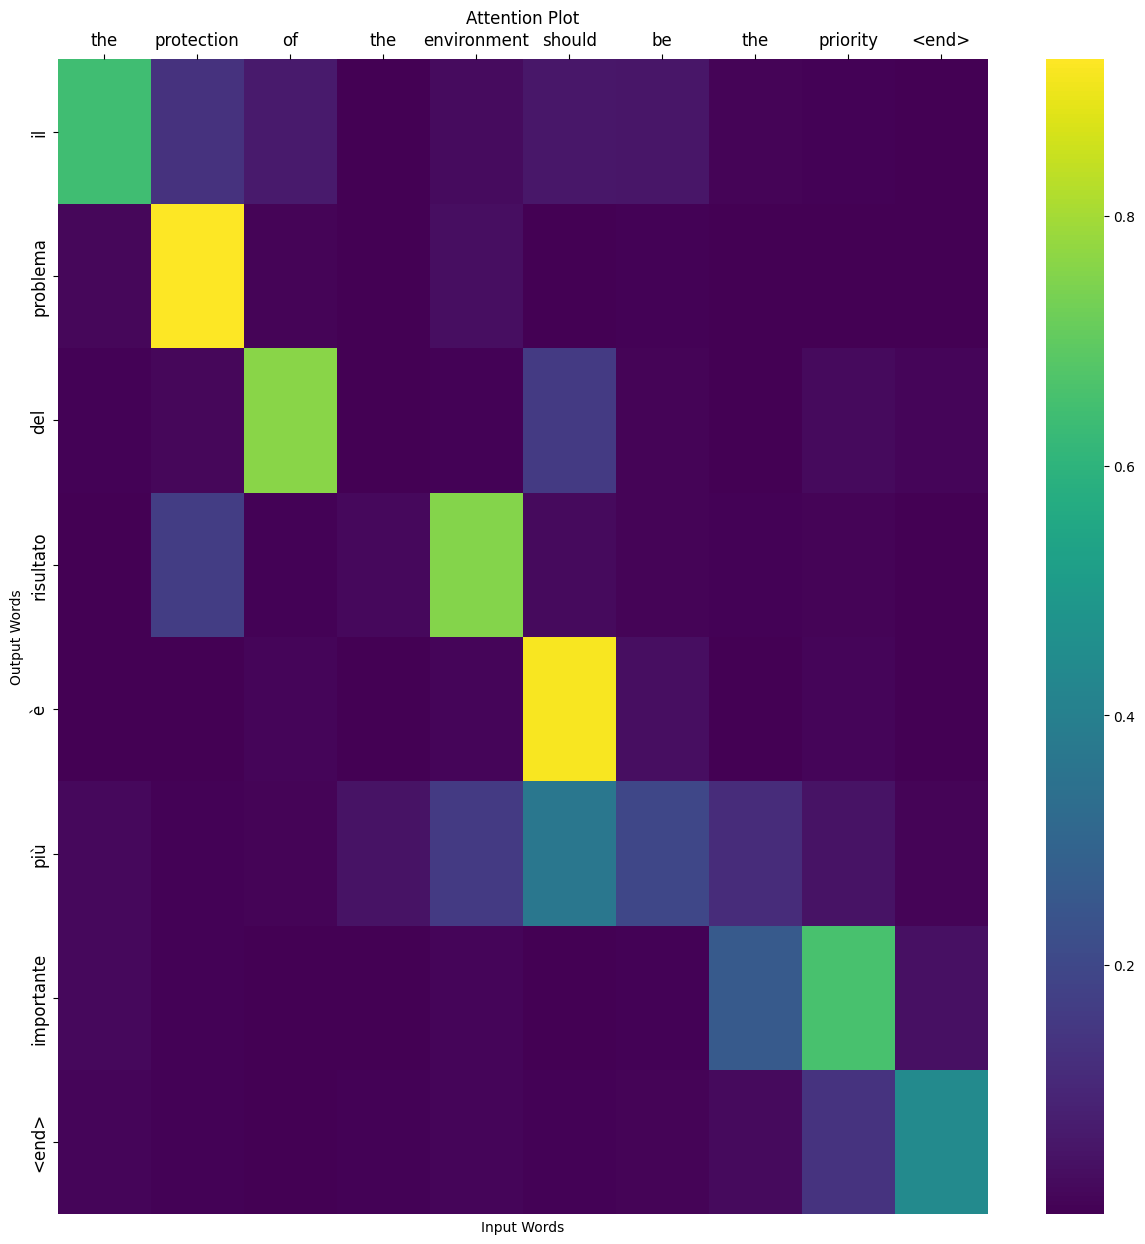

Italian translation: il problema del risultato è più importante <end>

German sentence: Die Zusammenarbeit mit unseren internationalen Partnern ist entscheidend für den Frieden und die Sicherheit.


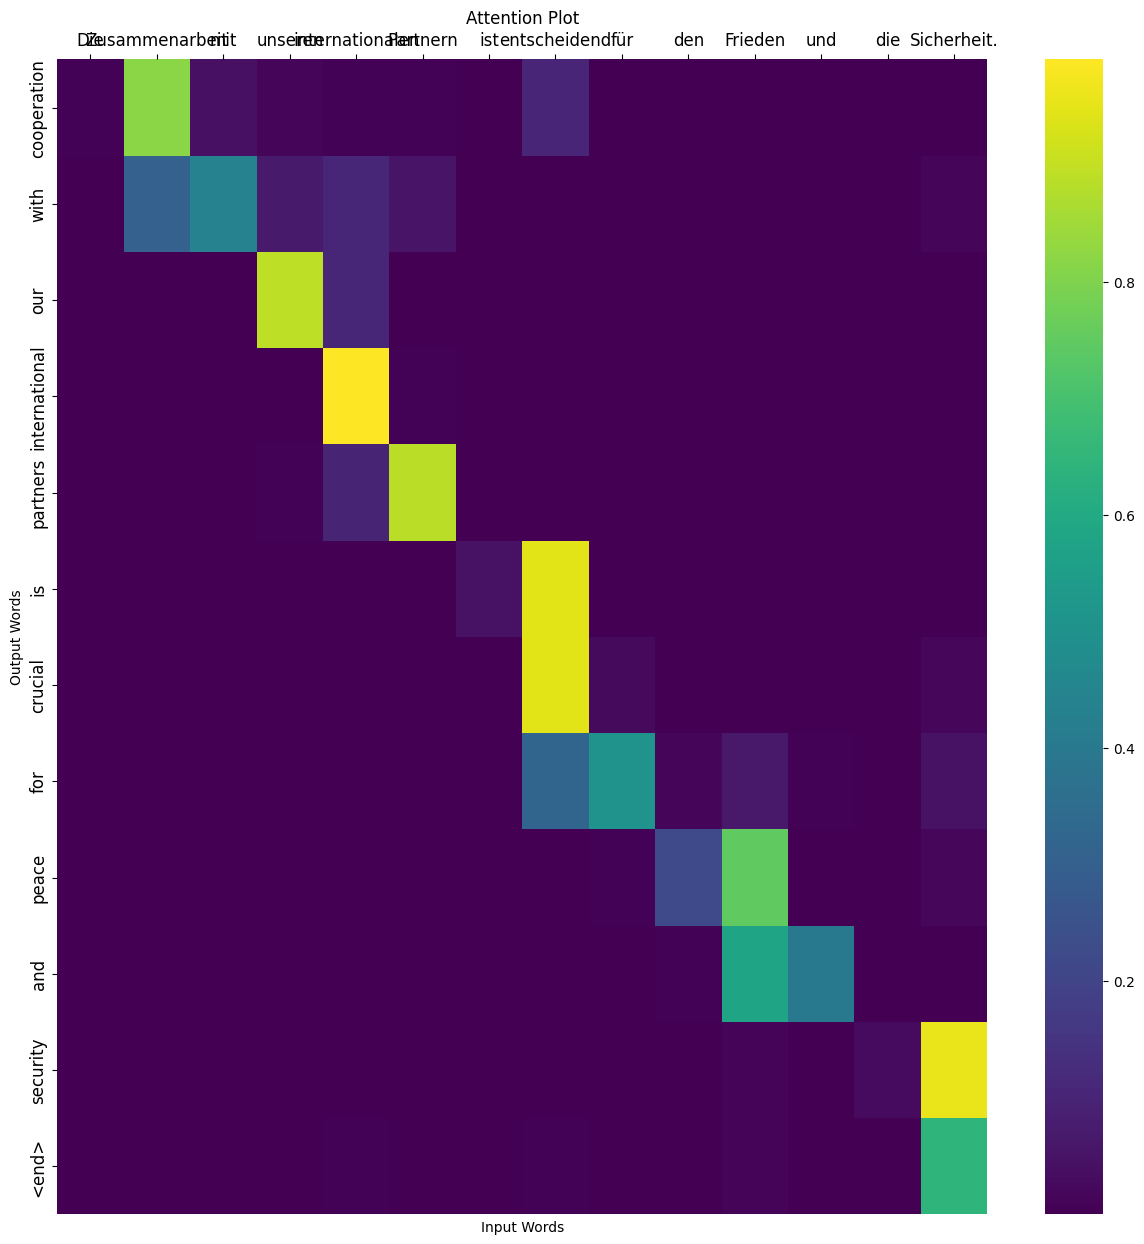

English translation: cooperation with our international partners is crucial for peace and security <end>


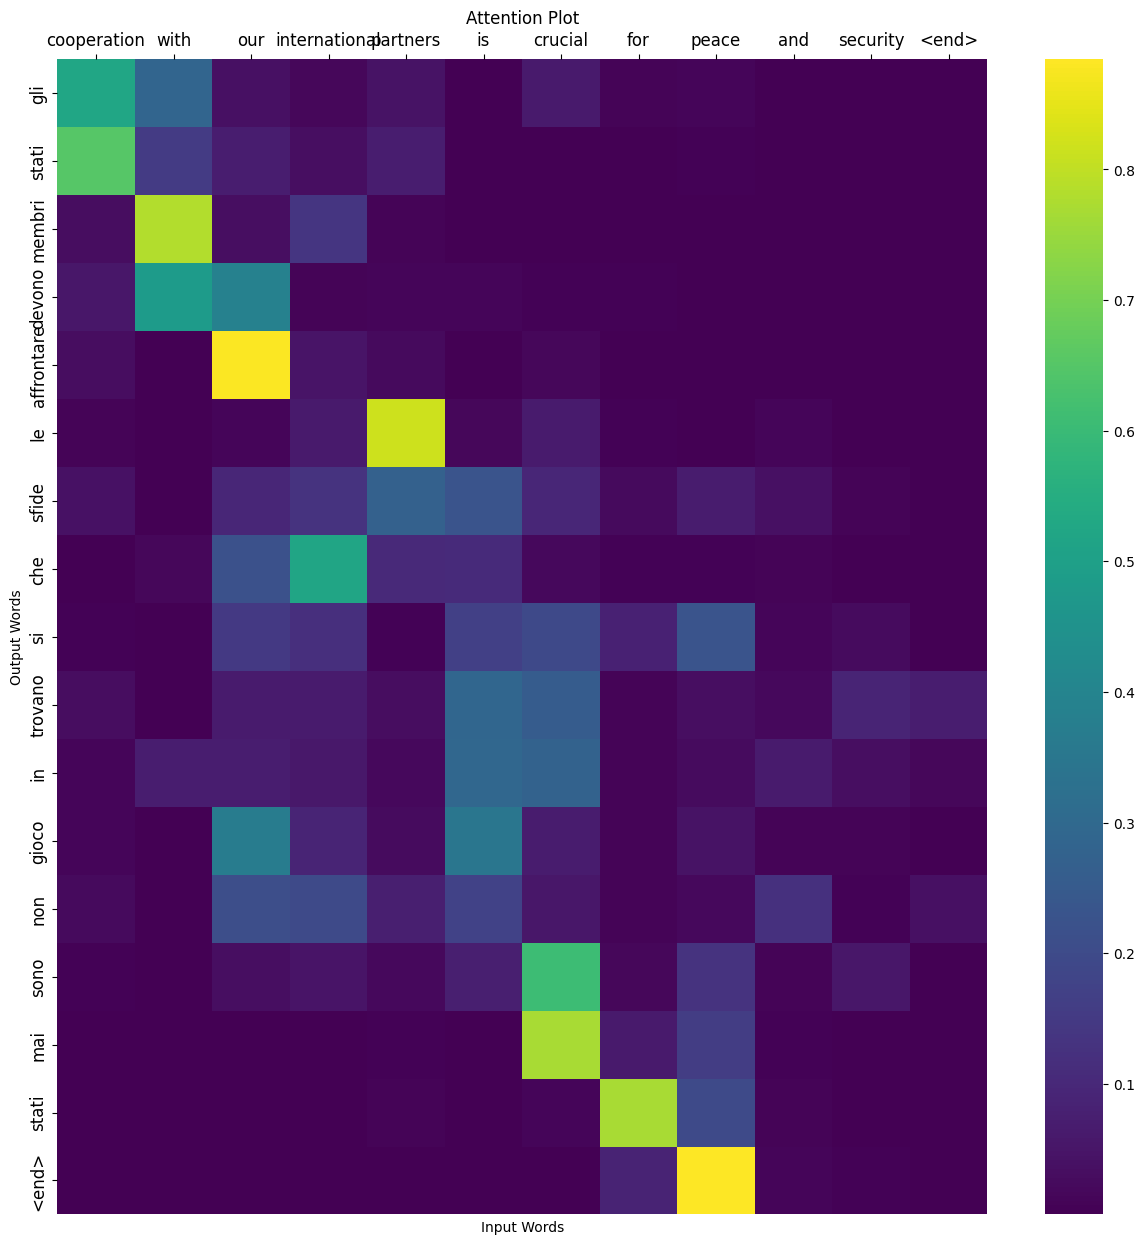

Italian translation: gli stati membri devono affrontare le sfide che si trovano in gioco non sono mai stati <end>


In [ ]:
# Plotting attentions for sample sentences
for sent in sample_sentences:
    print(f"\nGerman sentence: {sent}")
    intermediate_translation, att_weights_ger_eng = predict_attention_german_english(sent, attention_model_ger_eng, tokenizer_german, tokenizer_english, plot_attention_weights=True)
    print(f"English translation: {intermediate_translation}")
    final_translation, att_weights_eng_ita = predict_attention_english_italian(intermediate_translation, attention_model, tokenizer_english, tokenizer_italian, plot_attention_weights=True)
    print(f"Italian translation: {final_translation}")

# Character-based English to Italian translation model (without attention)

In [ ]:
# Find the 95th percentile of lengths for english
english_lengths = [len(line.strip()) for line in filtered_df.English]
max_char_len = int(np.percentile(english_lengths, 95))
print(f"The 95th percentile of text lengths is {max_char_len} characters.")

The 95th percentile of text lengths is 304 characters.


In [ ]:
# Find the 95th percentile of lengths for italian
italian_lengths = [len(line.strip()) for line in filtered_df.Italian]
max_char_len = int(np.percentile(italian_lengths, 95))
print(f"The 95th percentile of text lengths is {max_char_len} characters.")

The 95th percentile of text lengths is 327 characters.


In [ ]:
#330 can cover 95th for both
max_char_len=330

In [ ]:
# Special tokens for denoting start and end
start_token = '∈'
end_token = '∉'

# Replacing <start> and <end> tokens in datasets with unique characters
train_df['English'] = train_df['English'].apply(lambda x: x.replace('<start>', start_token).replace('<end>', end_token))
val_df['English'] = val_df['English'].apply(lambda x: x.replace('<start>', start_token).replace('<end>', end_token))
test_df['English'] = test_df['English'].apply(lambda x: x.replace('<start>', start_token).replace('<end>', end_token))

train_df['Italian'] = train_df['Italian'].apply(lambda x: x.replace('<start>', start_token).replace('<end>', end_token))
val_df['Italian'] = val_df['Italian'].apply(lambda x: x.replace('<start>', start_token).replace('<end>', end_token))
test_df['Italian'] = test_df['Italian'].apply(lambda x: x.replace('<start>', start_token).replace('<end>', end_token))

# Tokenization at character level
tokenizer_char_english = Tokenizer(char_level=True, oov_token='UNK')
tokenizer_char_english.fit_on_texts(train_df['English'])

tokenizer_char_italian = Tokenizer(char_level=True, oov_token='UNK')
tokenizer_char_italian.fit_on_texts(train_df['Italian'])

encoder_input_train = tokenizer_char_english.texts_to_sequences(train_df['English'])
encoder_input_val = tokenizer_char_english.texts_to_sequences(val_df['English'])
encoder_input_test = tokenizer_char_english.texts_to_sequences(test_df['English'])

decoder_tokenized_train = tokenizer_char_italian.texts_to_sequences(train_df['Italian'])
decoder_tokenized_val = tokenizer_char_italian.texts_to_sequences(val_df['Italian'])

# Prepare data for decoder input and decoder output
decoder_input_train = [seq[:-1] for seq in decoder_tokenized_train]
decoder_input_val = [seq[:-1] for seq in decoder_tokenized_val]
decoder_output_train = [seq[1:] for seq in decoder_tokenized_train]
decoder_output_val = [seq[1:] for seq in decoder_tokenized_val]

# Vocabulary sizes
english_char_vocab_size = len(tokenizer_char_english.word_index) + 1
italian_char_vocab_size = len(tokenizer_char_italian.word_index) + 1

# Pad sequences
encoder_train = pad_sequences(encoder_input_train, maxlen=max_char_len, padding='post', truncating='post')
encoder_val = pad_sequences(encoder_input_val, maxlen=max_char_len, padding='post', truncating='post')
encoder_test = pad_sequences(encoder_input_test, maxlen=max_char_len, padding='post', truncating='post')

decoder_input_train = pad_sequences(decoder_input_train, maxlen=max_char_len, padding='post', truncating='post')
decoder_input_val = pad_sequences(decoder_input_val, maxlen=max_char_len, padding='post', truncating='post')

decoder_output_train = pad_sequences(decoder_output_train, maxlen=max_char_len, padding='post', truncating='post')
decoder_output_val = pad_sequences(decoder_output_val, maxlen=max_char_len, padding='post', truncating='post')

# Ensuring end token is at the end
def ensure_end_token(sequences, token_index):
    for seq in sequences:
        if token_index not in seq:
            seq[-1] = token_index

ensure_end_token(encoder_train, tokenizer_char_english.word_index[end_token])
ensure_end_token(encoder_val, tokenizer_char_english.word_index[end_token])
ensure_end_token(encoder_test, tokenizer_char_english.word_index[end_token])
ensure_end_token(decoder_output_train, tokenizer_char_italian.word_index[end_token])
ensure_end_token(decoder_output_val, tokenizer_char_italian.word_index[end_token])

In [ ]:
class CharEncoder(tf.keras.Model):
    def __init__(self, inp_vocab_size, embedding_size, lstm_size, input_length):
        super().__init__()
        # Embedding layer to convert character indices to dense vectors
        self.embedding = Embedding(inp_vocab_size, embedding_size, input_length=input_length)
        # Bidirectional LSTM for encoding the character sequence
        self.lstm = tf.keras.layers.Bidirectional(LSTM(lstm_size, return_sequences=True, return_state=True))

    def call(self, input_sequence, states):
        # Convert character indices to dense embeddings
        embeddings = self.embedding(input_sequence)
        # Pass the embeddings through the bidirectional LSTM
        enc_out, forward_h, forward_c, backward_h, backward_c = self.lstm(embeddings, initial_state=states)
        # Concatenate the forward and backward states
        state_h = tf.keras.layers.Concatenate()([forward_h, backward_h])
        state_c = tf.keras.layers.Concatenate()([forward_c, backward_c])
        return enc_out, state_h, state_c

    def initialize_states(self, batch_size):
        lstm_units = self.lstm.forward_layer.units  # Access the units from the forward LSTM layer
        return [tf.zeros((batch_size, lstm_units)), tf.zeros((batch_size, lstm_units)),
                tf.zeros((batch_size, lstm_units)), tf.zeros((batch_size, lstm_units))]

class CharDecoder(tf.keras.Model):
    def __init__(self, out_vocab_size, embedding_size, lstm_size, input_length):
        super().__init__()
        # Embedding layer to convert character indices to dense vectors
        self.embedding = Embedding(out_vocab_size, embedding_size, input_length=input_length)
        # LSTM layer for decoding the character sequence
        self.lstm = LSTM(lstm_size * 2, return_sequences=True, return_state=True)
        # TimeDistributed Dense layer to project LSTM outputs to character probabilities
        self.time_distributed_dense = tf.keras.layers.TimeDistributed(Dense(out_vocab_size, activation='softmax'))

    def call(self, input_sequence, initial_states):
        # Convert character indices to dense embeddings
        embeddings = self.embedding(input_sequence)
        # Pass the embeddings through the LSTM
        dec_out, dec_h_state, dec_c_state = self.lstm(embeddings, initial_state=initial_states)
        # Project the LSTM outputs to the vocabulary size
        dec_out = self.time_distributed_dense(dec_out)
        return dec_out, dec_h_state, dec_c_state

class CharEncoderDecoder(tf.keras.Model):
    def __init__(self, english_vocab_size, italian_vocab_size, embedding_size, lstm_size, encoder_input_length, decoder_input_length):
        super().__init__()
        # Character-level encoder
        self.encoder = CharEncoder(inp_vocab_size=english_vocab_size, embedding_size=embedding_size, lstm_size=lstm_size, input_length=encoder_input_length)
        # Character-level decoder
        self.decoder = CharDecoder(out_vocab_size=italian_vocab_size, embedding_size=embedding_size, lstm_size=lstm_size, input_length=decoder_input_length)

    def call(self, inputs):
        encoder_input, decoder_input = inputs
        # Initialize encoder states
        enc_initial_states = self.encoder.initialize_states(tf.shape(encoder_input)[0])
        # Encode the input sequence
        enc_out, enc_h_state, enc_c_state = self.encoder(encoder_input, enc_initial_states)
        # Decode the target sequence
        dec_out, dec_h_state, dec_c_state = self.decoder(decoder_input, initial_states=[enc_h_state, enc_c_state])
        return dec_out

In [ ]:
# Compile the model
embedding_dim = 64  # Adjusted for character-level embeddings, converting ch integer indices into dense, continuous-valued vectors
lstm_size = 256
encoder_input_length = encoder_train.shape[1]
decoder_input_length = decoder_input_train.shape[1]

encoder_decoder_model = CharEncoderDecoder(
    english_vocab_size=english_char_vocab_size,
    italian_vocab_size=italian_char_vocab_size,
    embedding_size=embedding_dim,
    lstm_size=lstm_size,
    encoder_input_length=encoder_input_length,
    decoder_input_length=decoder_input_length
)

encoder_decoder_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.002), loss='sparse_categorical_crossentropy')


In [ ]:
# Training the model
from tensorflow.keras.callbacks import EarlyStopping

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss',min_delta=0.01, patience=2, restore_best_weights=True)

# Training the model with early stopping
batch_size = 256
train_data_generator = data_generator(encoder_train, decoder_input_train, decoder_output_train, batch_size)
val_data_generator = data_generator(encoder_val, decoder_input_val, decoder_output_val, batch_size)

encoder_decoder_model.fit(train_data_generator, validation_data=val_data_generator, epochs=10,
                          steps_per_epoch=len(encoder_train) // batch_size, validation_steps=len(encoder_val) // batch_size,
                          callbacks=[early_stopping])

Epoch 1/10
463/463 [==============================] - 34s 73ms/step - loss: 0.4389 - val_loss: 0.4316
Epoch 2/10
463/463 [==============================] - 34s 73ms/step - loss: 0.4219 - val_loss: 0.4182
Epoch 3/10
463/463 [==============================] - 34s 73ms/step - loss: 0.4092 - val_loss: 0.4083
Epoch 4/10
463/463 [==============================] - 34s 73ms/step - loss: 0.3993 - val_loss: 0.4011
Epoch 5/10
463/463 [==============================] - 34s 73ms/step - loss: 0.3910 - val_loss: 0.3959
Epoch 6/10
463/463 [==============================] - 34s 73ms/step - loss: 0.3843 - val_loss: 0.3890
Epoch 7/10
463/463 [==============================] - 34s 73ms/step - loss: 0.3785 - val_loss: 0.3861
Epoch 8/10
463/463 [==============================] - 34s 73ms/step - loss: 0.3736 - val_loss: 0.3827


In [ ]:
sample_test_df['English'] = sample_test_df['English'].apply(lambda x: x.replace('<start>', start_token).replace('<end>', end_token))
sample_test_df['Italian'] = sample_test_df['Italian'].apply(lambda x: x.replace('<start>', start_token).replace('<end>', end_token))

In [ ]:
print(sample_test_df.head())

                                             English  \
0  ∈ the fear of the stigma attached to a positiv...   
1  ∈ draft general budget 2009 as modified by the...   
2  ∈ it is therefore not necessary to count the i...   
3  ∈ the diagnosis is correct but the proposed re...   
4  ∈ secondly may i ask if this report has led th...   

                                             Italian  
0  ∈ il timore di essere stigmatizzati in caso di...  
1  ∈ progetto di bilancio generale 2009 modificat...  
2  ∈ pertanto non è necessario contare gli strume...  
3  ∈ la diagnosi è giusta ma i rimedi sono troppo...  
4  ∈ in secondo luogo vorrei sapere se questa rel...  


In [ ]:
def predict_sentence_char(input_sentence, model, tokenizer_inp, tokenizer_out):
    # Tokenize the input  sentence
    tokenized_encoder_input = tokenizer_inp.texts_to_sequences([input_sentence])
    encoder_input = pad_sequences(tokenized_encoder_input, maxlen=max_char_len, padding='post')

    for ele in encoder_input:
        if tokenizer_inp.word_index[end_token] not in ele:
            ele[-1] = tokenizer_inp.word_index[end_token]

    # Get initial encoder states
    enc_init_states = model.encoder.initialize_states(1)
    enc_out, enc_h_state, enc_c_state = model.encoder(encoder_input, states=enc_init_states)

    # Initialize decoder input with start token
    decoder_initial_states = [enc_h_state, enc_c_state]
    decoder_initial_input = np.zeros((1, 1))
    decoder_initial_input[0, 0] = tokenizer_out.word_index[start_token]

    predicted_chars = []
    predicting = True
    while predicting:
        dec_out, dec_h_state, dec_c_state = model.decoder(decoder_initial_input, initial_states=decoder_initial_states)
        italian_predicted_int = np.argmax(dec_out.numpy().ravel())
        predicted_chars.append(italian_predicted_int)
        decoder_initial_input[0, 0] = italian_predicted_int
        decoder_initial_states = [dec_h_state, dec_c_state]

        if italian_predicted_int == tokenizer_out.word_index[end_token] or len(predicted_chars) >= max_char_len:
            break

    # Decode the sequence of predicted integers to characters
    predicted_sentence = ''.join([tokenizer_out.index_word.get(ele, '') for ele in predicted_chars])
    return predicted_sentence


In [ ]:
print("\nEvaluating character-based model...\n")
for i, (index, row) in enumerate(sample_test_df.iterrows()):
    input_sent = row['English']
    predicted_ita = predict_sentence_char(input_sent, encoder_decoder_model, tokenizer_char_english, tokenizer_char_italian)
    actual_ita = row['Italian'].replace(start_token, '').strip()

    bleu_scores.append(sentence_bleu([actual_ita.split()], predicted_ita.split()))

    actual_ita_tokens = actual_ita.split()
    predicted_ita_tokens = predicted_ita.split()
    meteor_scores.append(meteor_score([actual_ita_tokens], predicted_ita_tokens))

    if i % 500 == 0:
        print("=" * 50)
        print(f"English sentence: {row['English'].strip()}")
        print(f"Actual Translation: {actual_ita}")
        print(f"Predicted Translation: {predicted_ita}")
        print("=" * 50)


Evaluating character-based model...

English sentence: ∈ the fear of the stigma attached to a positive test result can prevent patients from accessing early screening ∉
Actual Translation: il timore di essere stigmatizzati in caso di risultato positivo potrebbe dissuadere i pazienti dal ricorrere allo screening precoce ∉
Predicted Translation:  l altra parte della strategia di sicurezza comune è un problema che si possa contribuire alla sicurezza delle comunità ∉
English sentence: ∈ the treaty of nice has failed to be adopted ∉
Actual Translation: il trattato di nizza è decaduto ∉
Predicted Translation:  il trattato di lisbona non è stata adottata ∉
English sentence: ∈ i welcome its references to the need for respect of international legality and for relevant international covenants of human rights the respect of women is rights and all minorities in the country and the condemnation of the violations of prisoner is rights in abu grahib prison ∉
Actual Translation: accolgo con soddisfa

In [ ]:
# Calculate average scores
avg_bleu = np.mean(bleu_scores)
avg_meteor = np.mean(meteor_scores)

print(f"Average BLEU score: {avg_bleu}")
print(f"Average METEOR score: {avg_meteor}")

# Save the results in Google Drive
results = [{
    'Model': 'character-based',
    'Average BLEU Score': avg_bleu,
    'Average METEOR Score': avg_meteor
}]
results_df = pd.DataFrame(results)
results_save_path = '/content/drive/My Drive/it-en/results/character_based_eng_to_it2.csv'
results_df.to_csv(results_save_path, index=False)

# Character Based English to Italian Translation model with Attention layer

In [ ]:
class CharDecoderWithAttention(tf.keras.Model):
    def __init__(self, out_vocab_size, embedding_size, lstm_size, input_length, attention_units):
        super().__init__()
        self.embedding = Embedding(out_vocab_size, embedding_size, input_length=input_length)
        self.lstm = LSTM(lstm_size * 2, return_sequences=True, return_state=True)
        self.fc = Dense(out_vocab_size, activation='softmax')
        self.attention = BahdanauAttention(attention_units)

    def call(self, input_sequence, enc_output, initial_states):
        embeddings = self.embedding(input_sequence)
        context_vector, attention_weights = self.attention(initial_states[0], enc_output)
        context_vector = tf.expand_dims(context_vector, 1)
        repeated_context_vector = tf.repeat(context_vector, repeats=tf.shape(embeddings)[1], axis=1)
        embeddings = tf.concat([repeated_context_vector, embeddings], axis=-1)
        dec_out, dec_h_state, dec_c_state = self.lstm(embeddings, initial_state=initial_states)
        output = self.fc(dec_out)
        return output, dec_h_state, dec_c_state, attention_weights

In [ ]:
class CharEncoderDecoderWithAttention(tf.keras.Model):
    def __init__(self, encoder_vocab_size, decoder_vocab_size, embedding_size, lstm_size, encoder_input_length, decoder_input_length, attention_units):
        super().__init__()
        self.encoder = CharEncoder(inp_vocab_size=encoder_vocab_size, embedding_size=embedding_size, lstm_size=lstm_size, input_length=encoder_input_length)
        self.decoder = CharDecoderWithAttention(out_vocab_size=decoder_vocab_size, embedding_size=embedding_size, lstm_size=lstm_size, input_length=decoder_input_length, attention_units=attention_units)

    def call(self, inputs):
        encoder_input, decoder_input = inputs
        enc_initial_states = self.encoder.initialize_states(tf.shape(encoder_input)[0])
        enc_out, enc_h_state, enc_c_state = self.encoder(encoder_input, enc_initial_states)
        dec_out, _, _, _ = self.decoder(decoder_input, enc_out, [enc_h_state, enc_c_state])
        return dec_out


In [ ]:
embedding_dim = 64  # Adjusted for character-level embeddings
lstm_size = 256
attention_units = 256
encoder_input_length = encoder_train.shape[1]
decoder_input_length = decoder_input_train.shape[1]

encoder_decoder_model = CharEncoderDecoderWithAttention(
    encoder_vocab_size=english_char_vocab_size,
    decoder_vocab_size=italian_char_vocab_size,
    embedding_size=embedding_dim,
    lstm_size=lstm_size,
    encoder_input_length=encoder_input_length,
    decoder_input_length=decoder_input_length,
    attention_units=attention_units
)

encoder_decoder_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.002), loss='sparse_categorical_crossentropy')

In [ ]:
# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss',min_delta=0.01, patience=2, restore_best_weights=True)

# Training the model with early stopping
batch_size = 256
train_data_generator = data_generator(encoder_train, decoder_input_train, decoder_output_train, batch_size)
val_data_generator = data_generator(encoder_val, decoder_input_val, decoder_output_val, batch_size)

encoder_decoder_model.fit(train_data_generator, validation_data=val_data_generator, epochs=10,
                          steps_per_epoch=len(encoder_train) // batch_size, validation_steps=len(encoder_val) // batch_size,
                          callbacks=[early_stopping])

Epoch 1/10
463/463 [==============================] - 47s 90ms/step - loss: 1.0521 - val_loss: 0.7452
Epoch 2/10
463/463 [==============================] - 40s 86ms/step - loss: 0.6379 - val_loss: 0.5670
Epoch 3/10
463/463 [==============================] - 40s 86ms/step - loss: 0.5359 - val_loss: 0.5110
Epoch 4/10
463/463 [==============================] - 40s 86ms/step - loss: 0.4935 - val_loss: 0.4796
Epoch 5/10
463/463 [==============================] - 40s 86ms/step - loss: 0.4665 - val_loss: 0.4562
Epoch 6/10
463/463 [==============================] - 40s 86ms/step - loss: 0.4450 - val_loss: 0.4365
Epoch 7/10
463/463 [==============================] - 40s 86ms/step - loss: 0.4264 - val_loss: 0.4211
Epoch 8/10
463/463 [==============================] - 40s 86ms/step - loss: 0.4105 - val_loss: 0.4070
Epoch 9/10
463/463 [==============================] - 40s 86ms/step - loss: 0.3966 - val_loss: 0.3960
Epoch 10/10
463/463 [==============================] - 40s 86ms/step - loss: 0.387

In [ ]:
print("\nEvaluating character-based model with attention...\n")

for i, (index, row) in enumerate(sample_test_df.iterrows()):
    input_sent = row['English']
    predicted_ita = predict_sentence_char(input_sent, encoder_decoder_model, tokenizer_char_english, tokenizer_char_italian)
    actual_ita = row['Italian'].replace(start_token, '').strip()

    bleu_scores.append(sentence_bleu([actual_ita.split()], predicted_ita.split()))

    actual_ita_tokens = actual_ita.split()
    predicted_ita_tokens = predicted_ita.split()
    meteor_scores.append(meteor_score([actual_ita_tokens], predicted_ita_tokens))

    if i % 500 == 0:
        print("=" * 50)
        print(f"English sentence: {row['English'].strip()}")
        print(f"Actual Translation: {actual_ita}")
        print(f"Predicted Translation: {predicted_ita}")
        print("=" * 50)


Evaluating character-based model with attention...

English sentence: ∈ the fear of the stigma attached to a positive test result can prevent patients from accessing early screening ∉
Actual Translation: il timore di essere stigmatizzati in caso di risultato positivo potrebbe dissuadere i pazienti dal ricorrere allo screening precoce ∉
Predicted Translation:  la possibilità di attuare un atteggiamento di posti di lavoro si sono anche in grado di prevenire la possibilità di attuare un atteggiamento ∉
English sentence: ∈ the treaty of nice has failed to be adopted ∉
Actual Translation: il trattato di nizza è decaduto ∉
Predicted Translation:  il trattato di lisbona ha distinto ∉
English sentence: ∈ i welcome its references to the need for respect of international legality and for relevant international covenants of human rights the respect of women is rights and all minorities in the country and the condemnation of the violations of prisoner is rights in abu grahib prison ∉
Actual Trans

In [ ]:
# Calculate average scores
avg_bleu = np.mean(bleu_scores)
avg_meteor = np.mean(meteor_scores)

print(f"Average BLEU score: {avg_bleu}")
print(f"Average METEOR score: {avg_meteor}")

# Saving results into drive
results = [{
    'Model': 'character-based with attention',
    'Average BLEU Score': avg_bleu,
    'Average METEOR Score': avg_meteor
}]
results_df = pd.DataFrame(results)
results_save_path = '/content/drive/My Drive/it-en/results/character_based_eng_to_it_attention2.csv'
results_df.to_csv(results_save_path, index=False)

Average BLEU score: 0.022568218738812637
Average METEOR score: 0.18845922927518446


# Character-based Italian to English translation model (without Attention)

In [ ]:
encoder_input_train = tokenizer_char_italian.texts_to_sequences(train_df['Italian'])
encoder_input_val = tokenizer_char_italian.texts_to_sequences(val_df['Italian'])
encoder_input_test = tokenizer_char_italian.texts_to_sequences(test_df['Italian'])

decoder_tokenized_train = tokenizer_char_english.texts_to_sequences(train_df['English'])
decoder_tokenized_val = tokenizer_char_english.texts_to_sequences(val_df['English'])

# Prepare data for decoder input and decoder output
decoder_input_train = [seq[:-1] for seq in decoder_tokenized_train]
decoder_input_val = [seq[:-1] for seq in decoder_tokenized_val]
decoder_output_train = [seq[1:] for seq in decoder_tokenized_train]
decoder_output_val = [seq[1:] for seq in decoder_tokenized_val]

# Vocabulary sizes
italian_char_vocab_size = len(tokenizer_char_italian.word_index) + 1
english_char_vocab_size = len(tokenizer_char_english.word_index) + 1

# Pad sequences
encoder_train = pad_sequences(encoder_input_train, maxlen=max_char_len, padding='post', truncating='post')
encoder_val = pad_sequences(encoder_input_val, maxlen=max_char_len, padding='post', truncating='post')
encoder_test = pad_sequences(encoder_input_test, maxlen=max_char_len, padding='post', truncating='post')

decoder_input_train = pad_sequences(decoder_input_train, maxlen=max_char_len, padding='post', truncating='post')
decoder_input_val = pad_sequences(decoder_input_val, maxlen=max_char_len, padding='post', truncating='post')

decoder_output_train = pad_sequences(decoder_output_train, maxlen=max_char_len, padding='post', truncating='post')
decoder_output_val = pad_sequences(decoder_output_val, maxlen=max_char_len, padding='post', truncating='post')

# Ensuring end token is at the end
ensure_end_token(encoder_train, tokenizer_char_italian.word_index[end_token])
ensure_end_token(encoder_val, tokenizer_char_italian.word_index[end_token])
ensure_end_token(encoder_test, tokenizer_char_italian.word_index[end_token])
ensure_end_token(decoder_output_train, tokenizer_char_english.word_index[end_token])
ensure_end_token(decoder_output_val, tokenizer_char_english.word_index[end_token])

In [ ]:
# Compile the model
embedding_dim = 64
lstm_size = 256
encoder_input_length = encoder_train.shape[1]
decoder_input_length = decoder_input_train.shape[1]

encoder_decoder_model = CharEncoderDecoder(
    italian_vocab_size=italian_char_vocab_size,
    english_vocab_size=english_char_vocab_size,
    embedding_size=embedding_dim,
    lstm_size=lstm_size,
    encoder_input_length=encoder_input_length,
    decoder_input_length=decoder_input_length
)
encoder_decoder_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.002), loss='sparse_categorical_crossentropy')

In [ ]:
# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss',min_delta=0.01, patience=2, restore_best_weights=True)

# Training the model with early stopping
batch_size = 256
train_data_generator = data_generator(encoder_train, decoder_input_train, decoder_output_train, batch_size)
val_data_generator = data_generator(encoder_val, decoder_input_val, decoder_output_val, batch_size)

encoder_decoder_model.fit(train_data_generator, validation_data=val_data_generator, epochs=10,
                          steps_per_epoch=len(encoder_train) // batch_size, validation_steps=len(encoder_val) // batch_size,
                          callbacks=[early_stopping])

Epoch 1/10
463/463 [==============================] - 40s 77ms/step - loss: 1.1169 - val_loss: 0.8341
Epoch 2/10
463/463 [==============================] - 34s 73ms/step - loss: 0.7039 - val_loss: 0.6043
Epoch 3/10
463/463 [==============================] - 34s 72ms/step - loss: 0.5525 - val_loss: 0.5127
Epoch 4/10
463/463 [==============================] - 34s 72ms/step - loss: 0.4922 - val_loss: 0.4737
Epoch 5/10
463/463 [==============================] - 34s 73ms/step - loss: 0.4616 - val_loss: 0.4514
Epoch 6/10
463/463 [==============================] - 34s 72ms/step - loss: 0.4426 - val_loss: 0.4354
Epoch 7/10
463/463 [==============================] - 34s 73ms/step - loss: 0.4288 - val_loss: 0.4243
Epoch 8/10
463/463 [==============================] - 34s 72ms/step - loss: 0.4182 - val_loss: 0.4154
Epoch 9/10
463/463 [==============================] - 34s 72ms/step - loss: 0.4095 - val_loss: 0.4075
Epoch 10/10
463/463 [==============================] - 34s 72ms/step - loss: 0.402

In [ ]:
print("\nEvaluating character-based model...\n")
bleu_scores = []
meteor_scores = []

for i, (index, row) in enumerate(sample_test_df.iterrows()):
    input_sent = row['Italian']
    predicted_eng = predict_sentence_char(input_sent, encoder_decoder_model, tokenizer_char_italian, tokenizer_char_english)
    actual_eng = row['English'].replace(start_token, '').strip()

    bleu_scores.append(sentence_bleu([actual_eng.split()], predicted_eng.split()))

    actual_eng_tokens = actual_eng.split()
    predicted_eng_tokens = predicted_eng.split()
    meteor_scores.append(meteor_score([actual_eng_tokens], predicted_eng_tokens))

    if i % 500 == 0:
        print("=" * 50)
        print(f"Italian sentence: {row['Italian'].strip()}")
        print(f"Actual Translation: {actual_eng}")
        print(f"Predicted Translation: {predicted_eng}")
        print("=" * 50)



Evaluating character-based model...

Italian sentence: ∈ il timore di essere stigmatizzati in caso di risultato positivo potrebbe dissuadere i pazienti dal ricorrere allo screening precoce ∉
Actual Translation: the fear of the stigma attached to a positive test result can prevent patients from accessing early screening ∉
Predicted Translation:  the second point is that the european union is a second policy of the european union and the european union ∉
Italian sentence: ∈ il trattato di nizza è decaduto ∉
Actual Translation: the treaty of nice has failed to be adopted ∉
Predicted Translation:  the fact that the commission ∉
Italian sentence: ∈ accolgo con soddisfazione i riferimenti del documento alla necessità di rispettare la legalità internazionale e le convenzioni relative ai diritti umani al rispetto nel paese dei diritti delle donne e di tutte le minoranze nonché alla condanna delle violazioni dei diritti dei prigionieri nel carcere di abu ghraib ∉
Actual Translation: i welcome 

In [ ]:
# Calculate average scores
avg_bleu = np.mean(bleu_scores)
avg_meteor = np.mean(meteor_scores)

print(f"Average BLEU score: {avg_bleu}")
print(f"Average METEOR score: {avg_meteor}")

# Save the results as a CSV file in Google Drive
results = [{
    'Model': 'character-based',
    'Average BLEU Score': avg_bleu,
    'Average METEOR Score': avg_meteor
}]
results_df = pd.DataFrame(results)
results_save_path = '/content/drive/My Drive/it-en/results/character_based_it_to_eng.csv'
results_df.to_csv(results_save_path, index=False)

Average BLEU score: 0.00540931158601616
Average METEOR score: 0.1478781251976156


# Character Based Italian to English Translation model with Attention layer

In [ ]:
# Compile the model
embedding_dim = 64
lstm_size = 256
attention_units = 256
encoder_input_length = encoder_train.shape[1]
decoder_input_length = decoder_input_train.shape[1]

encoder_decoder_model = CharEncoderDecoderWithAttention(
    encoder_vocab_size=italian_char_vocab_size,
    decoder_vocab_size=english_char_vocab_size,
    embedding_size=embedding_dim,
    lstm_size=lstm_size,
    encoder_input_length=encoder_input_length,
    decoder_input_length=decoder_input_length,
    attention_units=attention_units
)

encoder_decoder_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.002), loss='sparse_categorical_crossentropy')


In [ ]:
early_stopping = EarlyStopping(monitor='val_loss',min_delta=0.1, patience=2, restore_best_weights=True)
batch_size = 256
train_data_generator = data_generator(encoder_train, decoder_input_train, decoder_output_train, batch_size)
val_data_generator = data_generator(encoder_val, decoder_input_val, decoder_output_val, batch_size)

encoder_decoder_model.fit(train_data_generator, validation_data=val_data_generator, epochs=10,
                          steps_per_epoch=len(encoder_train) // batch_size, validation_steps=len(encoder_val) // batch_size,
                          callbacks=[early_stopping])

Epoch 1/10
463/463 [==============================] - 39s 83ms/step - loss: 0.3396 - val_loss: 0.3505
Epoch 2/10
463/463 [==============================] - 38s 83ms/step - loss: 0.3327 - val_loss: 0.3475
Epoch 3/10
463/463 [==============================] - 38s 83ms/step - loss: 0.3273 - val_loss: 0.3443


In [ ]:
print("\nEvaluating character-based model with attention...\n")
bleu_scores = []
meteor_scores = []

for i, (index, row) in enumerate(sample_test_df.iterrows()):
    input_sent = row['Italian']
    predicted_eng = predict_sentence_char(input_sent, encoder_decoder_model, tokenizer_char_italian, tokenizer_char_english)
    actual_eng = row['English'].replace(start_token, '').strip()

    bleu_scores.append(sentence_bleu([actual_eng.split()], predicted_eng.split()))

    actual_eng_tokens = actual_eng.split()
    predicted_eng_tokens = predicted_eng.split()
    meteor_scores.append(meteor_score([actual_eng_tokens], predicted_eng_tokens))

    if i % 500 == 0:
        print("=" * 50)
        print(f"Italian sentence: {row['Italian'].strip()}")
        print(f"Actual Translation: {actual_eng}")
        print(f"Predicted Translation: {predicted_eng}")
        print("=" * 50)


Evaluating character-based model with attention...

Italian sentence: ∈ il timore di essere stigmatizzati in caso di risultato positivo potrebbe dissuadere i pazienti dal ricorrere allo screening precoce ∉
Actual Translation: the fear of the stigma attached to a positive test result can prevent patients from accessing early screening ∉
Predicted Translation:  the desire the position of positive positions will be able to positive state and the positive sector ∉
Italian sentence: ∈ il trattato di nizza è decaduto ∉
Actual Translation: the treaty of nice has failed to be adopted ∉
Predicted Translation:  the treaty of lisbon ∉


In [ ]:
avg_bleu = np.mean(bleu_scores)
avg_meteor = np.mean(meteor_scores)

results = [{
    'Model': 'character-based with attention',
    'Average BLEU Score': avg_bleu,
    'Average METEOR Score': avg_meteor
}]
results_df = pd.DataFrame(results)
results_save_path = '/content/drive/My Drive/it-en/results/character_based_it_to_eng_attention3.csv'
results_df.to_csv(results_save_path, index=False)